###  MMSegmentationによる多数クラスのセマンティックセグメンテーション

In [1]:
# Check Pytorch installation
import torch, torchvision
print(torch.__version__, torch.cuda.is_available())

# Check MMSegmentation installation
import mmseg
print(mmseg.__version__)

1.8.2 True
0.21.0


## Run Inference with MMSeg trained weight

In [3]:
#学習済みモデルの入手
%cd mmsegmentation
!mkdir checkpoints
!wget https://download.openmmlab.com/mmsegmentation/v0.5/pspnet/pspnet_r50-d8_512x1024_40k_cityscapes/pspnet_r50-d8_512x1024_40k_cityscapes_20200605_003338-2966598c.pth -P checkpoints

[Errno 2] No such file or directory: 'mmsegmentation'
/home/nigo/nigo/mmdetection/scr/mmsegmentation
mkdir: ディレクトリ `checkpoints' を作成できません: ファイルが存在します
--2022-02-19 09:24:41--  https://download.openmmlab.com/mmsegmentation/v0.5/pspnet/pspnet_r50-d8_512x1024_40k_cityscapes/pspnet_r50-d8_512x1024_40k_cityscapes_20200605_003338-2966598c.pth
download.openmmlab.com (download.openmmlab.com) をDNSに問いあわせています... 47.245.16.66
download.openmmlab.com (download.openmmlab.com)|47.245.16.66|:443 に接続しています... 接続しました。
HTTP による接続要求を送信しました、応答を待っています... 200 OK
長さ: 196205945 (187M) [application/octet-stream]
`checkpoints/pspnet_r50-d8_512x1024_40k_cityscapes_20200605_003338-2966598c.pth.10' に保存中

pspnet_r50-d8_512x1 100%[===================>] 187.12M  2.29MB/s    時間 79s     

2022-02-19 09:26:00 (2.37 MB/s) - `checkpoints/pspnet_r50-d8_512x1024_40k_cityscapes_20200605_003338-2966598c.pth.10' へ保存完了 [196205945/196205945]



In [4]:
#mmsegmentationのモジュールの呼び出し

from mmseg.apis import inference_segmentor, init_segmentor, show_result_pyplot
from mmseg.core.evaluation import get_palette

In [5]:
#モデルの選択、および学習済みモデルの呼び出し

config_file = 'configs/pspnet/pspnet_r50-d8_512x1024_40k_cityscapes.py'
checkpoint_file = 'checkpoints/pspnet_r50-d8_512x1024_40k_cityscapes_20200605_003338-2966598c.pth'

In [6]:
#mmsegmentationの実行（GPUあり）

model = init_segmentor(config_file, checkpoint_file, device='cuda:0')

load checkpoint from local path: checkpoints/pspnet_r50-d8_512x1024_40k_cityscapes_20200605_003338-2966598c.pth


In [7]:
# test a single image
img = 'demo/demo.png'
result = inference_segmentor(model, img)

/home/nigo/nigo/mmdetection/scr/mmsegmentation/mmseg/models/segmentors/base.py:284: UserWarning: show==False and out_file is not specified, only result image will be returned
  warnings.warn('show==False and out_file is not specified, only '


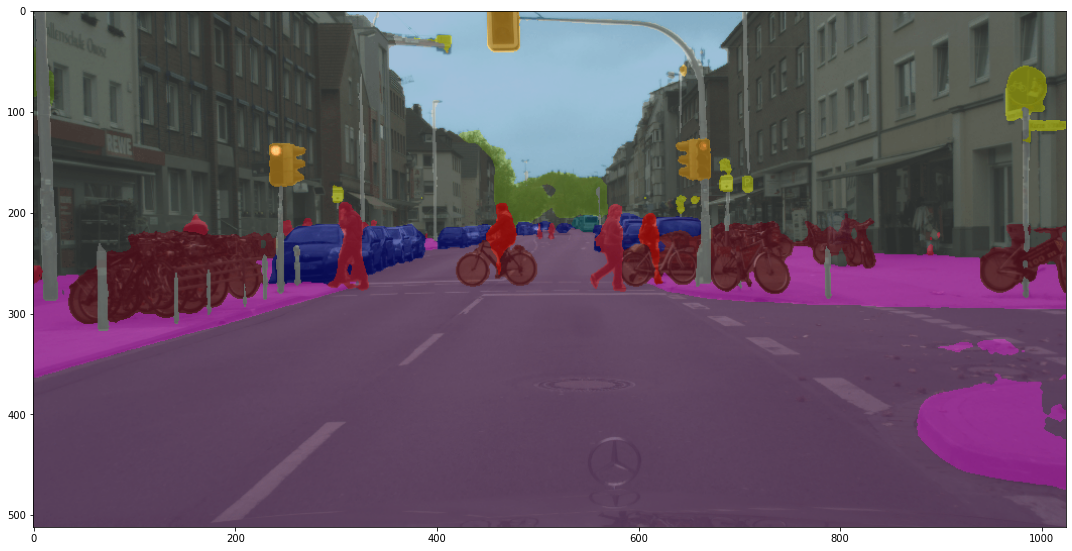

In [8]:
# show the results
show_result_pyplot(model, img, result, get_palette('cityscapes'))

## Train a semantic segmentation model on a new dataset

To train on a customized dataset, the following steps are neccessary. 
1. Add a new dataset class. 
2. Create a config file accordingly. 
3. Perform training and evaluation. 

### Add a new dataset

ここで用いる画像データは，前回と同様に以下のサイトより取得します．

ここには，車載カメラから撮像された画像と、車、歩行者、道路を含む 32 個のラベル画像が提供されています。このサイトから画像を取得し、それをベースに実行してもよいのですが、今回はSegmentaion-modelsで紹介されている方法より画像を取得します。

In [10]:
#モジュールのimport
import os
os.environ['CUDA_VISIBLE_DEVICES'] = '0'

import numpy as np
import cv2
import matplotlib.pyplot as plt

すでにDownloadしている場合はスキップ

In [17]:
DATA_DIR = 'CamVid'

# load repo with data if it is not exists
if not os.path.exists(DATA_DIR):
    print('Loading data...')
    os.system('git clone https://github.com/alexgkendall/SegNet-Tutorial')
    print('Done!')

(360, 480, 3)


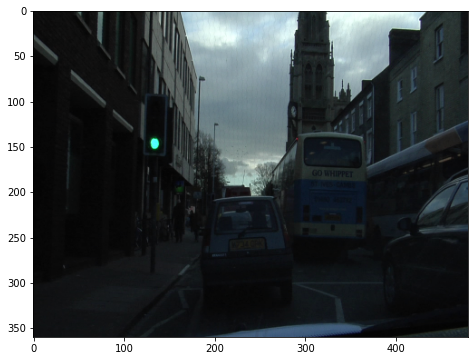

In [11]:
# Let's take a look at the dataset
import mmcv
import matplotlib.pyplot as plt

img = mmcv.imread('SegNet-Tutorial/CamVid/train/0001TP_006690.png')
print(img.shape)
plt.figure(figsize=(8, 6))
plt.imshow(mmcv.bgr2rgb(img))
plt.show()

In [12]:
#画像サイズ情報の取得

h = img.shape[0]
w = img.shape[1]

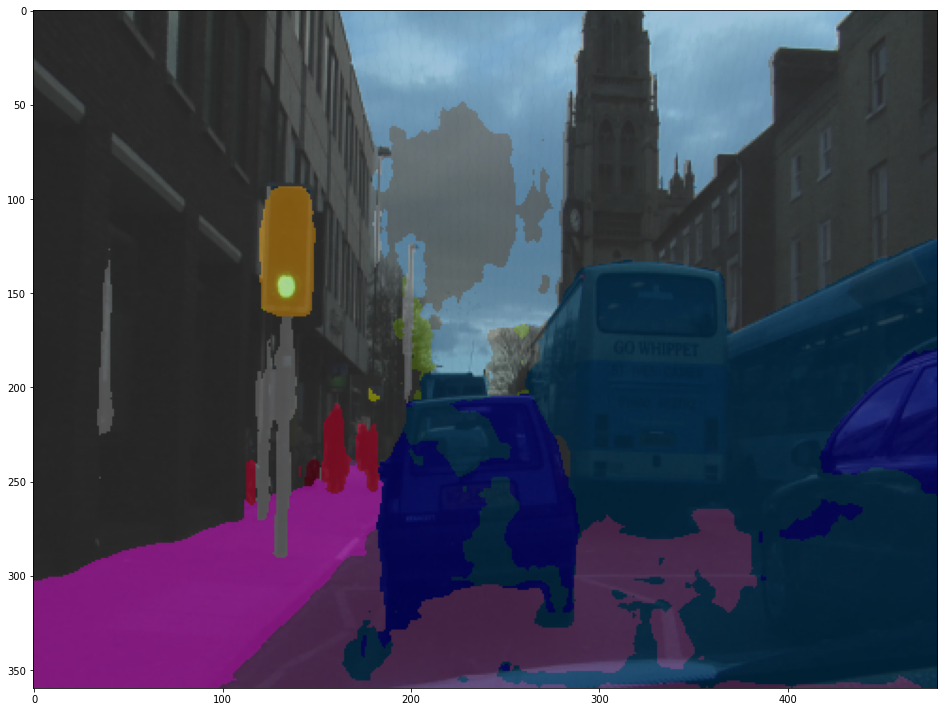

In [13]:
# test a single image
img = 'SegNet-Tutorial/CamVid/train/0001TP_006690.png'
result = inference_segmentor(model, img)

show_result_pyplot(model, img, result, get_palette('cityscapes'))

We need to convert the annotation into semantic map format as an image.

In [14]:
import os.path as osp
import numpy as np
from PIL import Image
# convert dataset annotation to semantic segmentation map
data_root = 'SegNet-Tutorial/CamVid'
img_dir = 'train'
ann_dir = 'trainannot'
# define class and plaette for better visualization
classes = ('sky', 'Bulding', 'Pole', 'Road_marking', 'Road', 'Pavement', 'Tree', 'SingSymbole','Fence', 'Car', 'Pedestrian', 'Bicyclist', 'Unlabeled')
palette = [[128,128,128], [128,0,0], [192,192,128], [255,69,0], [128,64,128], [60,40,222], [128,128,0], [192,128,128], [64,64,128], [64,0,128], [64,64,0], [0,128,192], [0,0,0]]


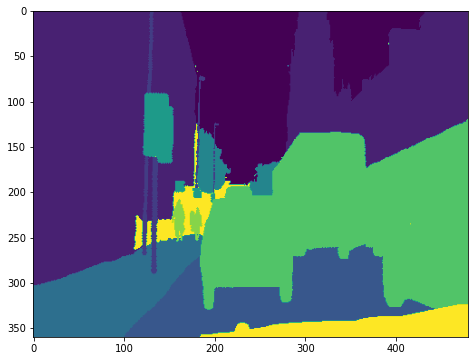

In [15]:
# Let's take a look at the segmentation map we got
import matplotlib.patches as mpatches
img = Image.open('SegNet-Tutorial/CamVid/trainannot/0001TP_006690.png')
plt.figure(figsize=(8, 6))
img_p = np.array(img.convert('P'))
plt.imshow(np.array(img.convert('P'))) #'RGB'

plt.show()

In [16]:
img_p.shape

(360, 480)

In [17]:
# split train/val set randomly
split_dir = 'splits_resnet50A'
mmcv.mkdir_or_exist(osp.join(data_root, split_dir))
filename_list = [osp.splitext(filename)[0] for filename in mmcv.scandir(
    osp.join(data_root, ann_dir), suffix='.png')]
with open(osp.join(data_root, split_dir, 'train.txt'), 'w') as f:
  # select first 4/5 as train set
  train_length = int(len(filename_list)*4/5)
  f.writelines(line + '\n' for line in filename_list[:train_length])
with open(osp.join(data_root, split_dir, 'val.txt'), 'w') as f:
  # select last 1/5 as train set
  f.writelines(line + '\n' for line in filename_list[train_length:])

After downloading the data, we need to implement `load_annotations` function in the new dataset class `StandfordBackgroundDataset`.

In [18]:
from mmseg.datasets.builder import DATASETS
from mmseg.datasets.custom import CustomDataset

@DATASETS.register_module()
class splits_resnet50A(CustomDataset):
  CLASSES = classes
  PALETTE = palette
  def __init__(self, split, **kwargs):
    super().__init__(img_suffix='.png', seg_map_suffix='.png', 
                     split=split, **kwargs)
    assert osp.exists(self.img_dir) and self.split is not None

### Create a config file
In the next step, we need to modify the config for the training. To accelerate the process, we finetune the model from trained weights.

In [20]:
from mmcv import Config
cfg = Config.fromfile('configs/pspnet/pspnet_r50-d8_512x1024_40k_cityscapes.py')

Since the given config is used to train PSPNet on cityscapes dataset, we need to modify it accordingly for our new dataset.  

In [22]:
classes

('sky',
 'Bulding',
 'Pole',
 'Road_marking',
 'Road',
 'Pavement',
 'Tree',
 'SingSymbole',
 'Fence',
 'Car',
 'Pedestrian',
 'Bicyclist',
 'Unlabeled')

In [23]:
palette

[[128, 128, 128],
 [128, 0, 0],
 [192, 192, 128],
 [255, 69, 0],
 [128, 64, 128],
 [60, 40, 222],
 [128, 128, 0],
 [192, 128, 128],
 [64, 64, 128],
 [64, 0, 128],
 [64, 64, 0],
 [0, 128, 192],
 [0, 0, 0]]

In [24]:
from mmseg.apis import set_random_seed

# add CLASSES and PALETTE to checkpoint
cfg.checkpoint_config.meta = dict(
   CLASSES=classes,
 PALETTE=palette)

# Since we use ony one GPU, BN is used instead of SyncBN
cfg.norm_cfg = dict(type='BN', requires_grad=True)
cfg.model.backbone.norm_cfg = cfg.norm_cfg
cfg.model.decode_head.norm_cfg = cfg.norm_cfg
cfg.model.auxiliary_head.norm_cfg = cfg.norm_cfg
# modify num classes of the model in decode/auxiliary head
cfg.model.decode_head.num_classes = len(classes) #8
cfg.model.auxiliary_head.num_classes = len(classes) #8

# Modify dataset type and path
cfg.dataset_type = 'splits_resnet50A'
cfg.data_root = data_root

cfg.data.samples_per_gpu = 8
cfg.data.workers_per_gpu=8

cfg.img_norm_cfg = dict(
    mean=[123.675, 116.28, 103.53], std=[58.395, 57.12, 57.375], to_rgb=True)
cfg.crop_size = (256, 256)
cfg.train_pipeline = [
    dict(type='LoadImageFromFile'),
    dict(type='LoadAnnotations'),
    dict(type='Resize', img_scale=(w, h), ratio_range=(0.5, 2.0)),
    dict(type='RandomCrop', crop_size=cfg.crop_size, cat_max_ratio=0.75),
    dict(type='RandomFlip', flip_ratio=0.5),
    dict(type='PhotoMetricDistortion'),
    dict(type='Normalize', **cfg.img_norm_cfg),
    dict(type='Pad', size=cfg.crop_size, pad_val=0, seg_pad_val=255),
    dict(type='DefaultFormatBundle'),
    dict(type='Collect', keys=['img', 'gt_semantic_seg']),
]

cfg.test_pipeline = [
    dict(type='LoadImageFromFile'),
    dict(
        type='MultiScaleFlipAug',
        img_scale=(w, h),
        # img_ratios=[0.5, 0.75, 1.0, 1.25, 1.5, 1.75],
        flip=False,
        transforms=[
            dict(type='Resize', keep_ratio=True),
            dict(type='RandomFlip'),
            dict(type='Normalize', **cfg.img_norm_cfg),
            dict(type='ImageToTensor', keys=['img']),
            dict(type='Collect', keys=['img']),
        ])
]


cfg.data.train.type = cfg.dataset_type
cfg.data.train.data_root = cfg.data_root
cfg.data.train.img_dir = img_dir
cfg.data.train.ann_dir = ann_dir
cfg.data.train.pipeline = cfg.train_pipeline
cfg.data.train.split = 'splits_resnet50A/train.txt'

cfg.data.val.type = cfg.dataset_type
cfg.data.val.data_root = cfg.data_root
cfg.data.val.img_dir = img_dir
cfg.data.val.ann_dir = ann_dir
cfg.data.val.pipeline = cfg.test_pipeline
cfg.data.val.split = 'splits_resnet50A/val.txt'

cfg.data.test.type = cfg.dataset_type
cfg.data.test.data_root = cfg.data_root
cfg.data.test.img_dir = img_dir
cfg.data.test.ann_dir = ann_dir
cfg.data.test.pipeline = cfg.test_pipeline
cfg.data.test.split = 'splits_resnet50A/val.txt'

# We can still use the pre-trained Mask RCNN model though we do not need to
# use the mask branch
#cfg.load_from = 'checkpoints/pspnet_r50-d8_512x1024_40k_cityscapes_20200605_003338-2966598c.pth'

# Set up working dir to save files and logs.
cfg.work_dir = './work_dirs/tutorial_pspnet_r50A'

cfg.total_iters = 1000
cfg.log_config.interval = 10
cfg.evaluation.interval = 200
cfg.checkpoint_config.interval = 1000

# Set seed to facitate reproducing the result
cfg.seed = 0
set_random_seed(0, deterministic=False)
cfg.gpu_ids = range(1)

# Let's have a look at the final config used for training
print(f'Config:\n{cfg.pretty_text}')

Config:
norm_cfg = dict(type='BN', requires_grad=True)
model = dict(
    type='EncoderDecoder',
    pretrained='open-mmlab://resnet50_v1c',
    backbone=dict(
        type='ResNetV1c',
        depth=50,
        num_stages=4,
        out_indices=(0, 1, 2, 3),
        dilations=(1, 1, 2, 4),
        strides=(1, 2, 1, 1),
        norm_cfg=dict(type='BN', requires_grad=True),
        norm_eval=False,
        style='pytorch',
        contract_dilation=True),
    decode_head=dict(
        type='PSPHead',
        in_channels=2048,
        in_index=3,
        channels=512,
        pool_scales=(1, 2, 3, 6),
        dropout_ratio=0.1,
        num_classes=13,
        norm_cfg=dict(type='BN', requires_grad=True),
        align_corners=False,
        loss_decode=dict(
            type='CrossEntropyLoss', use_sigmoid=False, loss_weight=1.0)),
    auxiliary_head=dict(
        type='FCNHead',
        in_channels=1024,
        in_index=2,
        channels=256,
        num_convs=1,
        concat_input=

### Train and Evaluation

In [25]:
from mmseg.datasets import build_dataset
from mmseg.models import build_segmentor
from mmseg.apis import train_segmentor


# Build the dataset
datasets = [build_dataset(cfg.data.train)]

# Build the detector
model = build_segmentor(
    cfg.model, train_cfg=cfg.get('train_cfg'), test_cfg=cfg.get('test_cfg'))
# Add an attribute for visualization convenience
model.CLASSES = datasets[0].CLASSES

# Create work_dir
mmcv.mkdir_or_exist(osp.abspath(cfg.work_dir))
train_segmentor(model, datasets, cfg, distributed=False, validate=True, 
                meta=dict())

2022-02-19 09:28:56,534 - mmseg - INFO - Loaded 293 images
/home/nigo/nigo/mmdetection/scr/mmsegmentation/mmseg/models/backbones/resnet.py:431: UserWarning: DeprecationWarning: pretrained is a deprecated, please use "init_cfg" instead
  warnings.warn('DeprecationWarning: pretrained is a deprecated, '
2022-02-19 09:28:57,017 - mmseg - INFO - Loaded 74 images
2022-02-19 09:28:57,017 - mmseg - INFO - Start running, host: nigo@nigo-System-Product-Name, work_dir: /home/nigo/nigo/mmdetection/scr/mmsegmentation/work_dirs/tutorial_pspnet_r50A
2022-02-19 09:28:57,017 - mmseg - INFO - Hooks will be executed in the following order:
before_run:
(VERY_HIGH   ) PolyLrUpdaterHook                  
(NORMAL      ) CheckpointHook                     
(LOW         ) EvalHook                           
(VERY_LOW    ) TextLoggerHook                     
 -------------------- 
before_train_epoch:
(VERY_HIGH   ) PolyLrUpdaterHook                  
(LOW         ) IterTimerHook                      
(LOW      

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 74/74, 26.7 task/s, elapsed: 3s, ETA:     0s

2022-02-19 09:29:50,933 - mmseg - INFO - per class results:
2022-02-19 09:29:50,934 - mmseg - INFO - 
+--------------+-------+-------+
|    Class     |  IoU  |  Acc  |
+--------------+-------+-------+
|     sky      | 80.57 | 88.45 |
|   Bulding    | 51.52 | 88.17 |
|     Pole     |  0.0  |  0.0  |
| Road_marking | 87.36 | 97.79 |
|     Road     |  9.7  |  9.93 |
|   Pavement   |  6.5  |  6.8  |
|     Tree     |  0.0  |  0.0  |
| SingSymbole  |  0.0  |  0.0  |
|    Fence     | 43.88 | 65.66 |
|     Car      |  0.0  |  0.0  |
|  Pedestrian  |  0.0  |  0.0  |
|  Bicyclist   |  7.28 |  9.24 |
|  Unlabeled   |  nan  |  nan  |
+--------------+-------+-------+
2022-02-19 09:29:50,935 - mmseg - INFO - Summary:
2022-02-19 09:29:50,935 - mmseg - INFO - 
+-------+------+------+
|  aAcc | mIoU | mAcc |
+-------+------+------+
| 73.18 | 23.9 | 30.5 |
+-------+------+------+
2022-02-19 09:29:50,936 - mmseg - INFO - Iter(val) [74]	aAcc: 0.7318, mIoU: 0.2390, mAcc: 0.3050, IoU.sky: 0.8057, IoU.Buldin

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 74/74, 37.4 task/s, elapsed: 2s, ETA:     0s

2022-02-19 09:30:44,755 - mmseg - INFO - per class results:
2022-02-19 09:30:44,755 - mmseg - INFO - 
+--------------+-------+-------+
|    Class     |  IoU  |  Acc  |
+--------------+-------+-------+
|     sky      | 19.49 |  19.6 |
|   Bulding    |  46.1 | 97.17 |
|     Pole     |  0.0  |  0.0  |
| Road_marking | 89.01 |  93.3 |
|     Road     | 40.21 | 57.19 |
|   Pavement   | 35.49 | 39.15 |
|     Tree     |  0.0  |  0.0  |
| SingSymbole  |  0.0  |  0.0  |
|    Fence     | 57.45 | 70.11 |
|     Car      |  0.09 |  0.09 |
|  Pedestrian  |  0.0  |  0.0  |
|  Bicyclist   |  0.68 |  0.69 |
|  Unlabeled   |  nan  |  nan  |
+--------------+-------+-------+
2022-02-19 09:30:44,756 - mmseg - INFO - Summary:
2022-02-19 09:30:44,756 - mmseg - INFO - 
+------+-------+-------+
| aAcc |  mIoU |  mAcc |
+------+-------+-------+
| 67.8 | 24.04 | 31.44 |
+------+-------+-------+
2022-02-19 09:30:44,757 - mmseg - INFO - Iter(val) [74]	aAcc: 0.6780, mIoU: 0.2404, mAcc: 0.3144, IoU.sky: 0.1949, IoU.B

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 74/74, 37.1 task/s, elapsed: 2s, ETA:     0s

2022-02-19 09:31:36,896 - mmseg - INFO - per class results:
2022-02-19 09:31:36,896 - mmseg - INFO - 
+--------------+-------+-------+
|    Class     |  IoU  |  Acc  |
+--------------+-------+-------+
|     sky      | 85.51 | 95.64 |
|   Bulding    | 66.84 | 81.92 |
|     Pole     |  0.0  |  0.0  |
| Road_marking | 90.18 | 94.38 |
|     Road     | 43.47 | 54.69 |
|   Pavement   | 49.54 | 84.07 |
|     Tree     |  0.0  |  0.0  |
| SingSymbole  |  3.79 |  4.46 |
|    Fence     | 58.83 | 68.95 |
|     Car      |  1.4  |  1.43 |
|  Pedestrian  |  0.0  |  0.0  |
|  Bicyclist   | 13.41 | 17.76 |
|  Unlabeled   |  nan  |  nan  |
+--------------+-------+-------+
2022-02-19 09:31:36,897 - mmseg - INFO - Summary:
2022-02-19 09:31:36,897 - mmseg - INFO - 
+-------+-------+-------+
|  aAcc |  mIoU |  mAcc |
+-------+-------+-------+
| 81.32 | 34.41 | 41.94 |
+-------+-------+-------+
2022-02-19 09:31:36,897 - mmseg - INFO - Iter(val) [74]	aAcc: 0.8132, mIoU: 0.3441, mAcc: 0.4194, IoU.sky: 0.8551, 

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 74/74, 36.5 task/s, elapsed: 2s, ETA:     0s

2022-02-19 09:32:30,900 - mmseg - INFO - per class results:
2022-02-19 09:32:30,901 - mmseg - INFO - 
+--------------+-------+-------+
|    Class     |  IoU  |  Acc  |
+--------------+-------+-------+
|     sky      | 86.41 | 95.98 |
|   Bulding    | 70.42 | 86.76 |
|     Pole     |  0.24 |  0.24 |
| Road_marking | 93.32 | 96.33 |
|     Road     | 52.87 |  62.4 |
|   Pavement   | 53.78 |  77.6 |
|     Tree     |  0.02 |  0.02 |
| SingSymbole  |  3.31 |  3.38 |
|    Fence     |  59.2 | 85.36 |
|     Car      |  2.19 |  2.43 |
|  Pedestrian  |  0.89 |  0.89 |
|  Bicyclist   |  8.46 |  9.66 |
|  Unlabeled   |  nan  |  nan  |
+--------------+-------+-------+
2022-02-19 09:32:30,901 - mmseg - INFO - Summary:
2022-02-19 09:32:30,901 - mmseg - INFO - 
+-------+-------+-------+
|  aAcc |  mIoU |  mAcc |
+-------+-------+-------+
| 83.61 | 35.93 | 43.42 |
+-------+-------+-------+
2022-02-19 09:32:30,902 - mmseg - INFO - Iter(val) [74]	aAcc: 0.8361, mIoU: 0.3593, mAcc: 0.4342, IoU.sky: 0.8641, 

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 74/74, 36.4 task/s, elapsed: 2s, ETA:     0s

2022-02-19 09:33:23,776 - mmseg - INFO - per class results:
2022-02-19 09:33:23,777 - mmseg - INFO - 
+--------------+-------+-------+
|    Class     |  IoU  |  Acc  |
+--------------+-------+-------+
|     sky      | 86.74 | 91.34 |
|   Bulding    | 74.98 | 93.39 |
|     Pole     |  1.11 |  1.17 |
| Road_marking | 93.21 | 97.13 |
|     Road     | 58.48 | 77.19 |
|   Pavement   |  61.5 | 78.72 |
|     Tree     |  2.07 |  2.09 |
| SingSymbole  |  21.3 | 24.65 |
|    Fence     | 68.63 | 76.63 |
|     Car      |  5.05 |  5.76 |
|  Pedestrian  |  4.53 |  4.72 |
|  Bicyclist   | 16.23 | 21.95 |
|  Unlabeled   |  nan  |  nan  |
+--------------+-------+-------+
2022-02-19 09:33:23,777 - mmseg - INFO - Summary:
2022-02-19 09:33:23,778 - mmseg - INFO - 
+-------+-------+-------+
|  aAcc |  mIoU |  mAcc |
+-------+-------+-------+
| 85.68 | 41.15 | 47.89 |
+-------+-------+-------+
2022-02-19 09:33:23,778 - mmseg - INFO - Iter(val) [74]	aAcc: 0.8568, mIoU: 0.4115, mAcc: 0.4789, IoU.sky: 0.8674, 

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 74/74, 36.0 task/s, elapsed: 2s, ETA:     0s

2022-02-19 09:34:18,420 - mmseg - INFO - per class results:
2022-02-19 09:34:18,420 - mmseg - INFO - 
+--------------+-------+-------+
|    Class     |  IoU  |  Acc  |
+--------------+-------+-------+
|     sky      | 87.87 | 93.59 |
|   Bulding    | 75.79 | 88.61 |
|     Pole     |  1.57 |  1.66 |
| Road_marking | 94.52 | 96.38 |
|     Road     | 63.82 | 80.23 |
|   Pavement   | 60.16 | 87.26 |
|     Tree     |  4.65 |  4.89 |
| SingSymbole  |  20.1 | 29.18 |
|    Fence     | 71.56 | 82.25 |
|     Car      | 11.29 | 14.64 |
|  Pedestrian  | 16.01 |  18.8 |
|  Bicyclist   | 20.84 | 27.24 |
|  Unlabeled   |  nan  |  nan  |
+--------------+-------+-------+
2022-02-19 09:34:18,421 - mmseg - INFO - Summary:
2022-02-19 09:34:18,421 - mmseg - INFO - 
+-------+-------+-------+
|  aAcc |  mIoU |  mAcc |
+-------+-------+-------+
| 86.26 | 44.02 | 52.06 |
+-------+-------+-------+
2022-02-19 09:34:18,422 - mmseg - INFO - Iter(val) [74]	aAcc: 0.8626, mIoU: 0.4402, mAcc: 0.5206, IoU.sky: 0.8787, 

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 74/74, 35.7 task/s, elapsed: 2s, ETA:     0s

2022-02-19 09:35:11,371 - mmseg - INFO - per class results:
2022-02-19 09:35:11,372 - mmseg - INFO - 
+--------------+-------+-------+
|    Class     |  IoU  |  Acc  |
+--------------+-------+-------+
|     sky      | 78.85 | 81.62 |
|   Bulding    | 70.22 | 76.22 |
|     Pole     |  1.84 |  1.97 |
| Road_marking | 94.79 | 97.23 |
|     Road     | 61.32 | 86.19 |
|   Pavement   | 47.56 | 89.88 |
|     Tree     |  10.2 |  11.3 |
| SingSymbole  | 26.95 | 50.65 |
|    Fence     | 74.48 | 84.85 |
|     Car      | 15.75 | 24.77 |
|  Pedestrian  | 17.86 | 22.61 |
|  Bicyclist   | 18.28 | 26.49 |
|  Unlabeled   |  nan  |  nan  |
+--------------+-------+-------+
2022-02-19 09:35:11,372 - mmseg - INFO - Summary:
2022-02-19 09:35:11,372 - mmseg - INFO - 
+-------+-------+-------+
|  aAcc |  mIoU |  mAcc |
+-------+-------+-------+
| 82.68 | 43.17 | 54.48 |
+-------+-------+-------+
2022-02-19 09:35:11,373 - mmseg - INFO - Iter(val) [74]	aAcc: 0.8268, mIoU: 0.4317, mAcc: 0.5448, IoU.sky: 0.7885, 

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 74/74, 34.6 task/s, elapsed: 2s, ETA:     0s

2022-02-19 09:36:06,626 - mmseg - INFO - per class results:
2022-02-19 09:36:06,627 - mmseg - INFO - 
+--------------+-------+-------+
|    Class     |  IoU  |  Acc  |
+--------------+-------+-------+
|     sky      | 88.36 | 95.15 |
|   Bulding    |  76.1 | 93.91 |
|     Pole     |  1.64 |  1.71 |
| Road_marking | 95.53 | 97.88 |
|     Road     | 67.76 | 81.27 |
|   Pavement   |  61.9 | 73.19 |
|     Tree     | 10.52 | 11.13 |
| SingSymbole  | 26.32 | 51.75 |
|    Fence     | 72.87 | 80.66 |
|     Car      |  9.1  | 11.28 |
|  Pedestrian  | 16.83 | 19.62 |
|  Bicyclist   | 21.33 | 25.76 |
|  Unlabeled   |  nan  |  nan  |
+--------------+-------+-------+
2022-02-19 09:36:06,627 - mmseg - INFO - Summary:
2022-02-19 09:36:06,628 - mmseg - INFO - 
+-------+-------+-------+
|  aAcc |  mIoU |  mAcc |
+-------+-------+-------+
| 87.17 | 45.69 | 53.61 |
+-------+-------+-------+
2022-02-19 09:36:06,628 - mmseg - INFO - Iter(val) [74]	aAcc: 0.8717, mIoU: 0.4569, mAcc: 0.5361, IoU.sky: 0.8836, 

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 74/74, 36.3 task/s, elapsed: 2s, ETA:     0s

2022-02-19 09:36:58,814 - mmseg - INFO - per class results:
2022-02-19 09:36:58,814 - mmseg - INFO - 
+--------------+-------+-------+
|    Class     |  IoU  |  Acc  |
+--------------+-------+-------+
|     sky      | 88.03 |  93.0 |
|   Bulding    |  78.7 | 90.88 |
|     Pole     |  5.66 |  6.6  |
| Road_marking |  95.3 | 97.34 |
|     Road     |  67.2 | 81.05 |
|   Pavement   | 65.52 | 85.49 |
|     Tree     | 19.39 |  23.2 |
| SingSymbole  | 28.11 | 40.36 |
|    Fence     | 75.94 | 87.35 |
|     Car      | 10.97 | 12.57 |
|  Pedestrian  | 25.59 | 33.21 |
|  Bicyclist   | 28.63 | 38.75 |
|  Unlabeled   |  nan  |  nan  |
+--------------+-------+-------+
2022-02-19 09:36:58,815 - mmseg - INFO - Summary:
2022-02-19 09:36:58,815 - mmseg - INFO - 
+-------+-------+-------+
|  aAcc |  mIoU |  mAcc |
+-------+-------+-------+
| 87.94 | 49.09 | 57.48 |
+-------+-------+-------+
2022-02-19 09:36:58,816 - mmseg - INFO - Iter(val) [74]	aAcc: 0.8794, mIoU: 0.4909, mAcc: 0.5748, IoU.sky: 0.8803, 

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 74/74, 35.8 task/s, elapsed: 2s, ETA:     0s

2022-02-19 09:37:53,365 - mmseg - INFO - per class results:
2022-02-19 09:37:53,366 - mmseg - INFO - 
+--------------+-------+-------+
|    Class     |  IoU  |  Acc  |
+--------------+-------+-------+
|     sky      | 88.82 | 94.83 |
|   Bulding    | 74.57 | 95.78 |
|     Pole     |  4.87 |  5.55 |
| Road_marking |  95.3 | 97.99 |
|     Road     | 67.55 | 78.17 |
|   Pavement   | 61.51 | 69.81 |
|     Tree     | 12.92 | 13.76 |
| SingSymbole  | 31.82 | 38.38 |
|    Fence     | 75.61 | 83.77 |
|     Car      | 16.55 | 22.47 |
|  Pedestrian  | 25.02 | 30.52 |
|  Bicyclist   | 17.94 | 21.79 |
|  Unlabeled   |  nan  |  nan  |
+--------------+-------+-------+
2022-02-19 09:37:53,367 - mmseg - INFO - Summary:
2022-02-19 09:37:53,367 - mmseg - INFO - 
+-------+-------+------+
|  aAcc |  mIoU | mAcc |
+-------+-------+------+
| 87.21 | 47.71 | 54.4 |
+-------+-------+------+
2022-02-19 09:37:53,367 - mmseg - INFO - Iter(val) [74]	aAcc: 0.8721, mIoU: 0.4771, mAcc: 0.5440, IoU.sky: 0.8882, IoU.B

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 74/74, 35.5 task/s, elapsed: 2s, ETA:     0s

2022-02-19 09:38:47,481 - mmseg - INFO - per class results:
2022-02-19 09:38:47,482 - mmseg - INFO - 
+--------------+-------+-------+
|    Class     |  IoU  |  Acc  |
+--------------+-------+-------+
|     sky      | 86.31 | 88.91 |
|   Bulding    | 77.12 | 94.52 |
|     Pole     |  8.13 | 12.26 |
| Road_marking | 95.68 | 97.84 |
|     Road     | 70.49 | 82.03 |
|   Pavement   |  62.0 |  77.5 |
|     Tree     | 18.05 | 25.81 |
| SingSymbole  | 34.25 | 48.69 |
|    Fence     | 75.29 | 81.14 |
|     Car      | 12.82 | 15.25 |
|  Pedestrian  | 21.38 |  26.3 |
|  Bicyclist   | 28.48 | 37.57 |
|  Unlabeled   |  nan  |  nan  |
+--------------+-------+-------+
2022-02-19 09:38:47,482 - mmseg - INFO - Summary:
2022-02-19 09:38:47,483 - mmseg - INFO - 
+-------+-------+-------+
|  aAcc |  mIoU |  mAcc |
+-------+-------+-------+
| 87.39 | 49.17 | 57.32 |
+-------+-------+-------+
2022-02-19 09:38:47,483 - mmseg - INFO - Iter(val) [74]	aAcc: 0.8739, mIoU: 0.4917, mAcc: 0.5732, IoU.sky: 0.8631, 

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 74/74, 36.1 task/s, elapsed: 2s, ETA:     0s

2022-02-19 09:39:39,632 - mmseg - INFO - per class results:
2022-02-19 09:39:39,633 - mmseg - INFO - 
+--------------+-------+-------+
|    Class     |  IoU  |  Acc  |
+--------------+-------+-------+
|     sky      | 89.05 | 96.15 |
|   Bulding    | 82.01 | 92.67 |
|     Pole     |  6.31 |  7.29 |
| Road_marking | 96.22 | 98.35 |
|     Road     | 72.95 | 83.32 |
|   Pavement   | 70.81 | 84.42 |
|     Tree     | 21.96 | 24.79 |
| SingSymbole  | 35.68 | 43.22 |
|    Fence     | 78.21 | 92.32 |
|     Car      |  18.6 | 22.33 |
|  Pedestrian  | 22.07 | 27.26 |
|  Bicyclist   | 35.85 | 45.59 |
|  Unlabeled   |  nan  |  nan  |
+--------------+-------+-------+
2022-02-19 09:39:39,633 - mmseg - INFO - Summary:
2022-02-19 09:39:39,633 - mmseg - INFO - 
+-------+-------+-------+
|  aAcc |  mIoU |  mAcc |
+-------+-------+-------+
| 89.85 | 52.48 | 59.81 |
+-------+-------+-------+
2022-02-19 09:39:39,634 - mmseg - INFO - Iter(val) [74]	aAcc: 0.8985, mIoU: 0.5248, mAcc: 0.5981, IoU.sky: 0.8905, 

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 74/74, 36.9 task/s, elapsed: 2s, ETA:     0s

2022-02-19 09:40:33,825 - mmseg - INFO - per class results:
2022-02-19 09:40:33,826 - mmseg - INFO - 
+--------------+-------+-------+
|    Class     |  IoU  |  Acc  |
+--------------+-------+-------+
|     sky      |  89.6 | 95.64 |
|   Bulding    | 80.59 | 93.54 |
|     Pole     |  5.28 |  5.81 |
| Road_marking |  95.8 | 98.33 |
|     Road     | 70.37 | 79.54 |
|   Pavement   | 69.41 | 78.61 |
|     Tree     | 26.09 | 32.61 |
| SingSymbole  |  37.9 | 43.56 |
|    Fence     | 74.03 | 94.11 |
|     Car      | 18.63 | 21.64 |
|  Pedestrian  |  23.8 | 28.16 |
|  Bicyclist   | 32.44 | 41.26 |
|  Unlabeled   |  nan  |  nan  |
+--------------+-------+-------+
2022-02-19 09:40:33,826 - mmseg - INFO - Summary:
2022-02-19 09:40:33,826 - mmseg - INFO - 
+-------+-------+------+
|  aAcc |  mIoU | mAcc |
+-------+-------+------+
| 89.28 | 51.99 | 59.4 |
+-------+-------+------+
2022-02-19 09:40:33,827 - mmseg - INFO - Iter(val) [74]	aAcc: 0.8928, mIoU: 0.5199, mAcc: 0.5940, IoU.sky: 0.8960, IoU.B

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 74/74, 35.7 task/s, elapsed: 2s, ETA:     0s

2022-02-19 09:41:26,107 - mmseg - INFO - per class results:
2022-02-19 09:41:26,108 - mmseg - INFO - 
+--------------+-------+-------+
|    Class     |  IoU  |  Acc  |
+--------------+-------+-------+
|     sky      | 88.66 | 93.21 |
|   Bulding    | 80.18 | 91.93 |
|     Pole     |  8.57 | 11.79 |
| Road_marking | 96.23 | 97.31 |
|     Road     |  71.0 | 79.64 |
|   Pavement   | 68.78 | 90.24 |
|     Tree     | 30.62 | 39.96 |
| SingSymbole  | 31.99 | 58.16 |
|    Fence     | 77.86 | 90.51 |
|     Car      |  9.38 | 10.56 |
|  Pedestrian  | 20.95 | 22.58 |
|  Bicyclist   | 27.79 | 32.24 |
|  Unlabeled   |  nan  |  nan  |
+--------------+-------+-------+
2022-02-19 09:41:26,109 - mmseg - INFO - Summary:
2022-02-19 09:41:26,109 - mmseg - INFO - 
+-------+------+-------+
|  aAcc | mIoU |  mAcc |
+-------+------+-------+
| 88.88 | 51.0 | 59.84 |
+-------+------+-------+
2022-02-19 09:41:26,109 - mmseg - INFO - Iter(val) [74]	aAcc: 0.8888, mIoU: 0.5100, mAcc: 0.5984, IoU.sky: 0.8866, IoU.B

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 74/74, 36.8 task/s, elapsed: 2s, ETA:     0s

2022-02-19 09:42:20,927 - mmseg - INFO - per class results:
2022-02-19 09:42:20,928 - mmseg - INFO - 
+--------------+-------+-------+
|    Class     |  IoU  |  Acc  |
+--------------+-------+-------+
|     sky      |  89.1 | 92.74 |
|   Bulding    | 79.47 | 96.41 |
|     Pole     |  2.97 |  3.23 |
| Road_marking | 95.91 | 97.64 |
|     Road     | 71.36 | 89.76 |
|   Pavement   | 67.64 | 79.33 |
|     Tree     | 14.48 | 15.48 |
| SingSymbole  |  39.3 | 41.87 |
|    Fence     | 80.37 | 85.51 |
|     Car      | 24.13 | 37.74 |
|  Pedestrian  | 21.23 |  24.5 |
|  Bicyclist   | 30.87 | 38.37 |
|  Unlabeled   |  nan  |  nan  |
+--------------+-------+-------+
2022-02-19 09:42:20,928 - mmseg - INFO - Summary:
2022-02-19 09:42:20,928 - mmseg - INFO - 
+-------+------+-------+
|  aAcc | mIoU |  mAcc |
+-------+------+-------+
| 89.09 | 51.4 | 58.55 |
+-------+------+-------+
2022-02-19 09:42:20,929 - mmseg - INFO - Iter(val) [74]	aAcc: 0.8909, mIoU: 0.5140, mAcc: 0.5855, IoU.sky: 0.8910, IoU.B

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 74/74, 35.7 task/s, elapsed: 2s, ETA:     0s

2022-02-19 09:43:13,304 - mmseg - INFO - per class results:
2022-02-19 09:43:13,305 - mmseg - INFO - 
+--------------+-------+-------+
|    Class     |  IoU  |  Acc  |
+--------------+-------+-------+
|     sky      | 88.87 | 93.54 |
|   Bulding    | 83.18 | 91.27 |
|     Pole     | 10.95 | 14.82 |
| Road_marking | 96.77 | 98.07 |
|     Road     | 75.67 | 88.95 |
|   Pavement   | 72.44 | 90.67 |
|     Tree     | 30.09 | 37.06 |
| SingSymbole  | 45.22 | 64.04 |
|    Fence     | 83.07 | 93.57 |
|     Car      | 28.15 | 38.12 |
|  Pedestrian  |  40.0 | 57.15 |
|  Bicyclist   |  36.7 | 45.36 |
|  Unlabeled   |  nan  |  nan  |
+--------------+-------+-------+
2022-02-19 09:43:13,305 - mmseg - INFO - Summary:
2022-02-19 09:43:13,306 - mmseg - INFO - 
+-------+-------+-------+
|  aAcc |  mIoU |  mAcc |
+-------+-------+-------+
| 90.47 | 57.59 | 67.72 |
+-------+-------+-------+
2022-02-19 09:43:13,306 - mmseg - INFO - Iter(val) [74]	aAcc: 0.9047, mIoU: 0.5759, mAcc: 0.6772, IoU.sky: 0.8887, 

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 74/74, 36.1 task/s, elapsed: 2s, ETA:     0s

2022-02-19 09:44:07,540 - mmseg - INFO - per class results:
2022-02-19 09:44:07,541 - mmseg - INFO - 
+--------------+-------+-------+
|    Class     |  IoU  |  Acc  |
+--------------+-------+-------+
|     sky      | 89.55 | 95.05 |
|   Bulding    | 82.12 | 94.87 |
|     Pole     |  7.12 |  8.41 |
| Road_marking | 96.57 |  98.1 |
|     Road     | 75.04 | 88.62 |
|   Pavement   | 71.38 | 79.45 |
|     Tree     | 34.06 | 42.97 |
| SingSymbole  | 45.73 | 56.38 |
|    Fence     | 81.54 | 92.15 |
|     Car      | 27.03 | 33.65 |
|  Pedestrian  | 37.74 |  47.5 |
|  Bicyclist   | 38.75 |  48.7 |
|  Unlabeled   |  nan  |  nan  |
+--------------+-------+-------+
2022-02-19 09:44:07,541 - mmseg - INFO - Summary:
2022-02-19 09:44:07,542 - mmseg - INFO - 
+-------+-------+-------+
|  aAcc |  mIoU |  mAcc |
+-------+-------+-------+
| 90.44 | 57.22 | 65.49 |
+-------+-------+-------+
2022-02-19 09:44:07,542 - mmseg - INFO - Iter(val) [74]	aAcc: 0.9044, mIoU: 0.5722, mAcc: 0.6549, IoU.sky: 0.8955, 

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 74/74, 36.7 task/s, elapsed: 2s, ETA:     0s

2022-02-19 09:44:59,603 - mmseg - INFO - per class results:
2022-02-19 09:44:59,604 - mmseg - INFO - 
+--------------+-------+-------+
|    Class     |  IoU  |  Acc  |
+--------------+-------+-------+
|     sky      | 85.87 | 88.02 |
|   Bulding    | 82.24 | 93.58 |
|     Pole     |  6.68 |  7.37 |
| Road_marking | 96.65 | 98.15 |
|     Road     | 76.47 | 87.16 |
|   Pavement   | 66.25 | 89.36 |
|     Tree     | 31.65 | 37.35 |
| SingSymbole  | 49.85 | 61.63 |
|    Fence     |  80.3 | 92.51 |
|     Car      | 23.91 | 28.45 |
|  Pedestrian  | 30.49 | 41.54 |
|  Bicyclist   | 38.33 | 45.73 |
|  Unlabeled   |  nan  |  nan  |
+--------------+-------+-------+
2022-02-19 09:44:59,604 - mmseg - INFO - Summary:
2022-02-19 09:44:59,604 - mmseg - INFO - 
+-------+-------+-------+
|  aAcc |  mIoU |  mAcc |
+-------+-------+-------+
| 89.72 | 55.72 | 64.24 |
+-------+-------+-------+
2022-02-19 09:44:59,605 - mmseg - INFO - Iter(val) [74]	aAcc: 0.8972, mIoU: 0.5572, mAcc: 0.6424, IoU.sky: 0.8587, 

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 74/74, 35.4 task/s, elapsed: 2s, ETA:     0s

2022-02-19 09:45:53,887 - mmseg - INFO - per class results:
2022-02-19 09:45:53,887 - mmseg - INFO - 
+--------------+-------+-------+
|    Class     |  IoU  |  Acc  |
+--------------+-------+-------+
|     sky      | 89.66 | 96.44 |
|   Bulding    | 82.86 | 90.24 |
|     Pole     | 10.04 | 12.99 |
| Road_marking | 96.47 | 97.94 |
|     Road     | 75.41 |  85.6 |
|   Pavement   | 73.48 | 87.95 |
|     Tree     | 28.39 |  32.7 |
| SingSymbole  | 28.11 | 89.12 |
|    Fence     | 80.93 | 91.48 |
|     Car      | 23.73 | 28.77 |
|  Pedestrian  | 30.34 | 35.33 |
|  Bicyclist   | 29.77 | 32.87 |
|  Unlabeled   |  nan  |  nan  |
+--------------+-------+-------+
2022-02-19 09:45:53,888 - mmseg - INFO - Summary:
2022-02-19 09:45:53,888 - mmseg - INFO - 
+-------+------+-------+
|  aAcc | mIoU |  mAcc |
+-------+------+-------+
| 89.78 | 54.1 | 65.12 |
+-------+------+-------+
2022-02-19 09:45:53,888 - mmseg - INFO - Iter(val) [74]	aAcc: 0.8978, mIoU: 0.5410, mAcc: 0.6512, IoU.sky: 0.8966, IoU.B

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 74/74, 36.4 task/s, elapsed: 2s, ETA:     0s

2022-02-19 09:46:48,699 - mmseg - INFO - per class results:
2022-02-19 09:46:48,700 - mmseg - INFO - 
+--------------+-------+-------+
|    Class     |  IoU  |  Acc  |
+--------------+-------+-------+
|     sky      | 88.78 | 93.62 |
|   Bulding    | 82.21 | 88.07 |
|     Pole     | 10.06 | 12.86 |
| Road_marking | 96.48 | 97.65 |
|     Road     | 75.43 | 89.28 |
|   Pavement   | 71.83 | 91.91 |
|     Tree     | 35.33 | 51.51 |
| SingSymbole  | 42.66 | 64.44 |
|    Fence     | 82.67 | 91.57 |
|     Car      | 28.03 | 32.89 |
|  Pedestrian  | 46.16 | 61.72 |
|  Bicyclist   | 37.54 | 55.04 |
|  Unlabeled   |  nan  |  nan  |
+--------------+-------+-------+
2022-02-19 09:46:48,700 - mmseg - INFO - Summary:
2022-02-19 09:46:48,700 - mmseg - INFO - 
+-------+------+-------+
|  aAcc | mIoU |  mAcc |
+-------+------+-------+
| 90.02 | 58.1 | 69.21 |
+-------+------+-------+
2022-02-19 09:46:48,701 - mmseg - INFO - Iter(val) [74]	aAcc: 0.9002, mIoU: 0.5810, mAcc: 0.6921, IoU.sky: 0.8878, IoU.B

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 74/74, 36.8 task/s, elapsed: 2s, ETA:     0s

2022-02-19 09:47:40,962 - mmseg - INFO - per class results:
2022-02-19 09:47:40,963 - mmseg - INFO - 
+--------------+-------+-------+
|    Class     |  IoU  |  Acc  |
+--------------+-------+-------+
|     sky      | 89.76 |  96.1 |
|   Bulding    | 83.64 | 90.28 |
|     Pole     | 11.63 | 14.45 |
| Road_marking | 96.63 | 98.53 |
|     Road     | 76.16 |  84.7 |
|   Pavement   | 74.56 |  88.8 |
|     Tree     | 36.08 | 44.51 |
| SingSymbole  | 39.95 | 79.16 |
|    Fence     | 80.31 | 94.21 |
|     Car      |  30.7 | 37.23 |
|  Pedestrian  | 41.69 | 49.23 |
|  Bicyclist   |  37.6 | 45.79 |
|  Unlabeled   |  nan  |  nan  |
+--------------+-------+-------+
2022-02-19 09:47:40,963 - mmseg - INFO - Summary:
2022-02-19 09:47:40,964 - mmseg - INFO - 
+-------+-------+-------+
|  aAcc |  mIoU |  mAcc |
+-------+-------+-------+
| 90.68 | 58.23 | 68.58 |
+-------+-------+-------+
2022-02-19 09:47:40,964 - mmseg - INFO - Iter(val) [74]	aAcc: 0.9068, mIoU: 0.5823, mAcc: 0.6858, IoU.sky: 0.8976, 

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 74/74, 36.2 task/s, elapsed: 2s, ETA:     0s

2022-02-19 09:48:35,221 - mmseg - INFO - per class results:
2022-02-19 09:48:35,222 - mmseg - INFO - 
+--------------+-------+-------+
|    Class     |  IoU  |  Acc  |
+--------------+-------+-------+
|     sky      | 89.72 | 93.39 |
|   Bulding    | 83.25 | 95.92 |
|     Pole     |  9.42 | 11.71 |
| Road_marking | 96.73 | 98.34 |
|     Road     | 76.42 | 87.74 |
|   Pavement   | 75.07 | 89.25 |
|     Tree     | 26.17 | 27.69 |
| SingSymbole  | 48.14 |  63.7 |
|    Fence     | 83.04 | 93.38 |
|     Car      | 18.31 | 19.85 |
|  Pedestrian  | 48.16 | 61.06 |
|  Bicyclist   | 33.92 | 37.76 |
|  Unlabeled   |  nan  |  nan  |
+--------------+-------+-------+
2022-02-19 09:48:35,222 - mmseg - INFO - Summary:
2022-02-19 09:48:35,222 - mmseg - INFO - 
+-------+-------+-------+
|  aAcc |  mIoU |  mAcc |
+-------+-------+-------+
| 90.95 | 57.36 | 64.98 |
+-------+-------+-------+
2022-02-19 09:48:35,223 - mmseg - INFO - Iter(val) [74]	aAcc: 0.9095, mIoU: 0.5736, mAcc: 0.6498, IoU.sky: 0.8972, 

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 74/74, 35.7 task/s, elapsed: 2s, ETA:     0s

2022-02-19 09:49:27,358 - mmseg - INFO - per class results:
2022-02-19 09:49:27,359 - mmseg - INFO - 
+--------------+-------+-------+
|    Class     |  IoU  |  Acc  |
+--------------+-------+-------+
|     sky      | 89.81 | 95.46 |
|   Bulding    | 84.01 | 96.05 |
|     Pole     |  8.92 |  10.4 |
| Road_marking | 97.05 | 98.39 |
|     Road     | 78.28 | 88.22 |
|   Pavement   | 74.71 | 85.02 |
|     Tree     | 32.89 | 36.08 |
| SingSymbole  | 47.79 | 54.77 |
|    Fence     |  84.5 | 92.73 |
|     Car      |  33.3 | 46.37 |
|  Pedestrian  |  46.5 | 71.88 |
|  Bicyclist   | 40.63 | 46.65 |
|  Unlabeled   |  nan  |  nan  |
+--------------+-------+-------+
2022-02-19 09:49:27,359 - mmseg - INFO - Summary:
2022-02-19 09:49:27,360 - mmseg - INFO - 
+-------+-------+------+
|  aAcc |  mIoU | mAcc |
+-------+-------+------+
| 91.42 | 59.87 | 68.5 |
+-------+-------+------+
2022-02-19 09:49:27,360 - mmseg - INFO - Iter(val) [74]	aAcc: 0.9142, mIoU: 0.5987, mAcc: 0.6850, IoU.sky: 0.8981, IoU.B

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 74/74, 35.8 task/s, elapsed: 2s, ETA:     0s

2022-02-19 09:50:21,670 - mmseg - INFO - per class results:
2022-02-19 09:50:21,671 - mmseg - INFO - 
+--------------+-------+-------+
|    Class     |  IoU  |  Acc  |
+--------------+-------+-------+
|     sky      | 89.62 |  94.2 |
|   Bulding    | 84.51 | 93.39 |
|     Pole     | 13.36 | 17.01 |
| Road_marking | 96.92 | 98.48 |
|     Road     | 78.38 | 90.02 |
|   Pavement   | 74.49 | 89.37 |
|     Tree     |  41.3 | 58.17 |
| SingSymbole  | 48.15 | 57.91 |
|    Fence     | 84.58 | 93.83 |
|     Car      | 34.05 | 45.24 |
|  Pedestrian  | 45.86 | 63.09 |
|  Bicyclist   | 37.91 | 44.04 |
|  Unlabeled   |  nan  |  nan  |
+--------------+-------+-------+
2022-02-19 09:50:21,671 - mmseg - INFO - Summary:
2022-02-19 09:50:21,672 - mmseg - INFO - 
+-------+-------+------+
|  aAcc |  mIoU | mAcc |
+-------+-------+------+
| 91.33 | 60.76 | 70.4 |
+-------+-------+------+
2022-02-19 09:50:21,672 - mmseg - INFO - Iter(val) [74]	aAcc: 0.9133, mIoU: 0.6076, mAcc: 0.7040, IoU.sky: 0.8962, IoU.B

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 74/74, 35.7 task/s, elapsed: 2s, ETA:     0s

2022-02-19 09:51:14,458 - mmseg - INFO - per class results:
2022-02-19 09:51:14,459 - mmseg - INFO - 
+--------------+-------+-------+
|    Class     |  IoU  |  Acc  |
+--------------+-------+-------+
|     sky      | 90.13 | 95.82 |
|   Bulding    | 84.62 | 93.55 |
|     Pole     | 10.73 | 12.88 |
| Road_marking |  97.0 | 98.19 |
|     Road     | 78.95 | 88.42 |
|   Pavement   | 76.31 | 88.91 |
|     Tree     | 37.35 | 43.36 |
| SingSymbole  |  51.7 | 70.99 |
|    Fence     | 84.33 | 90.06 |
|     Car      | 29.66 | 36.41 |
|  Pedestrian  | 45.78 | 74.61 |
|  Bicyclist   | 42.68 | 55.76 |
|  Unlabeled   |  nan  |  nan  |
+--------------+-------+-------+
2022-02-19 09:51:14,459 - mmseg - INFO - Summary:
2022-02-19 09:51:14,460 - mmseg - INFO - 
+-------+-------+-------+
|  aAcc |  mIoU |  mAcc |
+-------+-------+-------+
| 91.54 | 60.77 | 70.75 |
+-------+-------+-------+
2022-02-19 09:51:14,460 - mmseg - INFO - Iter(val) [74]	aAcc: 0.9154, mIoU: 0.6077, mAcc: 0.7075, IoU.sky: 0.9013, 

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 74/74, 35.2 task/s, elapsed: 2s, ETA:     0s

2022-02-19 09:52:08,872 - mmseg - INFO - per class results:
2022-02-19 09:52:08,873 - mmseg - INFO - 
+--------------+-------+-------+
|    Class     |  IoU  |  Acc  |
+--------------+-------+-------+
|     sky      | 89.91 | 94.92 |
|   Bulding    | 84.64 | 91.93 |
|     Pole     | 11.72 | 14.29 |
| Road_marking | 96.86 | 98.69 |
|     Road     | 77.87 | 85.53 |
|   Pavement   | 75.44 | 91.34 |
|     Tree     | 40.44 | 56.53 |
| SingSymbole  |  49.3 | 66.88 |
|    Fence     | 83.88 | 93.67 |
|     Car      |  35.3 | 45.44 |
|  Pedestrian  | 49.33 | 76.25 |
|  Bicyclist   | 42.77 | 50.87 |
|  Unlabeled   |  nan  |  nan  |
+--------------+-------+-------+
2022-02-19 09:52:08,873 - mmseg - INFO - Summary:
2022-02-19 09:52:08,873 - mmseg - INFO - 
+-------+-------+------+
|  aAcc |  mIoU | mAcc |
+-------+-------+------+
| 91.47 | 61.45 | 72.2 |
+-------+-------+------+
2022-02-19 09:52:08,874 - mmseg - INFO - Iter(val) [74]	aAcc: 0.9147, mIoU: 0.6145, mAcc: 0.7220, IoU.sky: 0.8991, IoU.B

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 74/74, 36.4 task/s, elapsed: 2s, ETA:     0s

2022-02-19 09:53:01,514 - mmseg - INFO - per class results:
2022-02-19 09:53:01,515 - mmseg - INFO - 
+--------------+-------+-------+
|    Class     |  IoU  |  Acc  |
+--------------+-------+-------+
|     sky      | 88.76 | 91.98 |
|   Bulding    | 84.64 | 94.07 |
|     Pole     | 12.83 | 15.96 |
| Road_marking | 96.99 | 98.06 |
|     Road     | 78.19 | 87.88 |
|   Pavement   | 71.98 | 93.59 |
|     Tree     |  42.6 | 57.05 |
| SingSymbole  | 40.21 | 44.42 |
|    Fence     | 85.93 | 93.05 |
|     Car      | 33.17 | 41.49 |
|  Pedestrian  | 45.67 | 57.76 |
|  Bicyclist   | 41.26 | 48.26 |
|  Unlabeled   |  nan  |  nan  |
+--------------+-------+-------+
2022-02-19 09:53:01,515 - mmseg - INFO - Summary:
2022-02-19 09:53:01,515 - mmseg - INFO - 
+-------+-------+-------+
|  aAcc |  mIoU |  mAcc |
+-------+-------+-------+
| 91.18 | 60.19 | 68.63 |
+-------+-------+-------+
2022-02-19 09:53:01,516 - mmseg - INFO - Iter(val) [74]	aAcc: 0.9118, mIoU: 0.6019, mAcc: 0.6863, IoU.sky: 0.8876, 

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 74/74, 35.9 task/s, elapsed: 2s, ETA:     0s

2022-02-19 09:53:56,213 - mmseg - INFO - per class results:
2022-02-19 09:53:56,214 - mmseg - INFO - 
+--------------+-------+-------+
|    Class     |  IoU  |  Acc  |
+--------------+-------+-------+
|     sky      | 89.91 | 94.96 |
|   Bulding    | 85.45 | 92.59 |
|     Pole     | 17.79 | 26.59 |
| Road_marking |  96.9 |  98.5 |
|     Road     | 77.57 | 87.95 |
|   Pavement   | 75.44 | 89.08 |
|     Tree     | 40.74 | 53.94 |
| SingSymbole  | 52.04 | 70.78 |
|    Fence     | 85.02 | 93.81 |
|     Car      | 34.77 | 44.11 |
|  Pedestrian  | 47.15 | 66.75 |
|  Bicyclist   | 43.31 | 52.54 |
|  Unlabeled   |  nan  |  nan  |
+--------------+-------+-------+
2022-02-19 09:53:56,215 - mmseg - INFO - Summary:
2022-02-19 09:53:56,215 - mmseg - INFO - 
+-------+-------+-------+
|  aAcc |  mIoU |  mAcc |
+-------+-------+-------+
| 91.61 | 62.18 | 72.63 |
+-------+-------+-------+
2022-02-19 09:53:56,215 - mmseg - INFO - Iter(val) [74]	aAcc: 0.9161, mIoU: 0.6218, mAcc: 0.7263, IoU.sky: 0.8991, 

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 74/74, 35.9 task/s, elapsed: 2s, ETA:     0s

2022-02-19 09:54:50,865 - mmseg - INFO - per class results:
2022-02-19 09:54:50,866 - mmseg - INFO - 
+--------------+-------+-------+
|    Class     |  IoU  |  Acc  |
+--------------+-------+-------+
|     sky      | 88.22 | 91.35 |
|   Bulding    | 85.21 | 94.56 |
|     Pole     | 11.27 | 13.12 |
| Road_marking | 96.64 | 97.54 |
|     Road     | 75.89 | 84.21 |
|   Pavement   | 71.58 | 94.04 |
|     Tree     | 39.82 | 45.32 |
| SingSymbole  | 53.41 | 70.19 |
|    Fence     | 84.05 | 94.35 |
|     Car      | 33.98 | 42.36 |
|  Pedestrian  | 46.39 | 70.82 |
|  Bicyclist   | 40.21 | 45.81 |
|  Unlabeled   |  nan  |  nan  |
+--------------+-------+-------+
2022-02-19 09:54:50,866 - mmseg - INFO - Summary:
2022-02-19 09:54:50,866 - mmseg - INFO - 
+-------+-------+-------+
|  aAcc |  mIoU |  mAcc |
+-------+-------+-------+
| 91.07 | 60.56 | 70.31 |
+-------+-------+-------+
2022-02-19 09:54:50,867 - mmseg - INFO - Iter(val) [74]	aAcc: 0.9107, mIoU: 0.6056, mAcc: 0.7031, IoU.sky: 0.8822, 

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 74/74, 35.1 task/s, elapsed: 2s, ETA:     0s

2022-02-19 09:55:44,518 - mmseg - INFO - per class results:
2022-02-19 09:55:44,519 - mmseg - INFO - 
+--------------+-------+-------+
|    Class     |  IoU  |  Acc  |
+--------------+-------+-------+
|     sky      | 89.57 | 95.24 |
|   Bulding    | 85.51 | 92.84 |
|     Pole     | 13.21 |  16.3 |
| Road_marking | 97.15 | 98.67 |
|     Road     | 78.69 | 87.46 |
|   Pavement   | 76.13 |  87.8 |
|     Tree     | 42.87 | 55.09 |
| SingSymbole  | 51.63 | 59.23 |
|    Fence     | 83.51 | 96.06 |
|     Car      | 38.76 | 51.47 |
|  Pedestrian  | 49.29 | 62.25 |
|  Bicyclist   | 44.57 | 57.21 |
|  Unlabeled   |  nan  |  nan  |
+--------------+-------+-------+
2022-02-19 09:55:44,519 - mmseg - INFO - Summary:
2022-02-19 09:55:44,519 - mmseg - INFO - 
+-------+-------+-------+
|  aAcc |  mIoU |  mAcc |
+-------+-------+-------+
| 91.77 | 62.57 | 71.64 |
+-------+-------+-------+
2022-02-19 09:55:44,520 - mmseg - INFO - Iter(val) [74]	aAcc: 0.9177, mIoU: 0.6257, mAcc: 0.7164, IoU.sky: 0.8957, 

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 74/74, 35.9 task/s, elapsed: 2s, ETA:     0s

2022-02-19 09:56:39,490 - mmseg - INFO - per class results:
2022-02-19 09:56:39,491 - mmseg - INFO - 
+--------------+-------+-------+
|    Class     |  IoU  |  Acc  |
+--------------+-------+-------+
|     sky      | 89.88 | 94.24 |
|   Bulding    | 84.46 | 95.77 |
|     Pole     | 14.63 | 18.39 |
| Road_marking | 97.02 | 98.56 |
|     Road     | 77.91 | 84.28 |
|   Pavement   |  74.5 | 85.98 |
|     Tree     | 44.41 | 60.72 |
| SingSymbole  | 50.71 | 63.45 |
|    Fence     | 84.79 | 92.86 |
|     Car      | 29.97 | 34.51 |
|  Pedestrian  | 48.02 | 56.31 |
|  Bicyclist   |  43.2 | 51.51 |
|  Unlabeled   |  nan  |  nan  |
+--------------+-------+-------+
2022-02-19 09:56:39,491 - mmseg - INFO - Summary:
2022-02-19 09:56:39,491 - mmseg - INFO - 
+-------+-------+-------+
|  aAcc |  mIoU |  mAcc |
+-------+-------+-------+
| 91.56 | 61.63 | 69.72 |
+-------+-------+-------+
2022-02-19 09:56:39,492 - mmseg - INFO - Iter(val) [74]	aAcc: 0.9156, mIoU: 0.6163, mAcc: 0.6972, IoU.sky: 0.8988, 

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 74/74, 35.7 task/s, elapsed: 2s, ETA:     0s

2022-02-19 09:57:32,219 - mmseg - INFO - per class results:
2022-02-19 09:57:32,220 - mmseg - INFO - 
+--------------+-------+-------+
|    Class     |  IoU  |  Acc  |
+--------------+-------+-------+
|     sky      | 90.31 | 95.66 |
|   Bulding    | 85.78 | 92.29 |
|     Pole     | 11.23 | 12.95 |
| Road_marking | 97.12 | 98.33 |
|     Road     | 79.03 | 88.18 |
|   Pavement   | 74.88 | 91.35 |
|     Tree     | 41.49 | 47.82 |
| SingSymbole  | 54.85 | 82.91 |
|    Fence     | 86.46 | 94.41 |
|     Car      | 37.13 | 45.43 |
|  Pedestrian  | 53.72 | 73.62 |
|  Bicyclist   | 44.55 | 54.82 |
|  Unlabeled   |  nan  |  nan  |
+--------------+-------+-------+
2022-02-19 09:57:32,220 - mmseg - INFO - Summary:
2022-02-19 09:57:32,220 - mmseg - INFO - 
+-------+-------+-------+
|  aAcc |  mIoU |  mAcc |
+-------+-------+-------+
| 91.92 | 63.04 | 73.15 |
+-------+-------+-------+
2022-02-19 09:57:32,221 - mmseg - INFO - Iter(val) [74]	aAcc: 0.9192, mIoU: 0.6304, mAcc: 0.7315, IoU.sky: 0.9031, 

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 74/74, 36.0 task/s, elapsed: 2s, ETA:     0s

2022-02-19 09:58:27,062 - mmseg - INFO - per class results:
2022-02-19 09:58:27,062 - mmseg - INFO - 
+--------------+-------+-------+
|    Class     |  IoU  |  Acc  |
+--------------+-------+-------+
|     sky      | 90.17 | 94.82 |
|   Bulding    | 85.64 | 92.92 |
|     Pole     | 13.79 | 17.61 |
| Road_marking | 96.84 | 98.72 |
|     Road     | 77.74 | 88.98 |
|   Pavement   | 76.07 | 90.71 |
|     Tree     | 43.89 | 54.36 |
| SingSymbole  | 55.82 | 66.33 |
|    Fence     | 84.28 | 93.11 |
|     Car      | 36.88 | 45.81 |
|  Pedestrian  | 48.26 | 63.46 |
|  Bicyclist   | 44.04 | 53.79 |
|  Unlabeled   |  nan  |  nan  |
+--------------+-------+-------+
2022-02-19 09:58:27,063 - mmseg - INFO - Summary:
2022-02-19 09:58:27,063 - mmseg - INFO - 
+-------+-------+-------+
|  aAcc |  mIoU |  mAcc |
+-------+-------+-------+
| 91.83 | 62.78 | 71.72 |
+-------+-------+-------+
2022-02-19 09:58:27,064 - mmseg - INFO - Iter(val) [74]	aAcc: 0.9183, mIoU: 0.6278, mAcc: 0.7172, IoU.sky: 0.9017, 

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 74/74, 35.7 task/s, elapsed: 2s, ETA:     0s

2022-02-19 09:59:20,107 - mmseg - INFO - per class results:
2022-02-19 09:59:20,107 - mmseg - INFO - 
+--------------+-------+-------+
|    Class     |  IoU  |  Acc  |
+--------------+-------+-------+
|     sky      | 90.03 | 94.22 |
|   Bulding    | 85.92 | 94.83 |
|     Pole     | 12.38 | 14.65 |
| Road_marking | 96.51 | 98.17 |
|     Road     | 79.08 | 87.26 |
|   Pavement   | 74.18 | 91.95 |
|     Tree     | 43.43 | 50.56 |
| SingSymbole  | 54.92 | 65.86 |
|    Fence     | 85.01 | 91.57 |
|     Car      | 37.88 | 46.88 |
|  Pedestrian  | 47.07 |  61.0 |
|  Bicyclist   | 45.23 | 52.17 |
|  Unlabeled   |  nan  |  nan  |
+--------------+-------+-------+
2022-02-19 09:59:20,108 - mmseg - INFO - Summary:
2022-02-19 09:59:20,108 - mmseg - INFO - 
+-------+-------+-------+
|  aAcc |  mIoU |  mAcc |
+-------+-------+-------+
| 91.83 | 62.64 | 70.76 |
+-------+-------+-------+
2022-02-19 09:59:20,109 - mmseg - INFO - Iter(val) [74]	aAcc: 0.9183, mIoU: 0.6264, mAcc: 0.7076, IoU.sky: 0.9003, 

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 74/74, 35.0 task/s, elapsed: 2s, ETA:     0s

2022-02-19 10:00:15,377 - mmseg - INFO - per class results:
2022-02-19 10:00:15,378 - mmseg - INFO - 
+--------------+-------+-------+
|    Class     |  IoU  |  Acc  |
+--------------+-------+-------+
|     sky      | 90.05 | 95.05 |
|   Bulding    | 85.91 | 94.89 |
|     Pole     | 16.92 | 22.18 |
| Road_marking | 97.14 | 98.27 |
|     Road     |  79.5 | 87.61 |
|   Pavement   | 76.83 | 92.08 |
|     Tree     | 44.22 | 52.76 |
| SingSymbole  | 54.01 | 61.74 |
|    Fence     | 87.18 | 93.86 |
|     Car      | 40.96 | 52.46 |
|  Pedestrian  | 49.65 | 56.34 |
|  Bicyclist   | 43.63 | 50.51 |
|  Unlabeled   |  nan  |  nan  |
+--------------+-------+-------+
2022-02-19 10:00:15,378 - mmseg - INFO - Summary:
2022-02-19 10:00:15,378 - mmseg - INFO - 
+-------+-------+-------+
|  aAcc |  mIoU |  mAcc |
+-------+-------+-------+
| 92.17 | 63.83 | 71.48 |
+-------+-------+-------+
2022-02-19 10:00:15,379 - mmseg - INFO - Iter(val) [74]	aAcc: 0.9217, mIoU: 0.6383, mAcc: 0.7148, IoU.sky: 0.9005, 

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 74/74, 36.7 task/s, elapsed: 2s, ETA:     0s

2022-02-19 10:01:08,323 - mmseg - INFO - per class results:
2022-02-19 10:01:08,324 - mmseg - INFO - 
+--------------+-------+-------+
|    Class     |  IoU  |  Acc  |
+--------------+-------+-------+
|     sky      | 89.88 | 93.52 |
|   Bulding    | 87.26 | 93.86 |
|     Pole     | 18.87 | 24.78 |
| Road_marking | 97.26 | 98.66 |
|     Road     |  80.0 | 87.09 |
|   Pavement   | 75.85 | 93.01 |
|     Tree     | 48.52 | 65.82 |
| SingSymbole  | 61.33 | 69.18 |
|    Fence     | 87.89 | 95.02 |
|     Car      | 36.44 | 41.44 |
|  Pedestrian  | 50.73 | 66.64 |
|  Bicyclist   | 47.31 | 58.89 |
|  Unlabeled   |  nan  |  nan  |
+--------------+-------+-------+
2022-02-19 10:01:08,324 - mmseg - INFO - Summary:
2022-02-19 10:01:08,324 - mmseg - INFO - 
+------+-------+-------+
| aAcc |  mIoU |  mAcc |
+------+-------+-------+
| 92.4 | 65.11 | 73.99 |
+------+-------+-------+
2022-02-19 10:01:08,325 - mmseg - INFO - Iter(val) [74]	aAcc: 0.9240, mIoU: 0.6511, mAcc: 0.7399, IoU.sky: 0.8988, IoU.B

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 74/74, 35.5 task/s, elapsed: 2s, ETA:     0s

2022-02-19 10:02:03,031 - mmseg - INFO - per class results:
2022-02-19 10:02:03,032 - mmseg - INFO - 
+--------------+-------+-------+
|    Class     |  IoU  |  Acc  |
+--------------+-------+-------+
|     sky      | 90.47 | 95.31 |
|   Bulding    | 86.94 | 95.51 |
|     Pole     | 14.17 | 17.36 |
| Road_marking | 97.13 | 98.29 |
|     Road     | 79.43 | 85.97 |
|   Pavement   | 77.83 | 89.78 |
|     Tree     |  47.0 | 56.62 |
| SingSymbole  | 60.96 | 76.48 |
|    Fence     | 86.96 | 94.63 |
|     Car      | 38.09 | 45.17 |
|  Pedestrian  | 52.06 | 63.06 |
|  Bicyclist   | 46.93 | 57.67 |
|  Unlabeled   |  nan  |  nan  |
+--------------+-------+-------+
2022-02-19 10:02:03,032 - mmseg - INFO - Summary:
2022-02-19 10:02:03,033 - mmseg - INFO - 
+------+-------+-------+
| aAcc |  mIoU |  mAcc |
+------+-------+-------+
| 92.5 | 64.83 | 72.99 |
+------+-------+-------+
2022-02-19 10:02:03,033 - mmseg - INFO - Iter(val) [74]	aAcc: 0.9250, mIoU: 0.6483, mAcc: 0.7299, IoU.sky: 0.9047, IoU.B

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 74/74, 34.2 task/s, elapsed: 2s, ETA:     0s

2022-02-19 10:02:57,698 - mmseg - INFO - per class results:
2022-02-19 10:02:57,699 - mmseg - INFO - 
+--------------+-------+-------+
|    Class     |  IoU  |  Acc  |
+--------------+-------+-------+
|     sky      | 90.17 |  94.7 |
|   Bulding    | 85.09 | 96.55 |
|     Pole     | 11.93 | 13.99 |
| Road_marking |  96.8 | 97.55 |
|     Road     | 76.72 | 88.19 |
|   Pavement   | 75.42 | 89.42 |
|     Tree     | 43.58 | 48.94 |
| SingSymbole  | 50.86 | 79.14 |
|    Fence     |  84.7 | 92.53 |
|     Car      | 34.53 |  40.5 |
|  Pedestrian  | 45.75 | 51.72 |
|  Bicyclist   | 36.09 | 38.84 |
|  Unlabeled   |  nan  |  nan  |
+--------------+-------+-------+
2022-02-19 10:02:57,699 - mmseg - INFO - Summary:
2022-02-19 10:02:57,700 - mmseg - INFO - 
+-------+-------+-------+
|  aAcc |  mIoU |  mAcc |
+-------+-------+-------+
| 91.57 | 60.97 | 69.34 |
+-------+-------+-------+
2022-02-19 10:02:57,700 - mmseg - INFO - Iter(val) [74]	aAcc: 0.9157, mIoU: 0.6097, mAcc: 0.6934, IoU.sky: 0.9017, 

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 74/74, 35.9 task/s, elapsed: 2s, ETA:     0s

2022-02-19 10:03:50,710 - mmseg - INFO - per class results:
2022-02-19 10:03:50,711 - mmseg - INFO - 
+--------------+-------+-------+
|    Class     |  IoU  |  Acc  |
+--------------+-------+-------+
|     sky      | 89.76 | 94.34 |
|   Bulding    | 86.69 | 93.72 |
|     Pole     | 18.64 | 26.35 |
| Road_marking | 97.16 | 98.83 |
|     Road     | 79.09 | 85.85 |
|   Pavement   | 76.65 | 92.07 |
|     Tree     | 48.59 | 60.33 |
| SingSymbole  | 55.61 | 64.05 |
|    Fence     |  86.5 | 92.15 |
|     Car      | 38.91 |  46.1 |
|  Pedestrian  | 56.11 | 80.95 |
|  Bicyclist   | 46.14 | 58.34 |
|  Unlabeled   |  nan  |  nan  |
+--------------+-------+-------+
2022-02-19 10:03:50,711 - mmseg - INFO - Summary:
2022-02-19 10:03:50,712 - mmseg - INFO - 
+-------+-------+-------+
|  aAcc |  mIoU |  mAcc |
+-------+-------+-------+
| 92.21 | 64.99 | 74.42 |
+-------+-------+-------+
2022-02-19 10:03:50,712 - mmseg - INFO - Iter(val) [74]	aAcc: 0.9221, mIoU: 0.6499, mAcc: 0.7442, IoU.sky: 0.8976, 

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 74/74, 36.2 task/s, elapsed: 2s, ETA:     0s

2022-02-19 10:04:46,029 - mmseg - INFO - per class results:
2022-02-19 10:04:46,030 - mmseg - INFO - 
+--------------+-------+-------+
|    Class     |  IoU  |  Acc  |
+--------------+-------+-------+
|     sky      |  90.0 | 93.22 |
|   Bulding    | 86.61 | 96.32 |
|     Pole     | 16.33 | 20.62 |
| Road_marking | 97.17 | 98.25 |
|     Road     | 78.75 | 86.38 |
|   Pavement   | 77.32 | 91.89 |
|     Tree     | 47.13 |  53.6 |
| SingSymbole  | 56.06 | 63.59 |
|    Fence     | 87.63 | 94.59 |
|     Car      | 33.15 | 36.44 |
|  Pedestrian  | 56.37 | 82.17 |
|  Bicyclist   | 47.31 | 57.17 |
|  Unlabeled   |  nan  |  nan  |
+--------------+-------+-------+
2022-02-19 10:04:46,030 - mmseg - INFO - Summary:
2022-02-19 10:04:46,031 - mmseg - INFO - 
+-------+-------+-------+
|  aAcc |  mIoU |  mAcc |
+-------+-------+-------+
| 92.39 | 64.49 | 72.85 |
+-------+-------+-------+
2022-02-19 10:04:46,031 - mmseg - INFO - Iter(val) [74]	aAcc: 0.9239, mIoU: 0.6449, mAcc: 0.7285, IoU.sky: 0.9000, 

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 74/74, 36.2 task/s, elapsed: 2s, ETA:     0s

2022-02-19 10:05:38,822 - mmseg - INFO - per class results:
2022-02-19 10:05:38,823 - mmseg - INFO - 
+--------------+-------+-------+
|    Class     |  IoU  |  Acc  |
+--------------+-------+-------+
|     sky      | 90.02 | 93.34 |
|   Bulding    | 86.27 |  96.1 |
|     Pole     | 12.93 | 14.89 |
| Road_marking | 97.24 | 98.36 |
|     Road     | 79.47 |  90.4 |
|   Pavement   | 76.85 | 90.91 |
|     Tree     | 49.59 | 61.84 |
| SingSymbole  | 53.19 | 56.48 |
|    Fence     | 86.53 |  93.6 |
|     Car      |  42.8 | 53.57 |
|  Pedestrian  |  61.1 |  77.9 |
|  Bicyclist   | 44.71 | 52.15 |
|  Unlabeled   |  nan  |  nan  |
+--------------+-------+-------+
2022-02-19 10:05:38,823 - mmseg - INFO - Summary:
2022-02-19 10:05:38,823 - mmseg - INFO - 
+-------+-------+------+
|  aAcc |  mIoU | mAcc |
+-------+-------+------+
| 92.32 | 65.06 | 73.3 |
+-------+-------+------+
2022-02-19 10:05:38,824 - mmseg - INFO - Iter(val) [74]	aAcc: 0.9232, mIoU: 0.6506, mAcc: 0.7330, IoU.sky: 0.9002, IoU.B

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 74/74, 36.7 task/s, elapsed: 2s, ETA:     0s

2022-02-19 10:06:33,555 - mmseg - INFO - per class results:
2022-02-19 10:06:33,556 - mmseg - INFO - 
+--------------+-------+-------+
|    Class     |  IoU  |  Acc  |
+--------------+-------+-------+
|     sky      | 90.47 |  96.9 |
|   Bulding    | 87.42 | 95.08 |
|     Pole     | 17.98 | 23.47 |
| Road_marking | 97.32 | 98.33 |
|     Road     | 80.32 | 88.09 |
|   Pavement   |  78.1 | 88.09 |
|     Tree     | 49.59 | 60.12 |
| SingSymbole  | 58.56 | 73.64 |
|    Fence     | 87.97 | 94.06 |
|     Car      | 42.95 | 54.07 |
|  Pedestrian  | 60.27 | 74.75 |
|  Bicyclist   | 47.86 | 58.12 |
|  Unlabeled   |  nan  |  nan  |
+--------------+-------+-------+
2022-02-19 10:06:33,556 - mmseg - INFO - Summary:
2022-02-19 10:06:33,557 - mmseg - INFO - 
+-------+-------+-------+
|  aAcc |  mIoU |  mAcc |
+-------+-------+-------+
| 92.73 | 66.57 | 75.39 |
+-------+-------+-------+
2022-02-19 10:06:33,557 - mmseg - INFO - Iter(val) [74]	aAcc: 0.9273, mIoU: 0.6657, mAcc: 0.7539, IoU.sky: 0.9047, 

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 74/74, 36.9 task/s, elapsed: 2s, ETA:     0s

2022-02-19 10:07:26,213 - mmseg - INFO - per class results:
2022-02-19 10:07:26,214 - mmseg - INFO - 
+--------------+-------+-------+
|    Class     |  IoU  |  Acc  |
+--------------+-------+-------+
|     sky      | 90.44 |  95.9 |
|   Bulding    | 86.87 | 94.78 |
|     Pole     | 13.06 | 15.42 |
| Road_marking | 97.35 | 98.46 |
|     Road     | 80.39 | 90.57 |
|   Pavement   | 78.47 | 91.73 |
|     Tree     |  49.2 | 58.76 |
| SingSymbole  | 56.81 |  62.8 |
|    Fence     | 86.77 | 94.87 |
|     Car      | 33.22 | 36.62 |
|  Pedestrian  | 53.54 | 65.42 |
|  Bicyclist   | 46.46 | 55.32 |
|  Unlabeled   |  nan  |  nan  |
+--------------+-------+-------+
2022-02-19 10:07:26,214 - mmseg - INFO - Summary:
2022-02-19 10:07:26,214 - mmseg - INFO - 
+-------+-------+-------+
|  aAcc |  mIoU |  mAcc |
+-------+-------+-------+
| 92.61 | 64.38 | 71.72 |
+-------+-------+-------+
2022-02-19 10:07:26,215 - mmseg - INFO - Iter(val) [74]	aAcc: 0.9261, mIoU: 0.6438, mAcc: 0.7172, IoU.sky: 0.9044, 

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 74/74, 35.4 task/s, elapsed: 2s, ETA:     0s

2022-02-19 10:08:20,841 - mmseg - INFO - per class results:
2022-02-19 10:08:20,842 - mmseg - INFO - 
+--------------+-------+-------+
|    Class     |  IoU  |  Acc  |
+--------------+-------+-------+
|     sky      |  90.4 |  94.4 |
|   Bulding    | 87.86 | 95.41 |
|     Pole     | 17.42 | 21.87 |
| Road_marking | 97.28 | 98.84 |
|     Road     | 80.15 | 87.04 |
|   Pavement   | 78.35 | 91.53 |
|     Tree     |  51.6 | 60.44 |
| SingSymbole  | 60.89 | 71.89 |
|    Fence     | 87.42 | 96.31 |
|     Car      | 45.57 | 60.61 |
|  Pedestrian  | 61.18 | 75.47 |
|  Bicyclist   | 47.88 | 54.61 |
|  Unlabeled   |  nan  |  nan  |
+--------------+-------+-------+
2022-02-19 10:08:20,842 - mmseg - INFO - Summary:
2022-02-19 10:08:20,842 - mmseg - INFO - 
+-------+-------+------+
|  aAcc |  mIoU | mAcc |
+-------+-------+------+
| 92.87 | 67.17 | 75.7 |
+-------+-------+------+
2022-02-19 10:08:20,843 - mmseg - INFO - Iter(val) [74]	aAcc: 0.9287, mIoU: 0.6717, mAcc: 0.7570, IoU.sky: 0.9040, IoU.B

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 74/74, 35.7 task/s, elapsed: 2s, ETA:     0s

2022-02-19 10:09:14,047 - mmseg - INFO - per class results:
2022-02-19 10:09:14,048 - mmseg - INFO - 
+--------------+-------+-------+
|    Class     |  IoU  |  Acc  |
+--------------+-------+-------+
|     sky      | 90.56 |  96.2 |
|   Bulding    | 87.46 | 94.41 |
|     Pole     |  18.4 | 23.61 |
| Road_marking | 97.35 | 98.36 |
|     Road     |  81.5 |  91.7 |
|   Pavement   | 78.78 | 89.72 |
|     Tree     | 50.64 | 62.28 |
| SingSymbole  | 60.46 | 75.01 |
|    Fence     |  87.4 |  93.4 |
|     Car      | 42.96 | 54.41 |
|  Pedestrian  | 56.81 | 80.84 |
|  Bicyclist   | 48.56 | 58.83 |
|  Unlabeled   |  nan  |  nan  |
+--------------+-------+-------+
2022-02-19 10:09:14,049 - mmseg - INFO - Summary:
2022-02-19 10:09:14,049 - mmseg - INFO - 
+-------+-------+-------+
|  aAcc |  mIoU |  mAcc |
+-------+-------+-------+
| 92.82 | 66.74 | 76.57 |
+-------+-------+-------+
2022-02-19 10:09:14,049 - mmseg - INFO - Iter(val) [74]	aAcc: 0.9282, mIoU: 0.6674, mAcc: 0.7657, IoU.sky: 0.9056, 

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 74/74, 36.4 task/s, elapsed: 2s, ETA:     0s

2022-02-19 10:10:08,322 - mmseg - INFO - per class results:
2022-02-19 10:10:08,323 - mmseg - INFO - 
+--------------+-------+-------+
|    Class     |  IoU  |  Acc  |
+--------------+-------+-------+
|     sky      | 90.44 |  96.1 |
|   Bulding    | 86.42 | 94.78 |
|     Pole     | 13.77 | 16.19 |
| Road_marking | 96.86 | 98.77 |
|     Road     |  78.1 | 85.94 |
|   Pavement   | 76.79 | 87.06 |
|     Tree     | 49.47 | 60.31 |
| SingSymbole  | 57.92 |  68.4 |
|    Fence     | 86.38 | 93.31 |
|     Car      | 40.39 | 48.99 |
|  Pedestrian  | 55.57 | 82.35 |
|  Bicyclist   | 46.67 | 57.46 |
|  Unlabeled   |  nan  |  nan  |
+--------------+-------+-------+
2022-02-19 10:10:08,323 - mmseg - INFO - Summary:
2022-02-19 10:10:08,323 - mmseg - INFO - 
+------+------+-------+
| aAcc | mIoU |  mAcc |
+------+------+-------+
| 92.3 | 64.9 | 74.14 |
+------+------+-------+
2022-02-19 10:10:08,324 - mmseg - INFO - Iter(val) [74]	aAcc: 0.9230, mIoU: 0.6490, mAcc: 0.7414, IoU.sky: 0.9044, IoU.Buldin

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 74/74, 37.3 task/s, elapsed: 2s, ETA:     0s

2022-02-19 10:11:00,992 - mmseg - INFO - per class results:
2022-02-19 10:11:00,993 - mmseg - INFO - 
+--------------+-------+-------+
|    Class     |  IoU  |  Acc  |
+--------------+-------+-------+
|     sky      | 88.91 | 92.96 |
|   Bulding    | 82.06 | 96.77 |
|     Pole     | 18.21 | 27.67 |
| Road_marking | 96.43 | 96.77 |
|     Road     | 75.66 | 85.38 |
|   Pavement   | 74.25 |  86.0 |
|     Tree     | 41.75 | 46.45 |
| SingSymbole  | 52.99 | 73.55 |
|    Fence     | 83.46 | 88.65 |
|     Car      | 39.77 | 49.76 |
|  Pedestrian  |  50.8 | 59.44 |
|  Bicyclist   | 38.89 | 45.75 |
|  Unlabeled   |  nan  |  nan  |
+--------------+-------+-------+
2022-02-19 10:11:00,993 - mmseg - INFO - Summary:
2022-02-19 10:11:00,993 - mmseg - INFO - 
+-------+-------+-------+
|  aAcc |  mIoU |  mAcc |
+-------+-------+-------+
| 90.76 | 61.93 | 70.76 |
+-------+-------+-------+
2022-02-19 10:11:00,994 - mmseg - INFO - Iter(val) [74]	aAcc: 0.9076, mIoU: 0.6193, mAcc: 0.7076, IoU.sky: 0.8891, 

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 74/74, 37.1 task/s, elapsed: 2s, ETA:     0s

2022-02-19 10:11:51,636 - mmseg - INFO - per class results:
2022-02-19 10:11:51,637 - mmseg - INFO - 
+--------------+-------+-------+
|    Class     |  IoU  |  Acc  |
+--------------+-------+-------+
|     sky      | 90.63 | 95.34 |
|   Bulding    |  86.8 | 95.69 |
|     Pole     | 18.96 | 25.76 |
| Road_marking | 97.13 | 98.88 |
|     Road     | 79.76 | 88.91 |
|   Pavement   | 77.74 | 89.17 |
|     Tree     | 49.08 |  61.8 |
| SingSymbole  | 60.46 | 73.48 |
|    Fence     | 86.98 | 91.72 |
|     Car      | 34.59 | 40.39 |
|  Pedestrian  |  48.5 | 76.45 |
|  Bicyclist   |  45.6 |  51.1 |
|  Unlabeled   |  nan  |  nan  |
+--------------+-------+-------+
2022-02-19 10:11:51,637 - mmseg - INFO - Summary:
2022-02-19 10:11:51,637 - mmseg - INFO - 
+-------+-------+-------+
|  aAcc |  mIoU |  mAcc |
+-------+-------+-------+
| 92.51 | 64.69 | 74.06 |
+-------+-------+-------+
2022-02-19 10:11:51,638 - mmseg - INFO - Iter(val) [74]	aAcc: 0.9251, mIoU: 0.6469, mAcc: 0.7406, IoU.sky: 0.9063, 

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 74/74, 37.8 task/s, elapsed: 2s, ETA:     0s

2022-02-19 10:12:44,232 - mmseg - INFO - per class results:
2022-02-19 10:12:44,232 - mmseg - INFO - 
+--------------+-------+-------+
|    Class     |  IoU  |  Acc  |
+--------------+-------+-------+
|     sky      | 89.54 | 94.17 |
|   Bulding    | 84.33 | 96.22 |
|     Pole     | 22.32 | 42.84 |
| Road_marking | 97.29 | 98.37 |
|     Road     | 78.53 | 85.28 |
|   Pavement   | 71.71 | 77.05 |
|     Tree     | 46.61 | 58.62 |
| SingSymbole  | 54.39 | 60.35 |
|    Fence     | 87.37 |  93.4 |
|     Car      | 43.79 | 61.64 |
|  Pedestrian  | 59.13 | 76.83 |
|  Bicyclist   | 47.29 | 60.91 |
|  Unlabeled   |  nan  |  nan  |
+--------------+-------+-------+
2022-02-19 10:12:44,233 - mmseg - INFO - Summary:
2022-02-19 10:12:44,233 - mmseg - INFO - 
+-------+-------+-------+
|  aAcc |  mIoU |  mAcc |
+-------+-------+-------+
| 91.56 | 65.19 | 75.47 |
+-------+-------+-------+
2022-02-19 10:12:44,233 - mmseg - INFO - Iter(val) [74]	aAcc: 0.9156, mIoU: 0.6519, mAcc: 0.7547, IoU.sky: 0.8954, 

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 74/74, 37.1 task/s, elapsed: 2s, ETA:     0s

2022-02-19 10:13:35,279 - mmseg - INFO - per class results:
2022-02-19 10:13:35,280 - mmseg - INFO - 
+--------------+-------+-------+
|    Class     |  IoU  |  Acc  |
+--------------+-------+-------+
|     sky      | 90.42 |  94.7 |
|   Bulding    | 87.14 | 96.35 |
|     Pole     | 16.29 | 19.88 |
| Road_marking | 97.27 | 98.56 |
|     Road     | 80.59 | 87.76 |
|   Pavement   | 77.27 | 88.09 |
|     Tree     | 52.35 |  62.9 |
| SingSymbole  | 62.89 | 72.43 |
|    Fence     | 87.47 | 94.91 |
|     Car      | 42.54 | 51.32 |
|  Pedestrian  | 53.75 | 65.65 |
|  Bicyclist   | 47.04 | 56.68 |
|  Unlabeled   |  nan  |  nan  |
+--------------+-------+-------+
2022-02-19 10:13:35,281 - mmseg - INFO - Summary:
2022-02-19 10:13:35,281 - mmseg - INFO - 
+-------+-------+------+
|  aAcc |  mIoU | mAcc |
+-------+-------+------+
| 92.68 | 66.25 | 74.1 |
+-------+-------+------+
2022-02-19 10:13:35,281 - mmseg - INFO - Iter(val) [74]	aAcc: 0.9268, mIoU: 0.6625, mAcc: 0.7410, IoU.sky: 0.9042, IoU.B

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 74/74, 38.0 task/s, elapsed: 2s, ETA:     0s

2022-02-19 10:14:27,890 - mmseg - INFO - per class results:
2022-02-19 10:14:27,891 - mmseg - INFO - 
+--------------+-------+-------+
|    Class     |  IoU  |  Acc  |
+--------------+-------+-------+
|     sky      | 89.42 | 92.49 |
|   Bulding    | 87.73 | 93.82 |
|     Pole     | 22.16 | 32.85 |
| Road_marking | 97.02 | 98.71 |
|     Road     | 80.32 | 86.96 |
|   Pavement   | 75.88 | 91.88 |
|     Tree     | 50.05 | 58.57 |
| SingSymbole  | 58.78 | 73.22 |
|    Fence     | 86.24 | 95.83 |
|     Car      | 45.09 |  56.7 |
|  Pedestrian  | 58.38 | 83.14 |
|  Bicyclist   | 49.01 | 60.03 |
|  Unlabeled   |  nan  |  nan  |
+--------------+-------+-------+
2022-02-19 10:14:27,891 - mmseg - INFO - Summary:
2022-02-19 10:14:27,891 - mmseg - INFO - 
+-------+-------+-------+
|  aAcc |  mIoU |  mAcc |
+-------+-------+-------+
| 92.41 | 66.67 | 77.02 |
+-------+-------+-------+
2022-02-19 10:14:27,892 - mmseg - INFO - Iter(val) [74]	aAcc: 0.9241, mIoU: 0.6667, mAcc: 0.7702, IoU.sky: 0.8942, 

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 74/74, 38.1 task/s, elapsed: 2s, ETA:     0s

2022-02-19 10:15:18,428 - mmseg - INFO - per class results:
2022-02-19 10:15:18,429 - mmseg - INFO - 
+--------------+-------+-------+
|    Class     |  IoU  |  Acc  |
+--------------+-------+-------+
|     sky      |  90.5 | 94.33 |
|   Bulding    | 86.83 | 96.44 |
|     Pole     | 20.89 | 28.95 |
| Road_marking | 97.47 | 98.48 |
|     Road     | 81.11 | 90.24 |
|   Pavement   | 78.02 | 89.31 |
|     Tree     |  53.5 | 65.16 |
| SingSymbole  | 53.18 |  55.9 |
|    Fence     | 89.38 | 94.77 |
|     Car      | 43.82 | 56.87 |
|  Pedestrian  |  47.9 | 52.73 |
|  Bicyclist   | 47.99 | 56.63 |
|  Unlabeled   |  nan  |  nan  |
+--------------+-------+-------+
2022-02-19 10:15:18,429 - mmseg - INFO - Summary:
2022-02-19 10:15:18,429 - mmseg - INFO - 
+-------+-------+-------+
|  aAcc |  mIoU |  mAcc |
+-------+-------+-------+
| 92.75 | 65.88 | 73.32 |
+-------+-------+-------+
2022-02-19 10:15:18,430 - mmseg - INFO - Iter(val) [74]	aAcc: 0.9275, mIoU: 0.6588, mAcc: 0.7332, IoU.sky: 0.9050, 

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 74/74, 37.2 task/s, elapsed: 2s, ETA:     0s

2022-02-19 10:16:11,045 - mmseg - INFO - per class results:
2022-02-19 10:16:11,046 - mmseg - INFO - 
+--------------+-------+-------+
|    Class     |  IoU  |  Acc  |
+--------------+-------+-------+
|     sky      | 90.63 | 94.58 |
|   Bulding    | 88.26 | 94.54 |
|     Pole     | 20.89 | 29.69 |
| Road_marking | 97.52 | 98.59 |
|     Road     | 81.88 | 89.31 |
|   Pavement   | 78.35 | 92.73 |
|     Tree     | 54.49 |  70.1 |
| SingSymbole  | 65.53 |  74.1 |
|    Fence     | 88.99 | 95.21 |
|     Car      | 44.94 | 56.92 |
|  Pedestrian  | 58.58 | 83.59 |
|  Bicyclist   | 51.07 | 60.01 |
|  Unlabeled   |  nan  |  nan  |
+--------------+-------+-------+
2022-02-19 10:16:11,046 - mmseg - INFO - Summary:
2022-02-19 10:16:11,047 - mmseg - INFO - 
+-------+-------+-------+
|  aAcc |  mIoU |  mAcc |
+-------+-------+-------+
| 93.12 | 68.43 | 78.28 |
+-------+-------+-------+
2022-02-19 10:16:11,047 - mmseg - INFO - Iter(val) [74]	aAcc: 0.9312, mIoU: 0.6843, mAcc: 0.7828, IoU.sky: 0.9063, 

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 74/74, 37.2 task/s, elapsed: 2s, ETA:     0s

2022-02-19 10:17:01,590 - mmseg - INFO - per class results:
2022-02-19 10:17:01,591 - mmseg - INFO - 
+--------------+-------+-------+
|    Class     |  IoU  |  Acc  |
+--------------+-------+-------+
|     sky      | 90.13 | 93.98 |
|   Bulding    | 88.03 | 94.23 |
|     Pole     | 17.94 | 22.27 |
| Road_marking | 97.47 | 98.39 |
|     Road     |  81.6 | 89.61 |
|   Pavement   | 77.24 | 94.35 |
|     Tree     | 54.64 | 67.81 |
| SingSymbole  | 64.65 | 77.41 |
|    Fence     | 88.18 | 95.52 |
|     Car      | 47.63 | 62.77 |
|  Pedestrian  | 60.01 | 85.75 |
|  Bicyclist   |  48.2 | 55.47 |
|  Unlabeled   |  nan  |  nan  |
+--------------+-------+-------+
2022-02-19 10:17:01,591 - mmseg - INFO - Summary:
2022-02-19 10:17:01,591 - mmseg - INFO - 
+------+-------+-------+
| aAcc |  mIoU |  mAcc |
+------+-------+-------+
| 92.9 | 67.98 | 78.13 |
+------+-------+-------+
2022-02-19 10:17:01,592 - mmseg - INFO - Iter(val) [74]	aAcc: 0.9290, mIoU: 0.6798, mAcc: 0.7813, IoU.sky: 0.9013, IoU.B

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 74/74, 38.3 task/s, elapsed: 2s, ETA:     0s

2022-02-19 10:17:54,599 - mmseg - INFO - per class results:
2022-02-19 10:17:54,600 - mmseg - INFO - 
+--------------+-------+-------+
|    Class     |  IoU  |  Acc  |
+--------------+-------+-------+
|     sky      | 90.54 | 94.63 |
|   Bulding    | 87.55 | 93.99 |
|     Pole     | 20.13 | 27.69 |
| Road_marking | 97.46 | 98.71 |
|     Road     | 80.36 | 86.89 |
|   Pavement   | 78.76 | 91.88 |
|     Tree     | 53.43 | 72.18 |
| SingSymbole  | 61.32 | 68.96 |
|    Fence     | 87.52 | 92.43 |
|     Car      | 45.68 | 73.88 |
|  Pedestrian  | 58.07 | 86.14 |
|  Bicyclist   |  49.6 | 60.96 |
|  Unlabeled   |  nan  |  nan  |
+--------------+-------+-------+
2022-02-19 10:17:54,600 - mmseg - INFO - Summary:
2022-02-19 10:17:54,600 - mmseg - INFO - 
+-------+-------+-------+
|  aAcc |  mIoU |  mAcc |
+-------+-------+-------+
| 92.79 | 67.53 | 79.03 |
+-------+-------+-------+
2022-02-19 10:17:54,601 - mmseg - INFO - Iter(val) [74]	aAcc: 0.9279, mIoU: 0.6753, mAcc: 0.7903, IoU.sky: 0.9054, 

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 74/74, 37.0 task/s, elapsed: 2s, ETA:     0s

2022-02-19 10:18:47,174 - mmseg - INFO - per class results:
2022-02-19 10:18:47,174 - mmseg - INFO - 
+--------------+-------+-------+
|    Class     |  IoU  |  Acc  |
+--------------+-------+-------+
|     sky      | 89.47 | 92.76 |
|   Bulding    | 87.24 | 93.72 |
|     Pole     | 19.25 | 26.51 |
| Road_marking | 97.23 | 98.46 |
|     Road     |  80.3 | 89.51 |
|   Pavement   |  75.9 | 92.88 |
|     Tree     | 52.05 | 62.99 |
| SingSymbole  | 61.13 | 66.17 |
|    Fence     | 87.92 | 94.56 |
|     Car      | 44.07 | 58.94 |
|  Pedestrian  | 53.62 | 73.12 |
|  Bicyclist   | 46.05 | 58.98 |
|  Unlabeled   |  nan  |  nan  |
+--------------+-------+-------+
2022-02-19 10:18:47,174 - mmseg - INFO - Summary:
2022-02-19 10:18:47,175 - mmseg - INFO - 
+-------+-------+-------+
|  aAcc |  mIoU |  mAcc |
+-------+-------+-------+
| 92.35 | 66.19 | 75.72 |
+-------+-------+-------+
2022-02-19 10:18:47,175 - mmseg - INFO - Iter(val) [74]	aAcc: 0.9235, mIoU: 0.6619, mAcc: 0.7572, IoU.sky: 0.8947, 

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 74/74, 37.2 task/s, elapsed: 2s, ETA:     0s

2022-02-19 10:19:37,686 - mmseg - INFO - per class results:
2022-02-19 10:19:37,686 - mmseg - INFO - 
+--------------+-------+-------+
|    Class     |  IoU  |  Acc  |
+--------------+-------+-------+
|     sky      | 90.64 | 96.45 |
|   Bulding    | 88.11 | 94.75 |
|     Pole     | 19.43 |  25.2 |
| Road_marking | 97.41 | 98.45 |
|     Road     | 81.16 | 90.03 |
|   Pavement   | 79.75 | 88.71 |
|     Tree     | 53.48 | 62.72 |
| SingSymbole  | 59.73 | 66.09 |
|    Fence     | 89.12 | 95.28 |
|     Car      | 41.18 | 48.58 |
|  Pedestrian  | 57.43 | 80.44 |
|  Bicyclist   | 48.77 | 65.06 |
|  Unlabeled   |  nan  |  nan  |
+--------------+-------+-------+
2022-02-19 10:19:37,687 - mmseg - INFO - Summary:
2022-02-19 10:19:37,687 - mmseg - INFO - 
+-------+-------+-------+
|  aAcc |  mIoU |  mAcc |
+-------+-------+-------+
| 93.01 | 67.18 | 75.98 |
+-------+-------+-------+
2022-02-19 10:19:37,687 - mmseg - INFO - Iter(val) [74]	aAcc: 0.9301, mIoU: 0.6718, mAcc: 0.7598, IoU.sky: 0.9064, 

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 74/74, 36.8 task/s, elapsed: 2s, ETA:     0s

2022-02-19 10:20:30,267 - mmseg - INFO - per class results:
2022-02-19 10:20:30,268 - mmseg - INFO - 
+--------------+-------+-------+
|    Class     |  IoU  |  Acc  |
+--------------+-------+-------+
|     sky      | 90.65 |  95.2 |
|   Bulding    | 87.71 | 94.26 |
|     Pole     | 21.84 |  32.1 |
| Road_marking | 97.61 |  98.7 |
|     Road     | 81.69 | 87.99 |
|   Pavement   | 78.45 | 91.06 |
|     Tree     | 54.32 | 72.97 |
| SingSymbole  | 58.63 | 70.55 |
|    Fence     | 89.34 | 94.28 |
|     Car      | 41.52 | 48.18 |
|  Pedestrian  | 60.61 | 80.36 |
|  Bicyclist   | 49.93 | 62.43 |
|  Unlabeled   |  nan  |  nan  |
+--------------+-------+-------+
2022-02-19 10:20:30,269 - mmseg - INFO - Summary:
2022-02-19 10:20:30,269 - mmseg - INFO - 
+-------+-------+-------+
|  aAcc |  mIoU |  mAcc |
+-------+-------+-------+
| 92.95 | 67.69 | 77.34 |
+-------+-------+-------+
2022-02-19 10:20:30,269 - mmseg - INFO - Iter(val) [74]	aAcc: 0.9295, mIoU: 0.6769, mAcc: 0.7734, IoU.sky: 0.9065, 

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 74/74, 36.6 task/s, elapsed: 2s, ETA:     0s

2022-02-19 10:21:21,021 - mmseg - INFO - per class results:
2022-02-19 10:21:21,022 - mmseg - INFO - 
+--------------+-------+-------+
|    Class     |  IoU  |  Acc  |
+--------------+-------+-------+
|     sky      | 90.79 | 95.74 |
|   Bulding    | 88.03 | 94.89 |
|     Pole     | 13.79 | 15.78 |
| Road_marking | 97.23 | 98.66 |
|     Road     | 79.41 | 87.38 |
|   Pavement   | 78.99 | 91.14 |
|     Tree     | 53.66 | 62.59 |
| SingSymbole  | 63.11 | 77.78 |
|    Fence     | 88.73 | 94.31 |
|     Car      | 45.12 | 54.96 |
|  Pedestrian  | 59.53 | 85.12 |
|  Bicyclist   | 50.08 | 61.15 |
|  Unlabeled   |  nan  |  nan  |
+--------------+-------+-------+
2022-02-19 10:21:21,022 - mmseg - INFO - Summary:
2022-02-19 10:21:21,022 - mmseg - INFO - 
+-------+-------+-------+
|  aAcc |  mIoU |  mAcc |
+-------+-------+-------+
| 93.02 | 67.37 | 76.62 |
+-------+-------+-------+
2022-02-19 10:21:21,023 - mmseg - INFO - Iter(val) [74]	aAcc: 0.9302, mIoU: 0.6737, mAcc: 0.7662, IoU.sky: 0.9079, 

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 74/74, 36.5 task/s, elapsed: 2s, ETA:     0s

2022-02-19 10:22:15,062 - mmseg - INFO - per class results:
2022-02-19 10:22:15,063 - mmseg - INFO - 
+--------------+-------+-------+
|    Class     |  IoU  |  Acc  |
+--------------+-------+-------+
|     sky      | 90.65 | 96.12 |
|   Bulding    | 88.46 | 94.09 |
|     Pole     |  20.6 | 28.12 |
| Road_marking | 97.49 | 99.13 |
|     Road     | 81.21 | 87.32 |
|   Pavement   | 78.72 | 90.38 |
|     Tree     |  52.6 | 74.96 |
| SingSymbole  | 62.78 | 70.74 |
|    Fence     | 88.28 | 96.25 |
|     Car      | 45.24 | 54.62 |
|  Pedestrian  | 56.66 | 77.53 |
|  Bicyclist   | 49.78 | 58.23 |
|  Unlabeled   |  nan  |  nan  |
+--------------+-------+-------+
2022-02-19 10:22:15,063 - mmseg - INFO - Summary:
2022-02-19 10:22:15,063 - mmseg - INFO - 
+------+------+-------+
| aAcc | mIoU |  mAcc |
+------+------+-------+
| 93.1 | 67.7 | 77.29 |
+------+------+-------+
2022-02-19 10:22:15,064 - mmseg - INFO - Iter(val) [74]	aAcc: 0.9310, mIoU: 0.6770, mAcc: 0.7729, IoU.sky: 0.9065, IoU.Buldin

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 74/74, 36.5 task/s, elapsed: 2s, ETA:     0s

2022-02-19 10:23:05,740 - mmseg - INFO - per class results:
2022-02-19 10:23:05,741 - mmseg - INFO - 
+--------------+-------+-------+
|    Class     |  IoU  |  Acc  |
+--------------+-------+-------+
|     sky      | 90.57 |  96.6 |
|   Bulding    | 88.62 | 94.72 |
|     Pole     | 19.12 |  23.7 |
| Road_marking | 97.66 | 98.72 |
|     Road     | 82.41 | 89.61 |
|   Pavement   | 78.76 | 90.76 |
|     Tree     | 56.18 | 66.65 |
| SingSymbole  | 60.89 | 70.46 |
|    Fence     | 89.42 |  95.3 |
|     Car      | 46.12 | 55.32 |
|  Pedestrian  | 60.62 | 81.78 |
|  Bicyclist   | 51.69 | 62.15 |
|  Unlabeled   |  nan  |  nan  |
+--------------+-------+-------+
2022-02-19 10:23:05,742 - mmseg - INFO - Summary:
2022-02-19 10:23:05,742 - mmseg - INFO - 
+-------+-------+-------+
|  aAcc |  mIoU |  mAcc |
+-------+-------+-------+
| 93.31 | 68.51 | 77.15 |
+-------+-------+-------+
2022-02-19 10:23:05,743 - mmseg - INFO - Iter(val) [74]	aAcc: 0.9331, mIoU: 0.6851, mAcc: 0.7715, IoU.sky: 0.9057, 

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 74/74, 37.4 task/s, elapsed: 2s, ETA:     0s

2022-02-19 10:23:58,535 - mmseg - INFO - per class results:
2022-02-19 10:23:58,535 - mmseg - INFO - 
+--------------+-------+-------+
|    Class     |  IoU  |  Acc  |
+--------------+-------+-------+
|     sky      | 90.79 | 96.05 |
|   Bulding    | 88.19 | 96.34 |
|     Pole     | 16.39 | 19.71 |
| Road_marking | 97.63 |  98.8 |
|     Road     | 82.28 | 90.71 |
|   Pavement   |  78.5 | 87.51 |
|     Tree     | 52.93 | 62.41 |
| SingSymbole  | 63.72 | 73.47 |
|    Fence     | 88.99 | 94.96 |
|     Car      | 48.46 | 60.25 |
|  Pedestrian  | 63.71 | 78.73 |
|  Bicyclist   | 51.06 | 59.74 |
|  Unlabeled   |  nan  |  nan  |
+--------------+-------+-------+
2022-02-19 10:23:58,535 - mmseg - INFO - Summary:
2022-02-19 10:23:58,536 - mmseg - INFO - 
+-------+-------+-------+
|  aAcc |  mIoU |  mAcc |
+-------+-------+-------+
| 93.27 | 68.55 | 76.56 |
+-------+-------+-------+
2022-02-19 10:23:58,536 - mmseg - INFO - Iter(val) [74]	aAcc: 0.9327, mIoU: 0.6855, mAcc: 0.7656, IoU.sky: 0.9079, 

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 74/74, 37.1 task/s, elapsed: 2s, ETA:     0s

2022-02-19 10:24:49,121 - mmseg - INFO - per class results:
2022-02-19 10:24:49,122 - mmseg - INFO - 
+--------------+-------+-------+
|    Class     |  IoU  |  Acc  |
+--------------+-------+-------+
|     sky      | 90.41 | 94.11 |
|   Bulding    |  87.6 | 96.56 |
|     Pole     | 19.34 | 24.73 |
| Road_marking | 97.57 | 98.66 |
|     Road     | 81.18 | 87.71 |
|   Pavement   | 78.53 | 92.11 |
|     Tree     | 51.07 | 56.54 |
| SingSymbole  | 62.88 | 72.15 |
|    Fence     | 89.35 | 94.69 |
|     Car      | 44.36 | 52.97 |
|  Pedestrian  | 59.06 | 86.57 |
|  Bicyclist   | 47.91 | 55.02 |
|  Unlabeled   |  nan  |  nan  |
+--------------+-------+-------+
2022-02-19 10:24:49,122 - mmseg - INFO - Summary:
2022-02-19 10:24:49,122 - mmseg - INFO - 
+-------+-------+-------+
|  aAcc |  mIoU |  mAcc |
+-------+-------+-------+
| 93.01 | 67.44 | 75.98 |
+-------+-------+-------+
2022-02-19 10:24:49,123 - mmseg - INFO - Iter(val) [74]	aAcc: 0.9301, mIoU: 0.6744, mAcc: 0.7598, IoU.sky: 0.9041, 

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 74/74, 37.1 task/s, elapsed: 2s, ETA:     0s

2022-02-19 10:25:41,711 - mmseg - INFO - per class results:
2022-02-19 10:25:41,711 - mmseg - INFO - 
+--------------+-------+-------+
|    Class     |  IoU  |  Acc  |
+--------------+-------+-------+
|     sky      | 90.83 |  95.0 |
|   Bulding    | 87.88 | 96.23 |
|     Pole     | 22.55 | 29.82 |
| Road_marking | 97.49 | 98.38 |
|     Road     | 81.52 | 89.27 |
|   Pavement   |  78.5 | 90.37 |
|     Tree     |  57.2 | 69.38 |
| SingSymbole  | 65.55 | 80.91 |
|    Fence     | 89.02 | 94.79 |
|     Car      | 40.42 | 46.13 |
|  Pedestrian  | 53.85 | 78.58 |
|  Bicyclist   | 48.54 | 55.58 |
|  Unlabeled   |  nan  |  nan  |
+--------------+-------+-------+
2022-02-19 10:25:41,712 - mmseg - INFO - Summary:
2022-02-19 10:25:41,712 - mmseg - INFO - 
+------+-------+-------+
| aAcc |  mIoU |  mAcc |
+------+-------+-------+
| 93.1 | 67.78 | 77.03 |
+------+-------+-------+
2022-02-19 10:25:41,713 - mmseg - INFO - Iter(val) [74]	aAcc: 0.9310, mIoU: 0.6778, mAcc: 0.7703, IoU.sky: 0.9083, IoU.B

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 74/74, 36.0 task/s, elapsed: 2s, ETA:     0s

2022-02-19 10:26:35,049 - mmseg - INFO - per class results:
2022-02-19 10:26:35,050 - mmseg - INFO - 
+--------------+-------+-------+
|    Class     |  IoU  |  Acc  |
+--------------+-------+-------+
|     sky      | 90.12 | 93.76 |
|   Bulding    | 88.42 | 96.15 |
|     Pole     | 16.76 | 19.91 |
| Road_marking | 97.41 |  98.2 |
|     Road     | 80.52 | 89.17 |
|   Pavement   |  77.6 | 91.19 |
|     Tree     | 55.14 | 61.46 |
| SingSymbole  | 62.43 | 83.05 |
|    Fence     | 89.66 | 93.73 |
|     Car      | 46.23 | 59.09 |
|  Pedestrian  | 61.47 | 81.14 |
|  Bicyclist   | 51.95 | 62.95 |
|  Unlabeled   |  nan  |  nan  |
+--------------+-------+-------+
2022-02-19 10:26:35,050 - mmseg - INFO - Summary:
2022-02-19 10:26:35,050 - mmseg - INFO - 
+-------+-------+-------+
|  aAcc |  mIoU |  mAcc |
+-------+-------+-------+
| 93.05 | 68.14 | 77.48 |
+-------+-------+-------+
2022-02-19 10:26:35,051 - mmseg - INFO - Iter(val) [74]	aAcc: 0.9305, mIoU: 0.6814, mAcc: 0.7748, IoU.sky: 0.9012, 

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 74/74, 38.4 task/s, elapsed: 2s, ETA:     0s

2022-02-19 10:27:25,269 - mmseg - INFO - per class results:
2022-02-19 10:27:25,270 - mmseg - INFO - 
+--------------+-------+-------+
|    Class     |  IoU  |  Acc  |
+--------------+-------+-------+
|     sky      | 90.94 | 95.99 |
|   Bulding    | 88.43 | 96.31 |
|     Pole     | 20.18 | 26.54 |
| Road_marking | 97.55 | 98.59 |
|     Road     | 81.85 | 90.11 |
|   Pavement   | 79.64 | 88.53 |
|     Tree     | 55.33 | 68.27 |
| SingSymbole  | 65.15 | 70.97 |
|    Fence     | 89.19 | 94.98 |
|     Car      | 48.65 | 61.88 |
|  Pedestrian  | 55.55 | 89.55 |
|  Bicyclist   | 50.84 | 58.77 |
|  Unlabeled   |  nan  |  nan  |
+--------------+-------+-------+
2022-02-19 10:27:25,270 - mmseg - INFO - Summary:
2022-02-19 10:27:25,271 - mmseg - INFO - 
+-------+-------+-------+
|  aAcc |  mIoU |  mAcc |
+-------+-------+-------+
| 93.34 | 68.61 | 78.37 |
+-------+-------+-------+
2022-02-19 10:27:25,271 - mmseg - INFO - Iter(val) [74]	aAcc: 0.9334, mIoU: 0.6861, mAcc: 0.7837, IoU.sky: 0.9094, 

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 74/74, 38.6 task/s, elapsed: 2s, ETA:     0s

2022-02-19 10:28:17,522 - mmseg - INFO - per class results:
2022-02-19 10:28:17,522 - mmseg - INFO - 
+--------------+-------+-------+
|    Class     |  IoU  |  Acc  |
+--------------+-------+-------+
|     sky      | 90.46 | 94.94 |
|   Bulding    | 88.65 | 95.63 |
|     Pole     | 20.07 |  26.0 |
| Road_marking |  97.6 | 98.55 |
|     Road     | 81.28 |  89.3 |
|   Pavement   | 78.49 | 91.93 |
|     Tree     | 56.72 | 69.11 |
| SingSymbole  | 65.32 | 76.34 |
|    Fence     | 89.58 | 95.24 |
|     Car      | 46.02 | 53.96 |
|  Pedestrian  | 67.22 | 82.28 |
|  Bicyclist   | 52.04 | 60.04 |
|  Unlabeled   |  nan  |  nan  |
+--------------+-------+-------+
2022-02-19 10:28:17,523 - mmseg - INFO - Summary:
2022-02-19 10:28:17,523 - mmseg - INFO - 
+-------+-------+-------+
|  aAcc |  mIoU |  mAcc |
+-------+-------+-------+
| 93.31 | 69.45 | 77.78 |
+-------+-------+-------+
2022-02-19 10:28:17,523 - mmseg - INFO - Iter(val) [74]	aAcc: 0.9331, mIoU: 0.6945, mAcc: 0.7778, IoU.sky: 0.9046, 

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 74/74, 38.1 task/s, elapsed: 2s, ETA:     0s

2022-02-19 10:29:07,690 - mmseg - INFO - per class results:
2022-02-19 10:29:07,691 - mmseg - INFO - 
+--------------+-------+-------+
|    Class     |  IoU  |  Acc  |
+--------------+-------+-------+
|     sky      |  90.3 | 95.27 |
|   Bulding    | 88.09 | 94.28 |
|     Pole     | 17.49 | 21.36 |
| Road_marking | 97.49 | 98.69 |
|     Road     | 80.88 |  88.3 |
|   Pavement   | 77.36 | 93.12 |
|     Tree     |  55.4 | 66.48 |
| SingSymbole  | 68.54 | 84.33 |
|    Fence     | 88.73 | 95.18 |
|     Car      | 44.76 | 53.77 |
|  Pedestrian  | 62.71 | 81.14 |
|  Bicyclist   | 49.85 | 56.62 |
|  Unlabeled   |  nan  |  nan  |
+--------------+-------+-------+
2022-02-19 10:29:07,691 - mmseg - INFO - Summary:
2022-02-19 10:29:07,691 - mmseg - INFO - 
+-------+-------+-------+
|  aAcc |  mIoU |  mAcc |
+-------+-------+-------+
| 93.05 | 68.47 | 77.38 |
+-------+-------+-------+
2022-02-19 10:29:07,692 - mmseg - INFO - Iter(val) [74]	aAcc: 0.9305, mIoU: 0.6847, mAcc: 0.7738, IoU.sky: 0.9030, 

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 74/74, 38.6 task/s, elapsed: 2s, ETA:     0s

2022-02-19 10:29:59,889 - mmseg - INFO - per class results:
2022-02-19 10:29:59,889 - mmseg - INFO - 
+--------------+-------+-------+
|    Class     |  IoU  |  Acc  |
+--------------+-------+-------+
|     sky      | 89.94 |  93.5 |
|   Bulding    | 88.74 | 95.62 |
|     Pole     | 19.77 |  25.2 |
| Road_marking | 97.62 | 98.77 |
|     Road     | 82.11 | 89.74 |
|   Pavement   | 77.46 | 92.44 |
|     Tree     | 57.27 | 67.03 |
| SingSymbole  | 67.27 | 80.17 |
|    Fence     | 89.44 |  94.6 |
|     Car      | 47.28 | 59.68 |
|  Pedestrian  | 62.24 | 89.96 |
|  Bicyclist   | 53.33 | 60.42 |
|  Unlabeled   |  nan  |  nan  |
+--------------+-------+-------+
2022-02-19 10:29:59,890 - mmseg - INFO - Summary:
2022-02-19 10:29:59,890 - mmseg - INFO - 
+-------+-------+-------+
|  aAcc |  mIoU |  mAcc |
+-------+-------+-------+
| 93.27 | 69.37 | 78.93 |
+-------+-------+-------+
2022-02-19 10:29:59,890 - mmseg - INFO - Iter(val) [74]	aAcc: 0.9327, mIoU: 0.6937, mAcc: 0.7893, IoU.sky: 0.8994, 

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 74/74, 38.4 task/s, elapsed: 2s, ETA:     0s

2022-02-19 10:30:50,512 - mmseg - INFO - per class results:
2022-02-19 10:30:50,513 - mmseg - INFO - 
+--------------+-------+-------+
|    Class     |  IoU  |  Acc  |
+--------------+-------+-------+
|     sky      | 90.89 | 94.84 |
|   Bulding    | 88.97 | 95.45 |
|     Pole     |  21.8 | 29.12 |
| Road_marking | 97.13 |  98.6 |
|     Road     | 78.16 |  84.4 |
|   Pavement   | 78.42 | 92.18 |
|     Tree     | 57.28 | 66.64 |
| SingSymbole  |  65.7 | 72.46 |
|    Fence     | 88.78 | 95.79 |
|     Car      |  38.7 | 43.81 |
|  Pedestrian  | 54.49 | 78.88 |
|  Bicyclist   | 52.45 | 64.29 |
|  Unlabeled   |  nan  |  nan  |
+--------------+-------+-------+
2022-02-19 10:30:50,513 - mmseg - INFO - Summary:
2022-02-19 10:30:50,514 - mmseg - INFO - 
+-------+-------+-------+
|  aAcc |  mIoU |  mAcc |
+-------+-------+-------+
| 93.13 | 67.73 | 76.37 |
+-------+-------+-------+
2022-02-19 10:30:50,514 - mmseg - INFO - Iter(val) [74]	aAcc: 0.9313, mIoU: 0.6773, mAcc: 0.7637, IoU.sky: 0.9089, 

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 74/74, 36.9 task/s, elapsed: 2s, ETA:     0s

2022-02-19 10:31:42,869 - mmseg - INFO - per class results:
2022-02-19 10:31:42,870 - mmseg - INFO - 
+--------------+-------+-------+
|    Class     |  IoU  |  Acc  |
+--------------+-------+-------+
|     sky      | 90.37 | 95.33 |
|   Bulding    | 88.43 | 94.99 |
|     Pole     | 23.16 | 33.94 |
| Road_marking | 97.65 | 98.56 |
|     Road     | 81.89 | 90.11 |
|   Pavement   | 78.64 | 91.06 |
|     Tree     | 58.38 | 73.13 |
| SingSymbole  | 64.03 | 74.25 |
|    Fence     |  89.6 | 94.82 |
|     Car      | 44.94 | 52.76 |
|  Pedestrian  |  55.9 | 79.84 |
|  Bicyclist   | 53.05 | 61.35 |
|  Unlabeled   |  nan  |  nan  |
+--------------+-------+-------+
2022-02-19 10:31:42,870 - mmseg - INFO - Summary:
2022-02-19 10:31:42,870 - mmseg - INFO - 
+-------+-------+-------+
|  aAcc |  mIoU |  mAcc |
+-------+-------+-------+
| 93.27 | 68.84 | 78.34 |
+-------+-------+-------+
2022-02-19 10:31:42,871 - mmseg - INFO - Iter(val) [74]	aAcc: 0.9327, mIoU: 0.6884, mAcc: 0.7834, IoU.sky: 0.9037, 

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 74/74, 36.7 task/s, elapsed: 2s, ETA:     0s

2022-02-19 10:32:33,169 - mmseg - INFO - per class results:
2022-02-19 10:32:33,170 - mmseg - INFO - 
+--------------+-------+-------+
|    Class     |  IoU  |  Acc  |
+--------------+-------+-------+
|     sky      | 90.86 | 95.57 |
|   Bulding    | 88.97 | 95.32 |
|     Pole     | 19.22 | 24.19 |
| Road_marking | 97.57 | 98.45 |
|     Road     | 81.11 | 87.72 |
|   Pavement   | 80.09 | 91.35 |
|     Tree     | 58.38 | 72.97 |
| SingSymbole  | 70.38 | 85.07 |
|    Fence     | 89.58 | 95.49 |
|     Car      | 46.15 | 54.08 |
|  Pedestrian  | 61.49 | 70.45 |
|  Bicyclist   | 53.13 |  66.0 |
|  Unlabeled   |  nan  |  nan  |
+--------------+-------+-------+
2022-02-19 10:32:33,170 - mmseg - INFO - Summary:
2022-02-19 10:32:33,171 - mmseg - INFO - 
+-------+-------+-------+
|  aAcc |  mIoU |  mAcc |
+-------+-------+-------+
| 93.49 | 69.74 | 78.05 |
+-------+-------+-------+
2022-02-19 10:32:33,171 - mmseg - INFO - Iter(val) [74]	aAcc: 0.9349, mIoU: 0.6974, mAcc: 0.7805, IoU.sky: 0.9086, 

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 74/74, 37.6 task/s, elapsed: 2s, ETA:     0s

2022-02-19 10:33:25,467 - mmseg - INFO - per class results:
2022-02-19 10:33:25,468 - mmseg - INFO - 
+--------------+-------+-------+
|    Class     |  IoU  |  Acc  |
+--------------+-------+-------+
|     sky      | 90.86 |  95.5 |
|   Bulding    | 88.56 | 95.68 |
|     Pole     |  19.9 | 25.11 |
| Road_marking | 97.53 |  98.4 |
|     Road     | 81.63 |  89.6 |
|   Pavement   | 79.96 | 92.13 |
|     Tree     | 58.39 | 69.76 |
| SingSymbole  | 68.03 | 78.75 |
|    Fence     | 89.99 | 95.48 |
|     Car      | 46.86 |  55.7 |
|  Pedestrian  |  64.7 | 81.07 |
|  Bicyclist   | 51.14 | 59.96 |
|  Unlabeled   |  nan  |  nan  |
+--------------+-------+-------+
2022-02-19 10:33:25,468 - mmseg - INFO - Summary:
2022-02-19 10:33:25,468 - mmseg - INFO - 
+-------+------+-------+
|  aAcc | mIoU |  mAcc |
+-------+------+-------+
| 93.44 | 69.8 | 78.09 |
+-------+------+-------+
2022-02-19 10:33:25,469 - mmseg - INFO - Iter(val) [74]	aAcc: 0.9344, mIoU: 0.6980, mAcc: 0.7809, IoU.sky: 0.9086, IoU.B

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 74/74, 37.3 task/s, elapsed: 2s, ETA:     0s

2022-02-19 10:34:17,711 - mmseg - INFO - per class results:
2022-02-19 10:34:17,712 - mmseg - INFO - 
+--------------+-------+-------+
|    Class     |  IoU  |  Acc  |
+--------------+-------+-------+
|     sky      | 90.66 | 96.43 |
|   Bulding    | 88.43 | 95.85 |
|     Pole     |  21.6 | 29.09 |
| Road_marking | 97.72 |  99.1 |
|     Road     | 82.85 | 88.13 |
|   Pavement   | 78.85 | 89.74 |
|     Tree     | 57.74 | 71.75 |
| SingSymbole  | 68.87 | 79.85 |
|    Fence     | 89.13 | 94.49 |
|     Car      | 46.57 | 57.05 |
|  Pedestrian  | 62.43 | 80.24 |
|  Bicyclist   | 49.15 | 53.96 |
|  Unlabeled   |  nan  |  nan  |
+--------------+-------+-------+
2022-02-19 10:34:17,712 - mmseg - INFO - Summary:
2022-02-19 10:34:17,713 - mmseg - INFO - 
+-------+------+-------+
|  aAcc | mIoU |  mAcc |
+-------+------+-------+
| 93.38 | 69.5 | 77.97 |
+-------+------+-------+
2022-02-19 10:34:17,713 - mmseg - INFO - Iter(val) [74]	aAcc: 0.9338, mIoU: 0.6950, mAcc: 0.7797, IoU.sky: 0.9066, IoU.B

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 74/74, 37.1 task/s, elapsed: 2s, ETA:     0s

2022-02-19 10:35:08,822 - mmseg - INFO - per class results:
2022-02-19 10:35:08,822 - mmseg - INFO - 
+--------------+-------+-------+
|    Class     |  IoU  |  Acc  |
+--------------+-------+-------+
|     sky      | 90.92 | 96.08 |
|   Bulding    | 89.26 |  95.3 |
|     Pole     | 23.02 | 31.58 |
| Road_marking | 97.72 | 98.54 |
|     Road     | 82.79 | 90.53 |
|   Pavement   | 79.31 |  90.8 |
|     Tree     | 56.63 | 63.94 |
| SingSymbole  | 68.07 | 83.64 |
|    Fence     | 89.91 | 95.18 |
|     Car      | 43.71 | 50.11 |
|  Pedestrian  | 61.19 | 77.89 |
|  Bicyclist   | 53.99 | 65.15 |
|  Unlabeled   |  nan  |  nan  |
+--------------+-------+-------+
2022-02-19 10:35:08,823 - mmseg - INFO - Summary:
2022-02-19 10:35:08,823 - mmseg - INFO - 
+-------+-------+-------+
|  aAcc |  mIoU |  mAcc |
+-------+-------+-------+
| 93.58 | 69.71 | 78.23 |
+-------+-------+-------+
2022-02-19 10:35:08,824 - mmseg - INFO - Iter(val) [74]	aAcc: 0.9358, mIoU: 0.6971, mAcc: 0.7823, IoU.sky: 0.9092, 

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 74/74, 36.0 task/s, elapsed: 2s, ETA:     0s

2022-02-19 10:36:04,097 - mmseg - INFO - per class results:
2022-02-19 10:36:04,097 - mmseg - INFO - 
+--------------+-------+-------+
|    Class     |  IoU  |  Acc  |
+--------------+-------+-------+
|     sky      | 90.72 | 95.98 |
|   Bulding    | 88.51 | 92.89 |
|     Pole     | 23.15 | 32.67 |
| Road_marking | 97.71 | 98.72 |
|     Road     |  82.8 | 90.42 |
|   Pavement   | 79.71 | 91.24 |
|     Tree     | 57.77 | 72.35 |
| SingSymbole  |  64.2 | 76.66 |
|    Fence     | 89.67 | 96.34 |
|     Car      | 45.03 | 66.78 |
|  Pedestrian  | 55.47 | 89.14 |
|  Bicyclist   | 52.36 | 64.87 |
|  Unlabeled   |  nan  |  nan  |
+--------------+-------+-------+
2022-02-19 10:36:04,097 - mmseg - INFO - Summary:
2022-02-19 10:36:04,098 - mmseg - INFO - 
+------+-------+-------+
| aAcc |  mIoU |  mAcc |
+------+-------+-------+
| 93.3 | 68.92 | 80.67 |
+------+-------+-------+
2022-02-19 10:36:04,098 - mmseg - INFO - Iter(val) [74]	aAcc: 0.9330, mIoU: 0.6892, mAcc: 0.8067, IoU.sky: 0.9072, IoU.B

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 74/74, 34.9 task/s, elapsed: 2s, ETA:     0s

2022-02-19 10:36:56,845 - mmseg - INFO - per class results:
2022-02-19 10:36:56,846 - mmseg - INFO - 
+--------------+-------+-------+
|    Class     |  IoU  |  Acc  |
+--------------+-------+-------+
|     sky      | 90.87 | 96.03 |
|   Bulding    | 88.45 | 95.76 |
|     Pole     | 21.62 | 28.71 |
| Road_marking | 97.82 | 98.97 |
|     Road     | 83.42 | 89.35 |
|   Pavement   | 79.43 | 89.33 |
|     Tree     | 58.77 | 69.17 |
| SingSymbole  | 66.37 | 81.11 |
|    Fence     | 89.47 | 96.18 |
|     Car      | 47.07 |  57.2 |
|  Pedestrian  | 60.05 | 81.13 |
|  Bicyclist   | 50.59 | 57.43 |
|  Unlabeled   |  nan  |  nan  |
+--------------+-------+-------+
2022-02-19 10:36:56,846 - mmseg - INFO - Summary:
2022-02-19 10:36:56,847 - mmseg - INFO - 
+-------+-------+-------+
|  aAcc |  mIoU |  mAcc |
+-------+-------+-------+
| 93.48 | 69.49 | 78.36 |
+-------+-------+-------+
2022-02-19 10:36:56,848 - mmseg - INFO - Iter(val) [74]	aAcc: 0.9348, mIoU: 0.6949, mAcc: 0.7836, IoU.sky: 0.9087, 

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 74/74, 34.5 task/s, elapsed: 2s, ETA:     0s

2022-02-19 10:37:52,571 - mmseg - INFO - per class results:
2022-02-19 10:37:52,572 - mmseg - INFO - 
+--------------+-------+-------+
|    Class     |  IoU  |  Acc  |
+--------------+-------+-------+
|     sky      | 89.94 | 92.74 |
|   Bulding    | 87.92 |  95.4 |
|     Pole     | 20.94 | 26.18 |
| Road_marking | 97.53 | 98.07 |
|     Road     | 81.66 | 90.79 |
|   Pavement   | 75.64 | 94.18 |
|     Tree     | 54.54 | 60.81 |
| SingSymbole  | 58.33 | 78.33 |
|    Fence     | 88.59 | 93.69 |
|     Car      | 43.91 | 52.82 |
|  Pedestrian  | 55.25 | 83.46 |
|  Bicyclist   | 48.11 | 55.88 |
|  Unlabeled   |  nan  |  nan  |
+--------------+-------+-------+
2022-02-19 10:37:52,572 - mmseg - INFO - Summary:
2022-02-19 10:37:52,573 - mmseg - INFO - 
+-------+-------+-------+
|  aAcc |  mIoU |  mAcc |
+-------+-------+-------+
| 92.72 | 66.86 | 76.86 |
+-------+-------+-------+
2022-02-19 10:37:52,573 - mmseg - INFO - Iter(val) [74]	aAcc: 0.9272, mIoU: 0.6686, mAcc: 0.7686, IoU.sky: 0.8994, 

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 74/74, 34.9 task/s, elapsed: 2s, ETA:     0s

2022-02-19 10:38:45,642 - mmseg - INFO - per class results:
2022-02-19 10:38:45,644 - mmseg - INFO - 
+--------------+-------+-------+
|    Class     |  IoU  |  Acc  |
+--------------+-------+-------+
|     sky      | 90.85 | 96.29 |
|   Bulding    | 88.82 | 95.81 |
|     Pole     | 18.56 | 22.61 |
| Road_marking | 97.54 | 98.76 |
|     Road     |  82.0 | 89.86 |
|   Pavement   | 79.88 | 90.55 |
|     Tree     | 59.76 | 72.28 |
| SingSymbole  | 66.31 | 78.88 |
|    Fence     | 89.93 | 94.92 |
|     Car      | 47.54 | 55.69 |
|  Pedestrian  | 67.03 | 78.82 |
|  Bicyclist   | 52.11 | 59.62 |
|  Unlabeled   |  nan  |  nan  |
+--------------+-------+-------+
2022-02-19 10:38:45,644 - mmseg - INFO - Summary:
2022-02-19 10:38:45,644 - mmseg - INFO - 
+-------+-------+-------+
|  aAcc |  mIoU |  mAcc |
+-------+-------+-------+
| 93.54 | 70.03 | 77.84 |
+-------+-------+-------+
2022-02-19 10:38:45,645 - mmseg - INFO - Iter(val) [74]	aAcc: 0.9354, mIoU: 0.7003, mAcc: 0.7784, IoU.sky: 0.9085, 

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 74/74, 38.1 task/s, elapsed: 2s, ETA:     0s

2022-02-19 10:39:39,976 - mmseg - INFO - per class results:
2022-02-19 10:39:39,976 - mmseg - INFO - 
+--------------+-------+-------+
|    Class     |  IoU  |  Acc  |
+--------------+-------+-------+
|     sky      | 90.92 | 96.21 |
|   Bulding    | 89.09 | 94.56 |
|     Pole     | 22.88 | 31.07 |
| Road_marking | 97.78 | 98.71 |
|     Road     |  82.9 | 89.78 |
|   Pavement   | 79.77 | 91.05 |
|     Tree     | 59.02 |  67.8 |
| SingSymbole  | 66.56 | 82.61 |
|    Fence     | 89.34 |  95.8 |
|     Car      | 51.88 | 68.02 |
|  Pedestrian  | 67.01 | 87.35 |
|  Bicyclist   | 52.66 | 62.68 |
|  Unlabeled   |  nan  |  nan  |
+--------------+-------+-------+
2022-02-19 10:39:39,977 - mmseg - INFO - Summary:
2022-02-19 10:39:39,977 - mmseg - INFO - 
+-------+-------+-------+
|  aAcc |  mIoU |  mAcc |
+-------+-------+-------+
| 93.58 | 70.82 | 80.47 |
+-------+-------+-------+
2022-02-19 10:39:39,977 - mmseg - INFO - Iter(val) [74]	aAcc: 0.9358, mIoU: 0.7082, mAcc: 0.8047, IoU.sky: 0.9092, 

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 74/74, 36.2 task/s, elapsed: 2s, ETA:     0s

2022-02-19 10:40:31,250 - mmseg - INFO - per class results:
2022-02-19 10:40:31,251 - mmseg - INFO - 
+--------------+-------+-------+
|    Class     |  IoU  |  Acc  |
+--------------+-------+-------+
|     sky      | 90.84 | 95.48 |
|   Bulding    | 89.04 | 94.75 |
|     Pole     | 21.91 | 29.65 |
| Road_marking | 97.45 | 98.75 |
|     Road     | 80.69 | 87.92 |
|   Pavement   | 78.83 | 93.36 |
|     Tree     | 58.52 | 66.16 |
| SingSymbole  | 66.88 | 91.23 |
|    Fence     | 89.21 | 95.99 |
|     Car      | 48.49 | 57.31 |
|  Pedestrian  | 66.72 | 83.68 |
|  Bicyclist   | 50.85 | 55.48 |
|  Unlabeled   |  nan  |  nan  |
+--------------+-------+-------+
2022-02-19 10:40:31,251 - mmseg - INFO - Summary:
2022-02-19 10:40:31,251 - mmseg - INFO - 
+------+-------+-------+
| aAcc |  mIoU |  mAcc |
+------+-------+-------+
| 93.4 | 69.95 | 79.15 |
+------+-------+-------+
2022-02-19 10:40:31,252 - mmseg - INFO - Iter(val) [74]	aAcc: 0.9340, mIoU: 0.6995, mAcc: 0.7915, IoU.sky: 0.9084, IoU.B

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 74/74, 37.3 task/s, elapsed: 2s, ETA:     0s

2022-02-19 10:41:24,167 - mmseg - INFO - per class results:
2022-02-19 10:41:24,168 - mmseg - INFO - 
+--------------+-------+-------+
|    Class     |  IoU  |  Acc  |
+--------------+-------+-------+
|     sky      | 90.26 | 94.37 |
|   Bulding    | 88.72 | 96.03 |
|     Pole     | 18.55 | 22.66 |
| Road_marking |  97.7 | 98.89 |
|     Road     | 81.94 | 87.71 |
|   Pavement   | 78.83 | 92.32 |
|     Tree     | 56.93 | 64.99 |
| SingSymbole  | 64.14 | 71.05 |
|    Fence     | 89.68 | 95.54 |
|     Car      | 48.41 | 57.02 |
|  Pedestrian  | 67.52 | 86.42 |
|  Bicyclist   |  51.4 | 61.24 |
|  Unlabeled   |  nan  |  nan  |
+--------------+-------+-------+
2022-02-19 10:41:24,168 - mmseg - INFO - Summary:
2022-02-19 10:41:24,168 - mmseg - INFO - 
+-------+-------+-------+
|  aAcc |  mIoU |  mAcc |
+-------+-------+-------+
| 93.37 | 69.51 | 77.35 |
+-------+-------+-------+
2022-02-19 10:41:24,169 - mmseg - INFO - Iter(val) [74]	aAcc: 0.9337, mIoU: 0.6951, mAcc: 0.7735, IoU.sky: 0.9026, 

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 74/74, 37.9 task/s, elapsed: 2s, ETA:     0s

2022-02-19 10:42:17,212 - mmseg - INFO - per class results:
2022-02-19 10:42:17,213 - mmseg - INFO - 
+--------------+-------+-------+
|    Class     |  IoU  |  Acc  |
+--------------+-------+-------+
|     sky      | 90.77 | 96.56 |
|   Bulding    | 89.16 | 95.77 |
|     Pole     | 22.35 | 30.95 |
| Road_marking | 97.75 | 98.76 |
|     Road     | 82.97 | 88.88 |
|   Pavement   | 80.05 | 89.98 |
|     Tree     | 58.16 | 65.41 |
| SingSymbole  | 64.72 | 74.11 |
|    Fence     | 89.77 | 95.86 |
|     Car      | 46.23 | 56.05 |
|  Pedestrian  | 62.01 | 72.56 |
|  Bicyclist   | 53.58 |  63.7 |
|  Unlabeled   |  nan  |  nan  |
+--------------+-------+-------+
2022-02-19 10:42:17,213 - mmseg - INFO - Summary:
2022-02-19 10:42:17,213 - mmseg - INFO - 
+-------+-------+-------+
|  aAcc |  mIoU |  mAcc |
+-------+-------+-------+
| 93.61 | 69.79 | 77.38 |
+-------+-------+-------+
2022-02-19 10:42:17,214 - mmseg - INFO - Iter(val) [74]	aAcc: 0.9361, mIoU: 0.6979, mAcc: 0.7738, IoU.sky: 0.9077, 

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 74/74, 37.2 task/s, elapsed: 2s, ETA:     0s

2022-02-19 10:43:08,131 - mmseg - INFO - per class results:
2022-02-19 10:43:08,132 - mmseg - INFO - 
+--------------+-------+-------+
|    Class     |  IoU  |  Acc  |
+--------------+-------+-------+
|     sky      | 90.46 | 95.04 |
|   Bulding    | 89.54 | 95.71 |
|     Pole     | 23.54 | 31.92 |
| Road_marking |  97.7 | 98.99 |
|     Road     | 82.02 | 87.04 |
|   Pavement   | 79.89 | 91.17 |
|     Tree     | 60.19 |  71.4 |
| SingSymbole  | 69.35 | 81.14 |
|    Fence     | 89.71 | 96.33 |
|     Car      | 48.38 | 59.82 |
|  Pedestrian  | 60.81 | 76.93 |
|  Bicyclist   |  55.8 | 64.76 |
|  Unlabeled   |  nan  |  nan  |
+--------------+-------+-------+
2022-02-19 10:43:08,132 - mmseg - INFO - Summary:
2022-02-19 10:43:08,133 - mmseg - INFO - 
+------+-------+-------+
| aAcc |  mIoU |  mAcc |
+------+-------+-------+
| 93.7 | 70.62 | 79.19 |
+------+-------+-------+
2022-02-19 10:43:08,133 - mmseg - INFO - Iter(val) [74]	aAcc: 0.9370, mIoU: 0.7062, mAcc: 0.7919, IoU.sky: 0.9046, IoU.B

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 74/74, 34.8 task/s, elapsed: 2s, ETA:     0s

2022-02-19 10:44:03,276 - mmseg - INFO - per class results:
2022-02-19 10:44:03,277 - mmseg - INFO - 
+--------------+-------+-------+
|    Class     |  IoU  |  Acc  |
+--------------+-------+-------+
|     sky      | 90.87 | 96.31 |
|   Bulding    | 89.42 | 95.62 |
|     Pole     | 23.57 | 32.52 |
| Road_marking | 97.83 | 98.85 |
|     Road     | 83.56 | 90.46 |
|   Pavement   | 80.68 | 91.72 |
|     Tree     |  60.2 | 69.49 |
| SingSymbole  | 67.32 | 78.43 |
|    Fence     | 90.39 | 94.12 |
|     Car      | 50.18 | 60.73 |
|  Pedestrian  | 65.83 | 76.08 |
|  Bicyclist   | 52.93 | 62.12 |
|  Unlabeled   |  nan  |  nan  |
+--------------+-------+-------+
2022-02-19 10:44:03,277 - mmseg - INFO - Summary:
2022-02-19 10:44:03,278 - mmseg - INFO - 
+-------+-------+-------+
|  aAcc |  mIoU |  mAcc |
+-------+-------+-------+
| 93.78 | 71.06 | 78.87 |
+-------+-------+-------+
2022-02-19 10:44:03,278 - mmseg - INFO - Iter(val) [74]	aAcc: 0.9378, mIoU: 0.7106, mAcc: 0.7887, IoU.sky: 0.9087, 

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 74/74, 34.9 task/s, elapsed: 2s, ETA:     0s

2022-02-19 10:44:57,091 - mmseg - INFO - per class results:
2022-02-19 10:44:57,092 - mmseg - INFO - 
+--------------+-------+-------+
|    Class     |  IoU  |  Acc  |
+--------------+-------+-------+
|     sky      | 90.44 | 94.34 |
|   Bulding    | 89.25 |  95.2 |
|     Pole     | 26.21 | 37.48 |
| Road_marking |  97.7 | 98.44 |
|     Road     | 83.08 | 89.82 |
|   Pavement   | 79.61 | 92.67 |
|     Tree     | 61.37 | 75.96 |
| SingSymbole  | 67.75 | 78.65 |
|    Fence     | 90.09 | 95.79 |
|     Car      | 51.83 | 66.22 |
|  Pedestrian  |  65.7 | 84.95 |
|  Bicyclist   | 53.57 | 63.68 |
|  Unlabeled   |  nan  |  nan  |
+--------------+-------+-------+
2022-02-19 10:44:57,092 - mmseg - INFO - Summary:
2022-02-19 10:44:57,093 - mmseg - INFO - 
+-------+-------+------+
|  aAcc |  mIoU | mAcc |
+-------+-------+------+
| 93.59 | 71.38 | 81.1 |
+-------+-------+------+
2022-02-19 10:44:57,094 - mmseg - INFO - Iter(val) [74]	aAcc: 0.9359, mIoU: 0.7138, mAcc: 0.8110, IoU.sky: 0.9044, IoU.B

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 74/74, 38.4 task/s, elapsed: 2s, ETA:     0s

2022-02-19 10:45:52,424 - mmseg - INFO - per class results:
2022-02-19 10:45:52,425 - mmseg - INFO - 
+--------------+-------+-------+
|    Class     |  IoU  |  Acc  |
+--------------+-------+-------+
|     sky      | 90.85 | 95.65 |
|   Bulding    | 89.48 | 95.25 |
|     Pole     | 21.45 | 27.39 |
| Road_marking | 97.48 | 98.46 |
|     Road     | 81.62 | 87.84 |
|   Pavement   | 79.59 | 91.93 |
|     Tree     | 60.46 | 70.16 |
| SingSymbole  | 67.79 | 81.03 |
|    Fence     |  89.0 | 96.32 |
|     Car      | 47.04 | 56.45 |
|  Pedestrian  | 58.86 | 88.71 |
|  Bicyclist   | 52.58 | 63.07 |
|  Unlabeled   |  nan  |  nan  |
+--------------+-------+-------+
2022-02-19 10:45:52,425 - mmseg - INFO - Summary:
2022-02-19 10:45:52,425 - mmseg - INFO - 
+-------+-------+-------+
|  aAcc |  mIoU |  mAcc |
+-------+-------+-------+
| 93.51 | 69.68 | 79.35 |
+-------+-------+-------+
2022-02-19 10:45:52,426 - mmseg - INFO - Iter(val) [74]	aAcc: 0.9351, mIoU: 0.6968, mAcc: 0.7935, IoU.sky: 0.9085, 

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 74/74, 36.7 task/s, elapsed: 2s, ETA:     0s

2022-02-19 10:46:43,295 - mmseg - INFO - per class results:
2022-02-19 10:46:43,296 - mmseg - INFO - 
+--------------+-------+-------+
|    Class     |  IoU  |  Acc  |
+--------------+-------+-------+
|     sky      | 90.89 | 95.37 |
|   Bulding    | 89.29 | 95.24 |
|     Pole     | 21.71 | 27.63 |
| Road_marking | 97.81 | 99.02 |
|     Road     | 83.03 |  89.4 |
|   Pavement   | 79.61 | 92.28 |
|     Tree     | 60.39 | 72.03 |
| SingSymbole  | 72.01 | 81.43 |
|    Fence     |  90.3 | 96.23 |
|     Car      | 49.48 | 60.17 |
|  Pedestrian  | 63.84 | 84.43 |
|  Bicyclist   | 54.29 | 62.35 |
|  Unlabeled   |  nan  |  nan  |
+--------------+-------+-------+
2022-02-19 10:46:43,296 - mmseg - INFO - Summary:
2022-02-19 10:46:43,296 - mmseg - INFO - 
+-------+-------+-------+
|  aAcc |  mIoU |  mAcc |
+-------+-------+-------+
| 93.76 | 71.05 | 79.63 |
+-------+-------+-------+
2022-02-19 10:46:43,297 - mmseg - INFO - Iter(val) [74]	aAcc: 0.9376, mIoU: 0.7105, mAcc: 0.7963, IoU.sky: 0.9089, 

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 74/74, 36.4 task/s, elapsed: 2s, ETA:     0s

2022-02-19 10:47:37,531 - mmseg - INFO - per class results:
2022-02-19 10:47:37,532 - mmseg - INFO - 
+--------------+-------+-------+
|    Class     |  IoU  |  Acc  |
+--------------+-------+-------+
|     sky      | 91.04 | 96.55 |
|   Bulding    | 89.53 | 96.02 |
|     Pole     | 20.19 | 24.68 |
| Road_marking | 97.63 | 98.86 |
|     Road     | 82.36 | 88.33 |
|   Pavement   | 80.63 | 89.23 |
|     Tree     | 60.65 | 74.56 |
| SingSymbole  | 68.98 | 82.14 |
|    Fence     | 89.69 | 96.12 |
|     Car      | 48.91 | 60.48 |
|  Pedestrian  | 62.54 | 83.06 |
|  Bicyclist   | 54.49 | 63.09 |
|  Unlabeled   |  nan  |  nan  |
+--------------+-------+-------+
2022-02-19 10:47:37,532 - mmseg - INFO - Summary:
2022-02-19 10:47:37,532 - mmseg - INFO - 
+-------+-------+-------+
|  aAcc |  mIoU |  mAcc |
+-------+-------+-------+
| 93.78 | 70.55 | 79.43 |
+-------+-------+-------+
2022-02-19 10:47:37,533 - mmseg - INFO - Iter(val) [74]	aAcc: 0.9378, mIoU: 0.7055, mAcc: 0.7943, IoU.sky: 0.9104, 

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 74/74, 37.1 task/s, elapsed: 2s, ETA:     0s

2022-02-19 10:48:28,922 - mmseg - INFO - per class results:
2022-02-19 10:48:28,923 - mmseg - INFO - 
+--------------+-------+-------+
|    Class     |  IoU  |  Acc  |
+--------------+-------+-------+
|     sky      | 90.71 | 94.95 |
|   Bulding    | 88.76 | 95.65 |
|     Pole     | 21.74 | 28.97 |
| Road_marking | 97.73 | 98.92 |
|     Road     | 82.71 | 89.33 |
|   Pavement   | 79.82 | 91.02 |
|     Tree     | 61.03 | 76.42 |
| SingSymbole  | 60.44 | 66.54 |
|    Fence     | 89.75 | 94.49 |
|     Car      | 50.49 | 63.22 |
|  Pedestrian  |  64.8 | 86.82 |
|  Bicyclist   | 54.93 | 65.03 |
|  Unlabeled   |  nan  |  nan  |
+--------------+-------+-------+
2022-02-19 10:48:28,923 - mmseg - INFO - Summary:
2022-02-19 10:48:28,924 - mmseg - INFO - 
+-------+-------+-------+
|  aAcc |  mIoU |  mAcc |
+-------+-------+-------+
| 93.55 | 70.24 | 79.28 |
+-------+-------+-------+
2022-02-19 10:48:28,924 - mmseg - INFO - Iter(val) [74]	aAcc: 0.9355, mIoU: 0.7024, mAcc: 0.7928, IoU.sky: 0.9071, 

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 74/74, 36.5 task/s, elapsed: 2s, ETA:     0s

2022-02-19 10:49:22,194 - mmseg - INFO - per class results:
2022-02-19 10:49:22,195 - mmseg - INFO - 
+--------------+-------+-------+
|    Class     |  IoU  |  Acc  |
+--------------+-------+-------+
|     sky      | 90.92 | 95.72 |
|   Bulding    | 89.47 | 96.18 |
|     Pole     | 20.19 | 25.03 |
| Road_marking | 97.75 |  98.8 |
|     Road     | 82.93 | 89.17 |
|   Pavement   | 79.98 | 89.67 |
|     Tree     | 61.03 | 75.85 |
| SingSymbole  |  70.3 | 80.71 |
|    Fence     | 89.75 | 96.23 |
|     Car      | 48.39 |  61.0 |
|  Pedestrian  | 63.82 | 88.46 |
|  Bicyclist   | 54.82 | 63.19 |
|  Unlabeled   |  nan  |  nan  |
+--------------+-------+-------+
2022-02-19 10:49:22,195 - mmseg - INFO - Summary:
2022-02-19 10:49:22,196 - mmseg - INFO - 
+-------+-------+------+
|  aAcc |  mIoU | mAcc |
+-------+-------+------+
| 93.77 | 70.78 | 80.0 |
+-------+-------+------+
2022-02-19 10:49:22,196 - mmseg - INFO - Iter(val) [74]	aAcc: 0.9377, mIoU: 0.7078, mAcc: 0.8000, IoU.sky: 0.9092, IoU.B

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 74/74, 38.0 task/s, elapsed: 2s, ETA:     0s

2022-02-19 10:50:15,349 - mmseg - INFO - per class results:
2022-02-19 10:50:15,350 - mmseg - INFO - 
+--------------+-------+-------+
|    Class     |  IoU  |  Acc  |
+--------------+-------+-------+
|     sky      | 90.93 | 95.22 |
|   Bulding    | 89.55 | 96.28 |
|     Pole     | 23.52 | 33.17 |
| Road_marking | 97.88 | 98.71 |
|     Road     | 83.77 | 91.07 |
|   Pavement   | 80.29 | 90.64 |
|     Tree     | 61.25 | 69.37 |
| SingSymbole  | 71.97 | 83.96 |
|    Fence     | 90.48 | 95.35 |
|     Car      |  48.8 | 57.57 |
|  Pedestrian  | 66.23 | 81.23 |
|  Bicyclist   | 54.58 | 64.62 |
|  Unlabeled   |  nan  |  nan  |
+--------------+-------+-------+
2022-02-19 10:50:15,350 - mmseg - INFO - Summary:
2022-02-19 10:50:15,350 - mmseg - INFO - 
+-------+------+-------+
|  aAcc | mIoU |  mAcc |
+-------+------+-------+
| 93.85 | 71.6 | 79.77 |
+-------+------+-------+
2022-02-19 10:50:15,351 - mmseg - INFO - Iter(val) [74]	aAcc: 0.9385, mIoU: 0.7160, mAcc: 0.7977, IoU.sky: 0.9093, IoU.B

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 74/74, 36.7 task/s, elapsed: 2s, ETA:     0s

2022-02-19 10:51:06,763 - mmseg - INFO - per class results:
2022-02-19 10:51:06,764 - mmseg - INFO - 
+--------------+-------+-------+
|    Class     |  IoU  |  Acc  |
+--------------+-------+-------+
|     sky      | 90.67 | 96.05 |
|   Bulding    | 89.92 | 96.11 |
|     Pole     | 21.61 | 26.87 |
| Road_marking |  97.8 | 98.89 |
|     Road     | 83.61 | 90.67 |
|   Pavement   | 79.67 | 89.38 |
|     Tree     | 62.35 | 73.38 |
| SingSymbole  | 67.88 | 77.75 |
|    Fence     | 90.27 | 96.67 |
|     Car      | 50.23 | 60.49 |
|  Pedestrian  | 67.64 |  85.4 |
|  Bicyclist   | 54.26 | 63.09 |
|  Unlabeled   |  nan  |  nan  |
+--------------+-------+-------+
2022-02-19 10:51:06,764 - mmseg - INFO - Summary:
2022-02-19 10:51:06,765 - mmseg - INFO - 
+-------+-------+-------+
|  aAcc |  mIoU |  mAcc |
+-------+-------+-------+
| 93.85 | 71.32 | 79.56 |
+-------+-------+-------+
2022-02-19 10:51:06,765 - mmseg - INFO - Iter(val) [74]	aAcc: 0.9385, mIoU: 0.7132, mAcc: 0.7956, IoU.sky: 0.9067, 

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 74/74, 36.4 task/s, elapsed: 2s, ETA:     0s

2022-02-19 10:51:59,774 - mmseg - INFO - per class results:
2022-02-19 10:51:59,775 - mmseg - INFO - 
+--------------+-------+-------+
|    Class     |  IoU  |  Acc  |
+--------------+-------+-------+
|     sky      | 90.82 | 96.14 |
|   Bulding    | 88.94 | 96.26 |
|     Pole     | 22.88 |  31.1 |
| Road_marking | 97.62 | 98.78 |
|     Road     | 81.36 | 88.46 |
|   Pavement   | 79.76 | 89.72 |
|     Tree     | 58.82 | 65.97 |
| SingSymbole  | 61.74 | 79.85 |
|    Fence     | 89.34 | 94.17 |
|     Car      | 47.67 | 61.62 |
|  Pedestrian  | 58.36 | 68.11 |
|  Bicyclist   | 51.42 | 58.37 |
|  Unlabeled   |  nan  |  nan  |
+--------------+-------+-------+
2022-02-19 10:51:59,775 - mmseg - INFO - Summary:
2022-02-19 10:51:59,776 - mmseg - INFO - 
+-------+-------+-------+
|  aAcc |  mIoU |  mAcc |
+-------+-------+-------+
| 93.44 | 69.06 | 77.38 |
+-------+-------+-------+
2022-02-19 10:51:59,776 - mmseg - INFO - Iter(val) [74]	aAcc: 0.9344, mIoU: 0.6906, mAcc: 0.7738, IoU.sky: 0.9082, 

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 74/74, 36.9 task/s, elapsed: 2s, ETA:     0s

2022-02-19 10:52:51,304 - mmseg - INFO - per class results:
2022-02-19 10:52:51,305 - mmseg - INFO - 
+--------------+-------+-------+
|    Class     |  IoU  |  Acc  |
+--------------+-------+-------+
|     sky      | 90.85 | 97.15 |
|   Bulding    | 89.35 | 96.15 |
|     Pole     | 22.17 | 28.95 |
| Road_marking | 97.85 | 99.09 |
|     Road     | 83.79 | 91.21 |
|   Pavement   | 80.09 | 87.45 |
|     Tree     | 59.76 | 70.18 |
| SingSymbole  | 70.56 | 82.25 |
|    Fence     | 90.45 | 95.94 |
|     Car      | 47.25 | 55.48 |
|  Pedestrian  | 62.31 | 77.69 |
|  Bicyclist   | 53.93 | 61.34 |
|  Unlabeled   |  nan  |  nan  |
+--------------+-------+-------+
2022-02-19 10:52:51,305 - mmseg - INFO - Summary:
2022-02-19 10:52:51,305 - mmseg - INFO - 
+-------+------+-------+
|  aAcc | mIoU |  mAcc |
+-------+------+-------+
| 93.83 | 70.7 | 78.57 |
+-------+------+-------+
2022-02-19 10:52:51,306 - mmseg - INFO - Iter(val) [74]	aAcc: 0.9383, mIoU: 0.7070, mAcc: 0.7857, IoU.sky: 0.9085, IoU.B

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 74/74, 36.3 task/s, elapsed: 2s, ETA:     0s

2022-02-19 10:53:45,098 - mmseg - INFO - per class results:
2022-02-19 10:53:45,099 - mmseg - INFO - 
+--------------+-------+-------+
|    Class     |  IoU  |  Acc  |
+--------------+-------+-------+
|     sky      | 90.92 | 96.33 |
|   Bulding    |  89.3 | 95.34 |
|     Pole     | 21.39 | 27.07 |
| Road_marking | 97.81 | 98.92 |
|     Road     | 83.28 | 90.57 |
|   Pavement   | 80.49 | 91.65 |
|     Tree     | 61.09 | 70.08 |
| SingSymbole  | 67.16 | 78.92 |
|    Fence     | 90.57 |  96.1 |
|     Car      | 48.16 | 58.59 |
|  Pedestrian  | 63.44 | 79.62 |
|  Bicyclist   | 52.92 | 60.93 |
|  Unlabeled   |  nan  |  nan  |
+--------------+-------+-------+
2022-02-19 10:53:45,099 - mmseg - INFO - Summary:
2022-02-19 10:53:45,100 - mmseg - INFO - 
+-------+-------+-------+
|  aAcc |  mIoU |  mAcc |
+-------+-------+-------+
| 93.77 | 70.55 | 78.68 |
+-------+-------+-------+
2022-02-19 10:53:45,100 - mmseg - INFO - Iter(val) [74]	aAcc: 0.9377, mIoU: 0.7055, mAcc: 0.7868, IoU.sky: 0.9092, 

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 74/74, 37.2 task/s, elapsed: 2s, ETA:     0s

2022-02-19 10:54:36,750 - mmseg - INFO - per class results:
2022-02-19 10:54:36,751 - mmseg - INFO - 
+--------------+-------+-------+
|    Class     |  IoU  |  Acc  |
+--------------+-------+-------+
|     sky      | 90.97 | 96.12 |
|   Bulding    | 89.85 | 95.31 |
|     Pole     | 22.72 |  28.7 |
| Road_marking | 97.78 | 99.02 |
|     Road     | 83.15 | 89.23 |
|   Pavement   | 80.83 | 91.26 |
|     Tree     | 62.45 | 75.35 |
| SingSymbole  | 72.59 | 85.58 |
|    Fence     | 90.69 | 95.96 |
|     Car      | 51.64 | 65.34 |
|  Pedestrian  | 62.01 | 85.52 |
|  Bicyclist   | 54.14 | 63.19 |
|  Unlabeled   |  nan  |  nan  |
+--------------+-------+-------+
2022-02-19 10:54:36,751 - mmseg - INFO - Summary:
2022-02-19 10:54:36,752 - mmseg - INFO - 
+-------+-------+-------+
|  aAcc |  mIoU |  mAcc |
+-------+-------+-------+
| 93.93 | 71.57 | 80.88 |
+-------+-------+-------+
2022-02-19 10:54:36,752 - mmseg - INFO - Iter(val) [74]	aAcc: 0.9393, mIoU: 0.7157, mAcc: 0.8088, IoU.sky: 0.9097, 

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 74/74, 36.1 task/s, elapsed: 2s, ETA:     0s

2022-02-19 10:55:30,059 - mmseg - INFO - per class results:
2022-02-19 10:55:30,060 - mmseg - INFO - 
+--------------+-------+-------+
|    Class     |  IoU  |  Acc  |
+--------------+-------+-------+
|     sky      | 90.24 |  97.4 |
|   Bulding    | 88.15 | 95.66 |
|     Pole     | 18.84 | 23.46 |
| Road_marking | 97.64 | 98.76 |
|     Road     | 82.51 | 90.84 |
|   Pavement   | 78.21 | 84.53 |
|     Tree     | 59.34 | 72.03 |
| SingSymbole  | 65.61 | 79.61 |
|    Fence     | 86.71 | 96.68 |
|     Car      | 47.51 | 56.58 |
|  Pedestrian  | 61.91 | 85.48 |
|  Bicyclist   | 50.72 | 56.62 |
|  Unlabeled   |  nan  |  nan  |
+--------------+-------+-------+
2022-02-19 10:55:30,060 - mmseg - INFO - Summary:
2022-02-19 10:55:30,061 - mmseg - INFO - 
+-------+-------+-------+
|  aAcc |  mIoU |  mAcc |
+-------+-------+-------+
| 93.21 | 68.95 | 78.14 |
+-------+-------+-------+
2022-02-19 10:55:30,061 - mmseg - INFO - Iter(val) [74]	aAcc: 0.9321, mIoU: 0.6895, mAcc: 0.7814, IoU.sky: 0.9024, 

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 74/74, 36.8 task/s, elapsed: 2s, ETA:     0s

2022-02-19 10:56:21,383 - mmseg - INFO - per class results:
2022-02-19 10:56:21,384 - mmseg - INFO - 
+--------------+-------+-------+
|    Class     |  IoU  |  Acc  |
+--------------+-------+-------+
|     sky      | 90.86 | 96.63 |
|   Bulding    | 89.57 | 96.08 |
|     Pole     | 25.31 | 34.29 |
| Road_marking | 97.68 | 98.53 |
|     Road     | 82.96 | 90.47 |
|   Pavement   | 80.06 | 90.14 |
|     Tree     | 61.05 | 72.56 |
| SingSymbole  | 69.48 | 80.25 |
|    Fence     | 90.25 |  94.8 |
|     Car      | 47.88 | 56.81 |
|  Pedestrian  | 60.08 | 86.78 |
|  Bicyclist   | 53.28 | 61.02 |
|  Unlabeled   |  nan  |  nan  |
+--------------+-------+-------+
2022-02-19 10:56:21,384 - mmseg - INFO - Summary:
2022-02-19 10:56:21,384 - mmseg - INFO - 
+-------+-------+-------+
|  aAcc |  mIoU |  mAcc |
+-------+-------+-------+
| 93.75 | 70.71 | 79.86 |
+-------+-------+-------+
2022-02-19 10:56:21,385 - mmseg - INFO - Iter(val) [74]	aAcc: 0.9375, mIoU: 0.7071, mAcc: 0.7986, IoU.sky: 0.9086, 

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 74/74, 37.2 task/s, elapsed: 2s, ETA:     0s

2022-02-19 10:57:14,210 - mmseg - INFO - per class results:
2022-02-19 10:57:14,210 - mmseg - INFO - 
+--------------+-------+-------+
|    Class     |  IoU  |  Acc  |
+--------------+-------+-------+
|     sky      | 90.77 | 95.62 |
|   Bulding    | 89.24 | 96.52 |
|     Pole     | 24.96 | 33.29 |
| Road_marking | 97.87 | 98.92 |
|     Road     |  84.2 | 91.13 |
|   Pavement   | 79.68 | 88.99 |
|     Tree     | 61.07 | 73.76 |
| SingSymbole  | 69.99 | 79.46 |
|    Fence     | 90.35 |  94.6 |
|     Car      | 46.77 | 55.58 |
|  Pedestrian  | 63.17 | 81.29 |
|  Bicyclist   |  53.9 | 62.71 |
|  Unlabeled   |  nan  |  nan  |
+--------------+-------+-------+
2022-02-19 10:57:14,211 - mmseg - INFO - Summary:
2022-02-19 10:57:14,211 - mmseg - INFO - 
+-------+------+-------+
|  aAcc | mIoU |  mAcc |
+-------+------+-------+
| 93.77 | 71.0 | 79.32 |
+-------+------+-------+
2022-02-19 10:57:14,211 - mmseg - INFO - Iter(val) [74]	aAcc: 0.9377, mIoU: 0.7100, mAcc: 0.7932, IoU.sky: 0.9077, IoU.B

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 74/74, 37.3 task/s, elapsed: 2s, ETA:     0s

2022-02-19 10:58:06,521 - mmseg - INFO - per class results:
2022-02-19 10:58:06,522 - mmseg - INFO - 
+--------------+-------+-------+
|    Class     |  IoU  |  Acc  |
+--------------+-------+-------+
|     sky      | 90.82 | 96.38 |
|   Bulding    | 90.03 | 95.52 |
|     Pole     | 20.88 | 25.86 |
| Road_marking | 97.92 | 98.73 |
|     Road     | 84.17 | 91.67 |
|   Pavement   | 80.51 | 90.26 |
|     Tree     | 63.07 | 77.73 |
| SingSymbole  | 72.34 | 84.78 |
|    Fence     | 90.55 |  96.3 |
|     Car      | 48.77 | 57.35 |
|  Pedestrian  | 64.96 | 83.02 |
|  Bicyclist   | 56.01 | 66.28 |
|  Unlabeled   |  nan  |  nan  |
+--------------+-------+-------+
2022-02-19 10:58:06,522 - mmseg - INFO - Summary:
2022-02-19 10:58:06,522 - mmseg - INFO - 
+------+-------+-------+
| aAcc |  mIoU |  mAcc |
+------+-------+-------+
| 94.0 | 71.67 | 80.32 |
+------+-------+-------+
2022-02-19 10:58:06,523 - mmseg - INFO - Iter(val) [74]	aAcc: 0.9400, mIoU: 0.7167, mAcc: 0.8032, IoU.sky: 0.9082, IoU.B

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 74/74, 37.0 task/s, elapsed: 2s, ETA:     0s

2022-02-19 10:58:56,784 - mmseg - INFO - per class results:
2022-02-19 10:58:56,785 - mmseg - INFO - 
+--------------+-------+-------+
|    Class     |  IoU  |  Acc  |
+--------------+-------+-------+
|     sky      | 90.85 | 96.56 |
|   Bulding    | 89.42 |  95.8 |
|     Pole     | 21.31 | 26.64 |
| Road_marking | 97.87 | 98.84 |
|     Road     | 83.57 | 90.96 |
|   Pavement   | 80.61 | 90.37 |
|     Tree     | 62.11 | 74.14 |
| SingSymbole  | 67.42 | 79.08 |
|    Fence     | 90.54 | 95.87 |
|     Car      | 49.05 | 59.39 |
|  Pedestrian  | 61.92 | 79.83 |
|  Bicyclist   | 53.32 | 61.17 |
|  Unlabeled   |  nan  |  nan  |
+--------------+-------+-------+
2022-02-19 10:58:56,785 - mmseg - INFO - Summary:
2022-02-19 10:58:56,785 - mmseg - INFO - 
+-------+-------+-------+
|  aAcc |  mIoU |  mAcc |
+-------+-------+-------+
| 93.83 | 70.67 | 79.05 |
+-------+-------+-------+
2022-02-19 10:58:56,786 - mmseg - INFO - Iter(val) [74]	aAcc: 0.9383, mIoU: 0.7067, mAcc: 0.7905, IoU.sky: 0.9085, 

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 74/74, 38.5 task/s, elapsed: 2s, ETA:     0s

2022-02-19 10:59:48,990 - mmseg - INFO - per class results:
2022-02-19 10:59:48,991 - mmseg - INFO - 
+--------------+-------+-------+
|    Class     |  IoU  |  Acc  |
+--------------+-------+-------+
|     sky      | 90.85 | 95.33 |
|   Bulding    | 89.32 | 95.81 |
|     Pole     | 24.33 | 33.24 |
| Road_marking |  97.6 | 98.58 |
|     Road     | 82.14 | 92.29 |
|   Pavement   | 79.67 | 92.09 |
|     Tree     |  61.7 | 72.44 |
| SingSymbole  | 69.92 |  79.8 |
|    Fence     | 90.55 |  94.4 |
|     Car      | 47.49 | 55.28 |
|  Pedestrian  | 62.69 | 84.97 |
|  Bicyclist   | 52.51 | 59.57 |
|  Unlabeled   |  nan  |  nan  |
+--------------+-------+-------+
2022-02-19 10:59:48,991 - mmseg - INFO - Summary:
2022-02-19 10:59:48,991 - mmseg - INFO - 
+-------+-------+-------+
|  aAcc |  mIoU |  mAcc |
+-------+-------+-------+
| 93.65 | 70.73 | 79.48 |
+-------+-------+-------+
2022-02-19 10:59:48,992 - mmseg - INFO - Iter(val) [74]	aAcc: 0.9365, mIoU: 0.7073, mAcc: 0.7948, IoU.sky: 0.9085, 

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 74/74, 36.6 task/s, elapsed: 2s, ETA:     0s

2022-02-19 11:00:39,273 - mmseg - INFO - per class results:
2022-02-19 11:00:39,273 - mmseg - INFO - 
+--------------+-------+-------+
|    Class     |  IoU  |  Acc  |
+--------------+-------+-------+
|     sky      | 90.48 | 93.97 |
|   Bulding    | 89.03 |  96.5 |
|     Pole     | 20.59 | 25.46 |
| Road_marking | 97.83 | 99.06 |
|     Road     | 82.94 | 89.25 |
|   Pavement   |  79.2 | 91.36 |
|     Tree     | 60.04 | 75.14 |
| SingSymbole  | 71.99 | 83.24 |
|    Fence     |  89.9 | 95.32 |
|     Car      | 45.76 | 52.61 |
|  Pedestrian  | 63.82 | 80.75 |
|  Bicyclist   | 54.24 | 61.52 |
|  Unlabeled   |  nan  |  nan  |
+--------------+-------+-------+
2022-02-19 11:00:39,274 - mmseg - INFO - Summary:
2022-02-19 11:00:39,274 - mmseg - INFO - 
+-------+-------+-------+
|  aAcc |  mIoU |  mAcc |
+-------+-------+-------+
| 93.65 | 70.48 | 78.68 |
+-------+-------+-------+
2022-02-19 11:00:39,275 - mmseg - INFO - Iter(val) [74]	aAcc: 0.9365, mIoU: 0.7048, mAcc: 0.7868, IoU.sky: 0.9048, 

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 74/74, 36.8 task/s, elapsed: 2s, ETA:     0s

2022-02-19 11:01:32,208 - mmseg - INFO - per class results:
2022-02-19 11:01:32,208 - mmseg - INFO - 
+--------------+-------+-------+
|    Class     |  IoU  |  Acc  |
+--------------+-------+-------+
|     sky      | 90.19 | 93.33 |
|   Bulding    | 89.32 | 94.69 |
|     Pole     | 24.76 | 33.56 |
| Road_marking | 97.68 | 98.66 |
|     Road     | 82.76 | 89.64 |
|   Pavement   |  78.4 | 94.57 |
|     Tree     | 63.03 | 76.61 |
| SingSymbole  | 71.36 | 80.41 |
|    Fence     | 90.41 |  95.2 |
|     Car      | 50.63 | 69.86 |
|  Pedestrian  | 61.84 | 86.25 |
|  Bicyclist   | 54.62 | 63.96 |
|  Unlabeled   |  nan  |  nan  |
+--------------+-------+-------+
2022-02-19 11:01:32,209 - mmseg - INFO - Summary:
2022-02-19 11:01:32,209 - mmseg - INFO - 
+-------+-------+-------+
|  aAcc |  mIoU |  mAcc |
+-------+-------+-------+
| 93.55 | 71.25 | 81.39 |
+-------+-------+-------+
2022-02-19 11:01:32,209 - mmseg - INFO - Iter(val) [74]	aAcc: 0.9355, mIoU: 0.7125, mAcc: 0.8139, IoU.sky: 0.9019, 

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 74/74, 38.0 task/s, elapsed: 2s, ETA:     0s

2022-02-19 11:02:22,381 - mmseg - INFO - per class results:
2022-02-19 11:02:22,382 - mmseg - INFO - 
+--------------+-------+-------+
|    Class     |  IoU  |  Acc  |
+--------------+-------+-------+
|     sky      | 90.85 | 96.61 |
|   Bulding    | 89.34 | 95.76 |
|     Pole     |  22.6 | 29.19 |
| Road_marking | 97.77 | 98.63 |
|     Road     | 83.65 | 91.46 |
|   Pavement   | 79.68 |  89.6 |
|     Tree     |  61.5 | 73.26 |
| SingSymbole  | 71.56 |  82.4 |
|    Fence     | 89.99 | 95.34 |
|     Car      | 50.45 | 62.87 |
|  Pedestrian  | 58.33 | 83.96 |
|  Bicyclist   | 53.79 | 61.06 |
|  Unlabeled   |  nan  |  nan  |
+--------------+-------+-------+
2022-02-19 11:02:22,382 - mmseg - INFO - Summary:
2022-02-19 11:02:22,383 - mmseg - INFO - 
+-------+-------+-------+
|  aAcc |  mIoU |  mAcc |
+-------+-------+-------+
| 93.76 | 70.79 | 80.01 |
+-------+-------+-------+
2022-02-19 11:02:22,383 - mmseg - INFO - Iter(val) [74]	aAcc: 0.9376, mIoU: 0.7079, mAcc: 0.8001, IoU.sky: 0.9085, 

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 74/74, 38.5 task/s, elapsed: 2s, ETA:     0s

2022-02-19 11:03:14,601 - mmseg - INFO - per class results:
2022-02-19 11:03:14,602 - mmseg - INFO - 
+--------------+-------+-------+
|    Class     |  IoU  |  Acc  |
+--------------+-------+-------+
|     sky      | 90.89 | 95.77 |
|   Bulding    | 89.21 | 96.39 |
|     Pole     | 21.18 | 26.74 |
| Road_marking | 97.74 | 98.42 |
|     Road     | 83.39 | 92.09 |
|   Pavement   | 80.35 | 90.67 |
|     Tree     | 62.63 | 73.73 |
| SingSymbole  | 72.17 | 83.64 |
|    Fence     | 89.68 | 95.25 |
|     Car      | 47.78 | 55.33 |
|  Pedestrian  | 65.03 | 79.64 |
|  Bicyclist   | 53.52 | 61.42 |
|  Unlabeled   |  nan  |  nan  |
+--------------+-------+-------+
2022-02-19 11:03:14,602 - mmseg - INFO - Summary:
2022-02-19 11:03:14,602 - mmseg - INFO - 
+-------+-------+-------+
|  aAcc |  mIoU |  mAcc |
+-------+-------+-------+
| 93.77 | 71.13 | 79.09 |
+-------+-------+-------+
2022-02-19 11:03:14,603 - mmseg - INFO - Iter(val) [74]	aAcc: 0.9377, mIoU: 0.7113, mAcc: 0.7909, IoU.sky: 0.9089, 

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 74/74, 38.7 task/s, elapsed: 2s, ETA:     0s

2022-02-19 11:04:04,740 - mmseg - INFO - per class results:
2022-02-19 11:04:04,741 - mmseg - INFO - 
+--------------+-------+-------+
|    Class     |  IoU  |  Acc  |
+--------------+-------+-------+
|     sky      | 90.83 | 95.17 |
|   Bulding    | 89.87 |  95.6 |
|     Pole     | 21.65 | 27.09 |
| Road_marking | 97.83 | 98.93 |
|     Road     | 83.78 | 89.47 |
|   Pavement   | 80.21 | 92.96 |
|     Tree     | 62.98 | 75.68 |
| SingSymbole  | 73.38 | 86.91 |
|    Fence     | 90.71 | 95.49 |
|     Car      | 51.49 | 65.04 |
|  Pedestrian  |  62.9 | 87.23 |
|  Bicyclist   | 55.43 | 62.87 |
|  Unlabeled   |  nan  |  nan  |
+--------------+-------+-------+
2022-02-19 11:04:04,741 - mmseg - INFO - Summary:
2022-02-19 11:04:04,741 - mmseg - INFO - 
+-------+-------+-------+
|  aAcc |  mIoU |  mAcc |
+-------+-------+-------+
| 93.95 | 71.75 | 81.04 |
+-------+-------+-------+
2022-02-19 11:04:04,742 - mmseg - INFO - Iter(val) [74]	aAcc: 0.9395, mIoU: 0.7175, mAcc: 0.8104, IoU.sky: 0.9083, 

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 74/74, 37.8 task/s, elapsed: 2s, ETA:     0s

2022-02-19 11:04:57,042 - mmseg - INFO - per class results:
2022-02-19 11:04:57,043 - mmseg - INFO - 
+--------------+-------+-------+
|    Class     |  IoU  |  Acc  |
+--------------+-------+-------+
|     sky      | 90.75 | 95.14 |
|   Bulding    | 89.76 | 96.52 |
|     Pole     | 23.42 | 30.39 |
| Road_marking |  97.8 | 98.92 |
|     Road     | 83.18 | 88.14 |
|   Pavement   | 80.12 | 90.19 |
|     Tree     | 63.14 | 72.05 |
| SingSymbole  |  68.4 |  78.5 |
|    Fence     | 90.24 | 94.97 |
|     Car      | 51.54 | 63.27 |
|  Pedestrian  | 64.88 |  83.8 |
|  Bicyclist   | 54.33 | 66.28 |
|  Unlabeled   |  nan  |  nan  |
+--------------+-------+-------+
2022-02-19 11:04:57,043 - mmseg - INFO - Summary:
2022-02-19 11:04:57,043 - mmseg - INFO - 
+-------+-------+-------+
|  aAcc |  mIoU |  mAcc |
+-------+-------+-------+
| 93.82 | 71.46 | 79.85 |
+-------+-------+-------+
2022-02-19 11:04:57,044 - mmseg - INFO - Iter(val) [74]	aAcc: 0.9382, mIoU: 0.7146, mAcc: 0.7985, IoU.sky: 0.9075, 

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 74/74, 37.6 task/s, elapsed: 2s, ETA:     0s

2022-02-19 11:05:49,745 - mmseg - INFO - per class results:
2022-02-19 11:05:49,746 - mmseg - INFO - 
+--------------+-------+-------+
|    Class     |  IoU  |  Acc  |
+--------------+-------+-------+
|     sky      | 90.95 | 96.46 |
|   Bulding    | 89.71 | 96.04 |
|     Pole     | 23.79 | 30.75 |
| Road_marking | 97.96 |  98.9 |
|     Road     | 84.49 | 89.78 |
|   Pavement   | 80.37 | 90.25 |
|     Tree     | 62.57 | 71.12 |
| SingSymbole  | 68.89 | 78.02 |
|    Fence     | 90.62 | 95.57 |
|     Car      | 48.65 | 59.16 |
|  Pedestrian  | 59.86 | 87.95 |
|  Bicyclist   | 54.38 | 64.13 |
|  Unlabeled   |  nan  |  nan  |
+--------------+-------+-------+
2022-02-19 11:05:49,746 - mmseg - INFO - Summary:
2022-02-19 11:05:49,747 - mmseg - INFO - 
+-------+-------+-------+
|  aAcc |  mIoU |  mAcc |
+-------+-------+-------+
| 93.92 | 71.02 | 79.84 |
+-------+-------+-------+
2022-02-19 11:05:49,747 - mmseg - INFO - Iter(val) [74]	aAcc: 0.9392, mIoU: 0.7102, mAcc: 0.7984, IoU.sky: 0.9095, 

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 74/74, 37.0 task/s, elapsed: 2s, ETA:     0s

2022-02-19 11:06:40,007 - mmseg - INFO - per class results:
2022-02-19 11:06:40,008 - mmseg - INFO - 
+--------------+-------+-------+
|    Class     |  IoU  |  Acc  |
+--------------+-------+-------+
|     sky      | 91.06 | 96.06 |
|   Bulding    | 89.44 | 95.15 |
|     Pole     | 25.07 | 34.06 |
| Road_marking | 97.94 | 98.76 |
|     Road     | 83.35 | 89.09 |
|   Pavement   |  80.5 | 91.38 |
|     Tree     | 63.51 | 74.43 |
| SingSymbole  | 66.36 | 93.39 |
|    Fence     | 90.59 | 94.83 |
|     Car      | 52.52 | 67.35 |
|  Pedestrian  | 62.87 | 86.63 |
|  Bicyclist   | 53.62 | 61.71 |
|  Unlabeled   |  nan  |  nan  |
+--------------+-------+-------+
2022-02-19 11:06:40,008 - mmseg - INFO - Summary:
2022-02-19 11:06:40,009 - mmseg - INFO - 
+-------+------+------+
|  aAcc | mIoU | mAcc |
+-------+------+------+
| 93.82 | 71.4 | 81.9 |
+-------+------+------+
2022-02-19 11:06:40,009 - mmseg - INFO - Iter(val) [74]	aAcc: 0.9382, mIoU: 0.7140, mAcc: 0.8190, IoU.sky: 0.9106, IoU.Buldin

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 74/74, 38.5 task/s, elapsed: 2s, ETA:     0s

2022-02-19 11:07:32,170 - mmseg - INFO - per class results:
2022-02-19 11:07:32,171 - mmseg - INFO - 
+--------------+-------+-------+
|    Class     |  IoU  |  Acc  |
+--------------+-------+-------+
|     sky      | 90.95 | 96.21 |
|   Bulding    | 90.05 | 95.55 |
|     Pole     | 21.85 | 27.14 |
| Road_marking |  97.9 | 98.78 |
|     Road     | 83.84 | 90.83 |
|   Pavement   | 80.43 | 90.31 |
|     Tree     | 65.21 |  75.8 |
| SingSymbole  |  72.4 | 85.31 |
|    Fence     | 90.92 | 95.42 |
|     Car      | 52.48 | 67.76 |
|  Pedestrian  | 64.66 | 87.33 |
|  Bicyclist   | 55.23 |  66.6 |
|  Unlabeled   |  nan  |  nan  |
+--------------+-------+-------+
2022-02-19 11:07:32,171 - mmseg - INFO - Summary:
2022-02-19 11:07:32,172 - mmseg - INFO - 
+------+-------+-------+
| aAcc |  mIoU |  mAcc |
+------+-------+-------+
| 94.0 | 72.16 | 81.42 |
+------+-------+-------+
2022-02-19 11:07:32,172 - mmseg - INFO - Iter(val) [74]	aAcc: 0.9400, mIoU: 0.7216, mAcc: 0.8142, IoU.sky: 0.9095, IoU.B

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 74/74, 37.2 task/s, elapsed: 2s, ETA:     0s

2022-02-19 11:08:22,385 - mmseg - INFO - per class results:
2022-02-19 11:08:22,386 - mmseg - INFO - 
+--------------+-------+-------+
|    Class     |  IoU  |  Acc  |
+--------------+-------+-------+
|     sky      |  90.9 | 96.62 |
|   Bulding    | 89.73 | 96.05 |
|     Pole     | 21.29 | 26.64 |
| Road_marking | 97.92 | 98.86 |
|     Road     | 84.21 | 90.76 |
|   Pavement   |  79.9 | 88.69 |
|     Tree     | 63.19 | 72.38 |
| SingSymbole  | 72.99 | 82.12 |
|    Fence     | 90.72 | 95.75 |
|     Car      | 49.85 | 59.87 |
|  Pedestrian  | 63.14 |  84.5 |
|  Bicyclist   | 55.57 | 66.42 |
|  Unlabeled   |  nan  |  nan  |
+--------------+-------+-------+
2022-02-19 11:08:22,386 - mmseg - INFO - Summary:
2022-02-19 11:08:22,386 - mmseg - INFO - 
+-------+-------+-------+
|  aAcc |  mIoU |  mAcc |
+-------+-------+-------+
| 93.95 | 71.62 | 79.89 |
+-------+-------+-------+
2022-02-19 11:08:22,387 - mmseg - INFO - Iter(val) [74]	aAcc: 0.9395, mIoU: 0.7162, mAcc: 0.7989, IoU.sky: 0.9090, 

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 74/74, 38.5 task/s, elapsed: 2s, ETA:     0s

2022-02-19 11:09:14,540 - mmseg - INFO - per class results:
2022-02-19 11:09:14,541 - mmseg - INFO - 
+--------------+-------+-------+
|    Class     |  IoU  |  Acc  |
+--------------+-------+-------+
|     sky      | 90.86 | 95.54 |
|   Bulding    | 89.93 | 96.24 |
|     Pole     | 22.35 | 27.96 |
| Road_marking | 97.83 | 98.71 |
|     Road     | 83.61 | 91.13 |
|   Pavement   | 80.17 | 91.54 |
|     Tree     | 62.63 | 69.71 |
| SingSymbole  | 70.93 | 79.41 |
|    Fence     | 90.65 | 95.88 |
|     Car      | 50.93 | 61.07 |
|  Pedestrian  | 66.44 | 83.39 |
|  Bicyclist   | 55.44 | 64.75 |
|  Unlabeled   |  nan  |  nan  |
+--------------+-------+-------+
2022-02-19 11:09:14,541 - mmseg - INFO - Summary:
2022-02-19 11:09:14,541 - mmseg - INFO - 
+-------+-------+-------+
|  aAcc |  mIoU |  mAcc |
+-------+-------+-------+
| 93.96 | 71.81 | 79.61 |
+-------+-------+-------+
2022-02-19 11:09:14,542 - mmseg - INFO - Iter(val) [74]	aAcc: 0.9396, mIoU: 0.7181, mAcc: 0.7961, IoU.sky: 0.9086, 

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 74/74, 37.5 task/s, elapsed: 2s, ETA:     0s

2022-02-19 11:10:05,199 - mmseg - INFO - per class results:
2022-02-19 11:10:05,200 - mmseg - INFO - 
+--------------+-------+-------+
|    Class     |  IoU  |  Acc  |
+--------------+-------+-------+
|     sky      | 90.72 | 94.68 |
|   Bulding    | 89.41 | 96.32 |
|     Pole     | 23.55 | 30.22 |
| Road_marking | 97.94 | 98.98 |
|     Road     | 83.91 | 89.91 |
|   Pavement   | 80.12 | 92.85 |
|     Tree     | 62.09 |  69.4 |
| SingSymbole  | 70.91 | 84.04 |
|    Fence     |  90.8 | 95.55 |
|     Car      | 48.77 | 56.93 |
|  Pedestrian  | 62.11 | 85.78 |
|  Bicyclist   | 51.29 | 58.52 |
|  Unlabeled   |  nan  |  nan  |
+--------------+-------+-------+
2022-02-19 11:10:05,200 - mmseg - INFO - Summary:
2022-02-19 11:10:05,201 - mmseg - INFO - 
+------+-------+-------+
| aAcc |  mIoU |  mAcc |
+------+-------+-------+
| 93.8 | 70.97 | 79.43 |
+------+-------+-------+
2022-02-19 11:10:05,201 - mmseg - INFO - Iter(val) [74]	aAcc: 0.9380, mIoU: 0.7097, mAcc: 0.7943, IoU.sky: 0.9072, IoU.B

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 74/74, 36.9 task/s, elapsed: 2s, ETA:     0s

2022-02-19 11:10:57,449 - mmseg - INFO - per class results:
2022-02-19 11:10:57,450 - mmseg - INFO - 
+--------------+-------+-------+
|    Class     |  IoU  |  Acc  |
+--------------+-------+-------+
|     sky      | 90.69 | 94.46 |
|   Bulding    | 89.78 | 95.98 |
|     Pole     | 22.54 | 27.87 |
| Road_marking | 97.94 | 98.86 |
|     Road     | 84.45 | 90.83 |
|   Pavement   | 79.66 | 92.99 |
|     Tree     |  63.6 | 75.29 |
| SingSymbole  | 66.52 | 74.63 |
|    Fence     | 90.46 | 96.21 |
|     Car      | 52.98 | 66.38 |
|  Pedestrian  |  68.2 | 89.96 |
|  Bicyclist   | 55.18 |  63.0 |
|  Unlabeled   |  nan  |  nan  |
+--------------+-------+-------+
2022-02-19 11:10:57,450 - mmseg - INFO - Summary:
2022-02-19 11:10:57,450 - mmseg - INFO - 
+-------+-------+-------+
|  aAcc |  mIoU |  mAcc |
+-------+-------+-------+
| 93.91 | 71.83 | 80.54 |
+-------+-------+-------+
2022-02-19 11:10:57,451 - mmseg - INFO - Iter(val) [74]	aAcc: 0.9391, mIoU: 0.7183, mAcc: 0.8054, IoU.sky: 0.9069, 

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 74/74, 37.2 task/s, elapsed: 2s, ETA:     0s

2022-02-19 11:11:47,636 - mmseg - INFO - per class results:
2022-02-19 11:11:47,637 - mmseg - INFO - 
+--------------+-------+-------+
|    Class     |  IoU  |  Acc  |
+--------------+-------+-------+
|     sky      | 90.97 | 95.82 |
|   Bulding    | 88.62 | 96.82 |
|     Pole     | 22.86 | 29.74 |
| Road_marking | 97.74 | 98.97 |
|     Road     | 83.02 |  89.1 |
|   Pavement   |  79.7 | 88.64 |
|     Tree     | 63.09 | 78.73 |
| SingSymbole  | 65.11 | 78.85 |
|    Fence     | 89.66 | 94.14 |
|     Car      | 47.26 | 55.97 |
|  Pedestrian  | 65.65 | 81.67 |
|  Bicyclist   |  50.1 | 56.66 |
|  Unlabeled   |  nan  |  nan  |
+--------------+-------+-------+
2022-02-19 11:11:47,637 - mmseg - INFO - Summary:
2022-02-19 11:11:47,638 - mmseg - INFO - 
+-------+-------+-------+
|  aAcc |  mIoU |  mAcc |
+-------+-------+-------+
| 93.55 | 70.31 | 78.76 |
+-------+-------+-------+
2022-02-19 11:11:47,638 - mmseg - INFO - Iter(val) [74]	aAcc: 0.9355, mIoU: 0.7031, mAcc: 0.7876, IoU.sky: 0.9097, 

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 74/74, 36.7 task/s, elapsed: 2s, ETA:     0s

2022-02-19 11:12:39,937 - mmseg - INFO - per class results:
2022-02-19 11:12:39,938 - mmseg - INFO - 
+--------------+-------+-------+
|    Class     |  IoU  |  Acc  |
+--------------+-------+-------+
|     sky      | 90.61 | 96.97 |
|   Bulding    | 89.28 | 96.11 |
|     Pole     | 21.99 | 28.02 |
| Road_marking | 97.69 | 98.56 |
|     Road     | 82.75 | 90.73 |
|   Pavement   | 80.36 |  88.5 |
|     Tree     | 63.32 | 76.35 |
| SingSymbole  | 69.19 | 90.66 |
|    Fence     | 90.17 | 95.15 |
|     Car      | 49.47 | 60.44 |
|  Pedestrian  | 63.52 | 83.24 |
|  Bicyclist   |  52.6 | 58.38 |
|  Unlabeled   |  nan  |  nan  |
+--------------+-------+-------+
2022-02-19 11:12:39,938 - mmseg - INFO - Summary:
2022-02-19 11:12:39,939 - mmseg - INFO - 
+-------+-------+-------+
|  aAcc |  mIoU |  mAcc |
+-------+-------+-------+
| 93.73 | 70.91 | 80.26 |
+-------+-------+-------+
2022-02-19 11:12:39,939 - mmseg - INFO - Iter(val) [74]	aAcc: 0.9373, mIoU: 0.7091, mAcc: 0.8026, IoU.sky: 0.9061, 

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 74/74, 37.3 task/s, elapsed: 2s, ETA:     0s

2022-02-19 11:13:32,218 - mmseg - INFO - per class results:
2022-02-19 11:13:32,218 - mmseg - INFO - 
+--------------+-------+-------+
|    Class     |  IoU  |  Acc  |
+--------------+-------+-------+
|     sky      |  90.8 | 96.93 |
|   Bulding    | 90.11 | 95.66 |
|     Pole     | 22.07 | 29.28 |
| Road_marking | 97.78 | 98.72 |
|     Road     | 83.51 | 89.95 |
|   Pavement   | 80.62 |  89.6 |
|     Tree     | 63.27 | 74.46 |
| SingSymbole  | 73.49 | 85.55 |
|    Fence     | 90.31 | 95.52 |
|     Car      | 51.13 | 63.07 |
|  Pedestrian  | 62.57 | 84.21 |
|  Bicyclist   | 56.31 | 66.17 |
|  Unlabeled   |  nan  |  nan  |
+--------------+-------+-------+
2022-02-19 11:13:32,218 - mmseg - INFO - Summary:
2022-02-19 11:13:32,219 - mmseg - INFO - 
+-------+-------+-------+
|  aAcc |  mIoU |  mAcc |
+-------+-------+-------+
| 93.98 | 71.83 | 80.76 |
+-------+-------+-------+
2022-02-19 11:13:32,219 - mmseg - INFO - Iter(val) [74]	aAcc: 0.9398, mIoU: 0.7183, mAcc: 0.8076, IoU.sky: 0.9080, 

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 74/74, 38.2 task/s, elapsed: 2s, ETA:     0s

2022-02-19 11:14:22,829 - mmseg - INFO - per class results:
2022-02-19 11:14:22,829 - mmseg - INFO - 
+--------------+-------+-------+
|    Class     |  IoU  |  Acc  |
+--------------+-------+-------+
|     sky      | 91.03 | 96.08 |
|   Bulding    | 90.03 | 95.84 |
|     Pole     | 22.82 | 29.09 |
| Road_marking | 97.84 | 99.04 |
|     Road     |  83.6 | 89.77 |
|   Pavement   | 80.62 | 90.85 |
|     Tree     | 63.23 | 74.41 |
| SingSymbole  | 72.88 | 84.15 |
|    Fence     | 90.53 | 95.52 |
|     Car      |  50.3 | 59.07 |
|  Pedestrian  | 64.54 | 85.55 |
|  Bicyclist   | 55.21 | 64.72 |
|  Unlabeled   |  nan  |  nan  |
+--------------+-------+-------+
2022-02-19 11:14:22,830 - mmseg - INFO - Summary:
2022-02-19 11:14:22,830 - mmseg - INFO - 
+-------+-------+-------+
|  aAcc |  mIoU |  mAcc |
+-------+-------+-------+
| 94.01 | 71.89 | 80.34 |
+-------+-------+-------+
2022-02-19 11:14:22,831 - mmseg - INFO - Iter(val) [74]	aAcc: 0.9401, mIoU: 0.7189, mAcc: 0.8034, IoU.sky: 0.9103, 

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 74/74, 38.4 task/s, elapsed: 2s, ETA:     0s

2022-02-19 11:15:14,991 - mmseg - INFO - per class results:
2022-02-19 11:15:14,992 - mmseg - INFO - 
+--------------+-------+-------+
|    Class     |  IoU  |  Acc  |
+--------------+-------+-------+
|     sky      | 90.83 | 94.85 |
|   Bulding    | 90.03 | 96.51 |
|     Pole     | 22.54 | 28.51 |
| Road_marking |  97.9 | 98.71 |
|     Road     | 83.85 | 89.54 |
|   Pavement   | 80.76 | 92.42 |
|     Tree     | 63.35 | 74.23 |
| SingSymbole  | 71.32 | 83.08 |
|    Fence     | 90.42 | 95.28 |
|     Car      |  49.2 | 59.39 |
|  Pedestrian  | 66.13 | 86.18 |
|  Bicyclist   | 55.46 | 65.34 |
|  Unlabeled   |  nan  |  nan  |
+--------------+-------+-------+
2022-02-19 11:15:14,992 - mmseg - INFO - Summary:
2022-02-19 11:15:14,993 - mmseg - INFO - 
+-------+-------+-------+
|  aAcc |  mIoU |  mAcc |
+-------+-------+-------+
| 93.99 | 71.82 | 80.34 |
+-------+-------+-------+
2022-02-19 11:15:14,993 - mmseg - INFO - Iter(val) [74]	aAcc: 0.9399, mIoU: 0.7182, mAcc: 0.8034, IoU.sky: 0.9083, 

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 74/74, 36.5 task/s, elapsed: 2s, ETA:     0s

2022-02-19 11:16:05,197 - mmseg - INFO - per class results:
2022-02-19 11:16:05,197 - mmseg - INFO - 
+--------------+-------+-------+
|    Class     |  IoU  |  Acc  |
+--------------+-------+-------+
|     sky      | 91.06 |  95.8 |
|   Bulding    | 89.93 |  96.7 |
|     Pole     | 19.25 |  22.7 |
| Road_marking | 97.91 |  98.9 |
|     Road     | 84.15 | 89.94 |
|   Pavement   | 80.33 | 90.91 |
|     Tree     | 60.78 | 68.54 |
| SingSymbole  | 69.59 | 79.43 |
|    Fence     | 90.72 |  95.9 |
|     Car      | 50.82 | 61.26 |
|  Pedestrian  | 64.31 | 86.26 |
|  Bicyclist   |  55.6 | 64.38 |
|  Unlabeled   |  nan  |  nan  |
+--------------+-------+-------+
2022-02-19 11:16:05,198 - mmseg - INFO - Summary:
2022-02-19 11:16:05,198 - mmseg - INFO - 
+-------+------+-------+
|  aAcc | mIoU |  mAcc |
+-------+------+-------+
| 94.01 | 71.2 | 79.23 |
+-------+------+-------+
2022-02-19 11:16:05,199 - mmseg - INFO - Iter(val) [74]	aAcc: 0.9401, mIoU: 0.7120, mAcc: 0.7923, IoU.sky: 0.9106, IoU.B

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 74/74, 38.6 task/s, elapsed: 2s, ETA:     0s

2022-02-19 11:16:57,383 - mmseg - INFO - per class results:
2022-02-19 11:16:57,383 - mmseg - INFO - 
+--------------+-------+-------+
|    Class     |  IoU  |  Acc  |
+--------------+-------+-------+
|     sky      |  91.0 | 96.32 |
|   Bulding    |  90.3 |  96.3 |
|     Pole     |  21.7 |  26.5 |
| Road_marking | 98.01 | 99.03 |
|     Road     | 84.52 |  90.5 |
|   Pavement   |  80.6 | 90.61 |
|     Tree     | 64.43 | 77.25 |
| SingSymbole  | 69.83 | 76.96 |
|    Fence     |  91.2 | 95.67 |
|     Car      | 52.92 | 66.51 |
|  Pedestrian  | 65.97 | 84.97 |
|  Bicyclist   | 55.92 | 64.56 |
|  Unlabeled   |  nan  |  nan  |
+--------------+-------+-------+
2022-02-19 11:16:57,383 - mmseg - INFO - Summary:
2022-02-19 11:16:57,384 - mmseg - INFO - 
+-------+------+-------+
|  aAcc | mIoU |  mAcc |
+-------+------+-------+
| 94.15 | 72.2 | 80.43 |
+-------+------+-------+
2022-02-19 11:16:57,384 - mmseg - INFO - Iter(val) [74]	aAcc: 0.9415, mIoU: 0.7220, mAcc: 0.8043, IoU.sky: 0.9100, IoU.B

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 74/74, 36.8 task/s, elapsed: 2s, ETA:     0s

2022-02-19 11:17:47,473 - mmseg - INFO - per class results:
2022-02-19 11:17:47,474 - mmseg - INFO - 
+--------------+-------+-------+
|    Class     |  IoU  |  Acc  |
+--------------+-------+-------+
|     sky      | 90.96 | 95.65 |
|   Bulding    | 90.03 | 96.41 |
|     Pole     | 21.43 | 25.98 |
| Road_marking | 97.96 | 98.82 |
|     Road     | 84.43 | 92.15 |
|   Pavement   | 80.84 | 91.66 |
|     Tree     | 63.59 | 76.87 |
| SingSymbole  | 69.82 | 80.05 |
|    Fence     | 90.64 | 95.76 |
|     Car      | 50.93 | 61.67 |
|  Pedestrian  | 63.69 |  82.3 |
|  Bicyclist   | 54.91 | 61.84 |
|  Unlabeled   |  nan  |  nan  |
+--------------+-------+-------+
2022-02-19 11:17:47,474 - mmseg - INFO - Summary:
2022-02-19 11:17:47,475 - mmseg - INFO - 
+-------+------+-------+
|  aAcc | mIoU |  mAcc |
+-------+------+-------+
| 94.06 | 71.6 | 79.93 |
+-------+------+-------+
2022-02-19 11:17:47,475 - mmseg - INFO - Iter(val) [74]	aAcc: 0.9406, mIoU: 0.7160, mAcc: 0.7993, IoU.sky: 0.9096, IoU.B

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 74/74, 37.5 task/s, elapsed: 2s, ETA:     0s

2022-02-19 11:18:40,026 - mmseg - INFO - per class results:
2022-02-19 11:18:40,026 - mmseg - INFO - 
+--------------+-------+-------+
|    Class     |  IoU  |  Acc  |
+--------------+-------+-------+
|     sky      | 91.17 | 96.08 |
|   Bulding    | 89.89 | 95.73 |
|     Pole     |  24.1 | 30.99 |
| Road_marking | 97.88 | 98.93 |
|     Road     | 84.13 | 89.23 |
|   Pavement   |  81.0 | 92.15 |
|     Tree     | 63.89 | 77.37 |
| SingSymbole  |  71.0 | 82.33 |
|    Fence     | 90.87 | 96.15 |
|     Car      | 52.25 |  65.7 |
|  Pedestrian  | 67.33 | 83.79 |
|  Bicyclist   |  55.1 | 62.59 |
|  Unlabeled   |  nan  |  nan  |
+--------------+-------+-------+
2022-02-19 11:18:40,027 - mmseg - INFO - Summary:
2022-02-19 11:18:40,027 - mmseg - INFO - 
+-------+-------+-------+
|  aAcc |  mIoU |  mAcc |
+-------+-------+-------+
| 94.07 | 72.38 | 80.92 |
+-------+-------+-------+
2022-02-19 11:18:40,027 - mmseg - INFO - Iter(val) [74]	aAcc: 0.9407, mIoU: 0.7238, mAcc: 0.8092, IoU.sky: 0.9117, 

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 74/74, 38.0 task/s, elapsed: 2s, ETA:     0s

2022-02-19 11:19:30,077 - mmseg - INFO - per class results:
2022-02-19 11:19:30,077 - mmseg - INFO - 
+--------------+-------+-------+
|    Class     |  IoU  |  Acc  |
+--------------+-------+-------+
|     sky      | 91.28 | 96.27 |
|   Bulding    | 89.14 | 96.71 |
|     Pole     | 24.72 | 33.55 |
| Road_marking | 97.99 | 98.88 |
|     Road     | 84.17 | 89.98 |
|   Pavement   | 80.46 | 89.37 |
|     Tree     | 64.03 | 76.26 |
| SingSymbole  | 67.25 | 75.71 |
|    Fence     | 90.81 | 95.19 |
|     Car      |  52.0 |  62.8 |
|  Pedestrian  | 65.98 | 86.41 |
|  Bicyclist   |  53.2 | 60.68 |
|  Unlabeled   |  nan  |  nan  |
+--------------+-------+-------+
2022-02-19 11:19:30,078 - mmseg - INFO - Summary:
2022-02-19 11:19:30,078 - mmseg - INFO - 
+------+-------+-------+
| aAcc |  mIoU |  mAcc |
+------+-------+-------+
| 93.9 | 71.75 | 80.15 |
+------+-------+-------+
2022-02-19 11:19:30,078 - mmseg - INFO - Iter(val) [74]	aAcc: 0.9390, mIoU: 0.7175, mAcc: 0.8015, IoU.sky: 0.9128, IoU.B

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 74/74, 37.5 task/s, elapsed: 2s, ETA:     0s

2022-02-19 11:20:22,209 - mmseg - INFO - per class results:
2022-02-19 11:20:22,209 - mmseg - INFO - 
+--------------+-------+-------+
|    Class     |  IoU  |  Acc  |
+--------------+-------+-------+
|     sky      | 90.95 | 94.92 |
|   Bulding    | 90.23 | 95.78 |
|     Pole     | 24.83 |  33.2 |
| Road_marking | 97.97 | 98.94 |
|     Road     | 84.46 | 91.17 |
|   Pavement   | 80.59 | 92.38 |
|     Tree     | 64.68 | 78.69 |
| SingSymbole  | 70.27 | 80.68 |
|    Fence     | 91.22 | 96.11 |
|     Car      | 54.08 | 70.25 |
|  Pedestrian  | 68.47 | 85.95 |
|  Bicyclist   | 55.93 | 64.13 |
|  Unlabeled   |  nan  |  nan  |
+--------------+-------+-------+
2022-02-19 11:20:22,210 - mmseg - INFO - Summary:
2022-02-19 11:20:22,210 - mmseg - INFO - 
+------+-------+-------+
| aAcc |  mIoU |  mAcc |
+------+-------+-------+
| 94.1 | 72.81 | 81.85 |
+------+-------+-------+
2022-02-19 11:20:22,211 - mmseg - INFO - Iter(val) [74]	aAcc: 0.9410, mIoU: 0.7281, mAcc: 0.8185, IoU.sky: 0.9095, IoU.B

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 74/74, 37.1 task/s, elapsed: 2s, ETA:     0s

2022-02-19 11:21:14,374 - mmseg - INFO - per class results:
2022-02-19 11:21:14,374 - mmseg - INFO - 
+--------------+-------+-------+
|    Class     |  IoU  |  Acc  |
+--------------+-------+-------+
|     sky      | 91.08 | 95.27 |
|   Bulding    | 90.23 | 95.99 |
|     Pole     | 22.06 |  27.1 |
| Road_marking | 97.99 | 99.04 |
|     Road     | 84.26 | 89.27 |
|   Pavement   | 80.89 | 93.19 |
|     Tree     | 64.22 |  74.3 |
| SingSymbole  | 73.34 | 83.07 |
|    Fence     | 90.91 | 95.49 |
|     Car      | 54.42 |  71.2 |
|  Pedestrian  | 70.66 | 87.85 |
|  Bicyclist   | 56.11 | 64.77 |
|  Unlabeled   |  nan  |  nan  |
+--------------+-------+-------+
2022-02-19 11:21:14,375 - mmseg - INFO - Summary:
2022-02-19 11:21:14,375 - mmseg - INFO - 
+-------+-------+-------+
|  aAcc |  mIoU |  mAcc |
+-------+-------+-------+
| 94.17 | 73.01 | 81.38 |
+-------+-------+-------+
2022-02-19 11:21:14,376 - mmseg - INFO - Iter(val) [74]	aAcc: 0.9417, mIoU: 0.7301, mAcc: 0.8138, IoU.sky: 0.9108, 

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 74/74, 37.5 task/s, elapsed: 2s, ETA:     0s

2022-02-19 11:22:04,426 - mmseg - INFO - per class results:
2022-02-19 11:22:04,427 - mmseg - INFO - 
+--------------+-------+-------+
|    Class     |  IoU  |  Acc  |
+--------------+-------+-------+
|     sky      | 90.72 | 94.79 |
|   Bulding    | 89.77 | 96.19 |
|     Pole     | 21.41 |  26.5 |
| Road_marking | 97.91 |  98.7 |
|     Road     | 84.32 | 91.43 |
|   Pavement   | 79.37 | 93.09 |
|     Tree     | 63.79 | 73.88 |
| SingSymbole  | 74.19 | 84.93 |
|    Fence     | 90.85 | 95.16 |
|     Car      | 47.42 | 55.23 |
|  Pedestrian  | 60.95 | 82.69 |
|  Bicyclist   | 54.58 | 62.25 |
|  Unlabeled   |  nan  |  nan  |
+--------------+-------+-------+
2022-02-19 11:22:04,427 - mmseg - INFO - Summary:
2022-02-19 11:22:04,427 - mmseg - INFO - 
+------+-------+-------+
| aAcc |  mIoU |  mAcc |
+------+-------+-------+
| 93.9 | 71.27 | 79.57 |
+------+-------+-------+
2022-02-19 11:22:04,428 - mmseg - INFO - Iter(val) [74]	aAcc: 0.9390, mIoU: 0.7127, mAcc: 0.7957, IoU.sky: 0.9072, IoU.B

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 74/74, 38.2 task/s, elapsed: 2s, ETA:     0s

2022-02-19 11:22:56,954 - mmseg - INFO - per class results:
2022-02-19 11:22:56,955 - mmseg - INFO - 
+--------------+-------+-------+
|    Class     |  IoU  |  Acc  |
+--------------+-------+-------+
|     sky      | 91.14 | 96.54 |
|   Bulding    | 90.17 | 95.89 |
|     Pole     | 22.89 | 28.85 |
| Road_marking | 97.98 | 98.85 |
|     Road     | 84.35 | 90.02 |
|   Pavement   | 81.18 | 91.18 |
|     Tree     | 63.89 |  76.2 |
| SingSymbole  | 74.58 | 84.74 |
|    Fence     | 90.95 | 96.81 |
|     Car      | 52.43 | 66.11 |
|  Pedestrian  | 63.72 | 87.93 |
|  Bicyclist   | 55.15 | 62.76 |
|  Unlabeled   |  nan  |  nan  |
+--------------+-------+-------+
2022-02-19 11:22:56,955 - mmseg - INFO - Summary:
2022-02-19 11:22:56,955 - mmseg - INFO - 
+-------+-------+-------+
|  aAcc |  mIoU |  mAcc |
+-------+-------+-------+
| 94.16 | 72.37 | 81.32 |
+-------+-------+-------+
2022-02-19 11:22:56,956 - mmseg - INFO - Iter(val) [74]	aAcc: 0.9416, mIoU: 0.7237, mAcc: 0.8132, IoU.sky: 0.9114, 

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 74/74, 37.1 task/s, elapsed: 2s, ETA:     0s

2022-02-19 11:23:47,026 - mmseg - INFO - per class results:
2022-02-19 11:23:47,026 - mmseg - INFO - 
+--------------+-------+-------+
|    Class     |  IoU  |  Acc  |
+--------------+-------+-------+
|     sky      |  90.9 | 95.34 |
|   Bulding    | 90.13 | 96.08 |
|     Pole     | 22.08 | 27.22 |
| Road_marking | 97.83 | 98.84 |
|     Road     | 83.95 | 90.67 |
|   Pavement   | 80.63 | 92.15 |
|     Tree     | 63.56 | 76.94 |
| SingSymbole  | 72.29 | 84.51 |
|    Fence     | 91.01 | 95.97 |
|     Car      | 51.46 | 63.69 |
|  Pedestrian  | 65.04 | 87.09 |
|  Bicyclist   | 55.66 | 63.03 |
|  Unlabeled   |  nan  |  nan  |
+--------------+-------+-------+
2022-02-19 11:23:47,027 - mmseg - INFO - Summary:
2022-02-19 11:23:47,027 - mmseg - INFO - 
+-------+-------+-------+
|  aAcc |  mIoU |  mAcc |
+-------+-------+-------+
| 94.06 | 72.05 | 80.96 |
+-------+-------+-------+
2022-02-19 11:23:47,027 - mmseg - INFO - Iter(val) [74]	aAcc: 0.9406, mIoU: 0.7205, mAcc: 0.8096, IoU.sky: 0.9090, 

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 74/74, 37.3 task/s, elapsed: 2s, ETA:     0s

2022-02-19 11:24:39,169 - mmseg - INFO - per class results:
2022-02-19 11:24:39,170 - mmseg - INFO - 
+--------------+-------+-------+
|    Class     |  IoU  |  Acc  |
+--------------+-------+-------+
|     sky      | 91.03 | 95.44 |
|   Bulding    | 90.16 | 96.17 |
|     Pole     | 22.71 |  29.1 |
| Road_marking | 97.97 | 98.89 |
|     Road     | 84.32 | 90.78 |
|   Pavement   | 80.31 | 91.76 |
|     Tree     | 63.96 | 72.47 |
| SingSymbole  | 70.13 | 79.59 |
|    Fence     | 90.66 | 96.36 |
|     Car      | 50.12 | 58.92 |
|  Pedestrian  | 64.38 | 85.23 |
|  Bicyclist   | 55.65 | 64.82 |
|  Unlabeled   |  nan  |  nan  |
+--------------+-------+-------+
2022-02-19 11:24:39,170 - mmseg - INFO - Summary:
2022-02-19 11:24:39,170 - mmseg - INFO - 
+-------+-------+-------+
|  aAcc |  mIoU |  mAcc |
+-------+-------+-------+
| 94.05 | 71.78 | 79.96 |
+-------+-------+-------+
2022-02-19 11:24:39,171 - mmseg - INFO - Iter(val) [74]	aAcc: 0.9405, mIoU: 0.7178, mAcc: 0.7996, IoU.sky: 0.9103, 

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 74/74, 36.9 task/s, elapsed: 2s, ETA:     0s

2022-02-19 11:25:29,330 - mmseg - INFO - per class results:
2022-02-19 11:25:29,331 - mmseg - INFO - 
+--------------+-------+-------+
|    Class     |  IoU  |  Acc  |
+--------------+-------+-------+
|     sky      | 90.99 | 96.57 |
|   Bulding    |  89.9 | 96.57 |
|     Pole     | 24.33 | 32.05 |
| Road_marking | 98.01 | 98.85 |
|     Road     | 84.59 | 91.35 |
|   Pavement   |  80.7 | 90.66 |
|     Tree     | 62.63 | 69.87 |
| SingSymbole  | 74.06 | 83.81 |
|    Fence     | 90.98 | 95.55 |
|     Car      | 48.47 | 56.44 |
|  Pedestrian  | 61.07 | 85.87 |
|  Bicyclist   | 54.65 | 60.82 |
|  Unlabeled   |  nan  |  nan  |
+--------------+-------+-------+
2022-02-19 11:25:29,331 - mmseg - INFO - Summary:
2022-02-19 11:25:29,331 - mmseg - INFO - 
+-------+------+-------+
|  aAcc | mIoU |  mAcc |
+-------+------+-------+
| 94.08 | 71.7 | 79.87 |
+-------+------+-------+
2022-02-19 11:25:29,332 - mmseg - INFO - Iter(val) [74]	aAcc: 0.9408, mIoU: 0.7170, mAcc: 0.7987, IoU.sky: 0.9099, IoU.B

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 74/74, 34.3 task/s, elapsed: 2s, ETA:     0s

2022-02-19 11:26:22,842 - mmseg - INFO - per class results:
2022-02-19 11:26:22,843 - mmseg - INFO - 
+--------------+-------+-------+
|    Class     |  IoU  |  Acc  |
+--------------+-------+-------+
|     sky      | 90.91 | 96.32 |
|   Bulding    | 90.32 | 96.07 |
|     Pole     | 24.49 | 33.08 |
| Road_marking | 98.05 | 99.05 |
|     Road     | 84.58 | 89.81 |
|   Pavement   |  81.0 | 90.83 |
|     Tree     |  64.9 | 75.55 |
| SingSymbole  | 71.52 | 84.37 |
|    Fence     | 91.48 | 95.32 |
|     Car      |  51.2 | 61.96 |
|  Pedestrian  |  62.8 | 85.24 |
|  Bicyclist   | 56.29 |  65.0 |
|  Unlabeled   |  nan  |  nan  |
+--------------+-------+-------+
2022-02-19 11:26:22,843 - mmseg - INFO - Summary:
2022-02-19 11:26:22,844 - mmseg - INFO - 
+-------+------+-------+
|  aAcc | mIoU |  mAcc |
+-------+------+-------+
| 94.17 | 72.3 | 81.05 |
+-------+------+-------+
2022-02-19 11:26:22,844 - mmseg - INFO - Iter(val) [74]	aAcc: 0.9417, mIoU: 0.7230, mAcc: 0.8105, IoU.sky: 0.9091, IoU.B

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 74/74, 35.8 task/s, elapsed: 2s, ETA:     0s

2022-02-19 11:27:15,857 - mmseg - INFO - per class results:
2022-02-19 11:27:15,858 - mmseg - INFO - 
+--------------+-------+-------+
|    Class     |  IoU  |  Acc  |
+--------------+-------+-------+
|     sky      | 90.91 | 95.22 |
|   Bulding    |  90.0 | 95.96 |
|     Pole     | 23.23 | 30.27 |
| Road_marking | 97.93 | 98.86 |
|     Road     | 84.49 | 90.15 |
|   Pavement   | 79.29 | 92.13 |
|     Tree     | 63.74 |  72.0 |
| SingSymbole  | 74.37 | 86.37 |
|    Fence     |  90.9 |  96.1 |
|     Car      | 50.72 |  62.4 |
|  Pedestrian  | 60.22 | 89.88 |
|  Bicyclist   | 55.19 | 62.35 |
|  Unlabeled   |  nan  |  nan  |
+--------------+-------+-------+
2022-02-19 11:27:15,858 - mmseg - INFO - Summary:
2022-02-19 11:27:15,858 - mmseg - INFO - 
+-------+-------+-------+
|  aAcc |  mIoU |  mAcc |
+-------+-------+-------+
| 93.97 | 71.75 | 80.97 |
+-------+-------+-------+
2022-02-19 11:27:15,859 - mmseg - INFO - Iter(val) [74]	aAcc: 0.9397, mIoU: 0.7175, mAcc: 0.8097, IoU.sky: 0.9091, 

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 74/74, 35.3 task/s, elapsed: 2s, ETA:     0s

2022-02-19 11:28:10,611 - mmseg - INFO - per class results:
2022-02-19 11:28:10,612 - mmseg - INFO - 
+--------------+-------+-------+
|    Class     |  IoU  |  Acc  |
+--------------+-------+-------+
|     sky      | 91.02 | 96.44 |
|   Bulding    | 90.06 | 96.03 |
|     Pole     | 23.07 | 29.22 |
| Road_marking | 97.92 |  98.8 |
|     Road     | 84.05 | 89.77 |
|   Pavement   | 80.67 | 91.16 |
|     Tree     |  64.5 | 74.63 |
| SingSymbole  | 72.82 | 84.58 |
|    Fence     | 91.21 |  96.1 |
|     Car      | 54.19 | 68.53 |
|  Pedestrian  | 66.72 | 88.58 |
|  Bicyclist   | 55.38 | 62.85 |
|  Unlabeled   |  nan  |  nan  |
+--------------+-------+-------+
2022-02-19 11:28:10,613 - mmseg - INFO - Summary:
2022-02-19 11:28:10,613 - mmseg - INFO - 
+-------+-------+-------+
|  aAcc |  mIoU |  mAcc |
+-------+-------+-------+
| 94.11 | 72.63 | 81.39 |
+-------+-------+-------+
2022-02-19 11:28:10,613 - mmseg - INFO - Iter(val) [74]	aAcc: 0.9411, mIoU: 0.7263, mAcc: 0.8139, IoU.sky: 0.9102, 

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 74/74, 36.9 task/s, elapsed: 2s, ETA:     0s

2022-02-19 11:29:05,368 - mmseg - INFO - per class results:
2022-02-19 11:29:05,368 - mmseg - INFO - 
+--------------+-------+-------+
|    Class     |  IoU  |  Acc  |
+--------------+-------+-------+
|     sky      | 91.05 | 96.64 |
|   Bulding    | 90.09 | 96.49 |
|     Pole     | 22.54 | 28.32 |
| Road_marking | 98.02 |  99.1 |
|     Road     | 84.55 | 90.43 |
|   Pavement   | 81.08 | 90.04 |
|     Tree     | 64.64 | 75.83 |
| SingSymbole  | 72.42 | 80.31 |
|    Fence     | 91.17 | 95.58 |
|     Car      | 52.23 | 63.76 |
|  Pedestrian  | 65.37 | 85.02 |
|  Bicyclist   |  55.6 |  63.1 |
|  Unlabeled   |  nan  |  nan  |
+--------------+-------+-------+
2022-02-19 11:29:05,369 - mmseg - INFO - Summary:
2022-02-19 11:29:05,369 - mmseg - INFO - 
+-------+------+-------+
|  aAcc | mIoU |  mAcc |
+-------+------+-------+
| 94.18 | 72.4 | 80.38 |
+-------+------+-------+
2022-02-19 11:29:05,369 - mmseg - INFO - Iter(val) [74]	aAcc: 0.9418, mIoU: 0.7240, mAcc: 0.8038, IoU.sky: 0.9105, IoU.B

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 74/74, 35.7 task/s, elapsed: 2s, ETA:     0s

2022-02-19 11:29:57,688 - mmseg - INFO - per class results:
2022-02-19 11:29:57,689 - mmseg - INFO - 
+--------------+-------+-------+
|    Class     |  IoU  |  Acc  |
+--------------+-------+-------+
|     sky      | 90.82 | 94.56 |
|   Bulding    | 87.96 | 95.17 |
|     Pole     | 24.28 | 32.97 |
| Road_marking | 95.56 | 96.54 |
|     Road     | 75.69 | 82.45 |
|   Pavement   | 78.26 | 90.22 |
|     Tree     | 56.31 | 72.61 |
| SingSymbole  | 65.93 | 72.94 |
|    Fence     | 74.77 | 95.82 |
|     Car      | 43.32 |  51.1 |
|  Pedestrian  | 68.41 | 86.57 |
|  Bicyclist   | 49.05 | 59.21 |
|  Unlabeled   |  nan  |  nan  |
+--------------+-------+-------+
2022-02-19 11:29:57,689 - mmseg - INFO - Summary:
2022-02-19 11:29:57,690 - mmseg - INFO - 
+-------+-------+-------+
|  aAcc |  mIoU |  mAcc |
+-------+-------+-------+
| 92.05 | 67.53 | 77.51 |
+-------+-------+-------+
2022-02-19 11:29:57,690 - mmseg - INFO - Iter(val) [74]	aAcc: 0.9205, mIoU: 0.6753, mAcc: 0.7751, IoU.sky: 0.9082, 

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 74/74, 36.3 task/s, elapsed: 2s, ETA:     0s

2022-02-19 11:30:52,116 - mmseg - INFO - per class results:
2022-02-19 11:30:52,116 - mmseg - INFO - 
+--------------+-------+-------+
|    Class     |  IoU  |  Acc  |
+--------------+-------+-------+
|     sky      | 90.75 | 95.03 |
|   Bulding    | 89.82 | 95.91 |
|     Pole     |  23.7 | 31.17 |
| Road_marking | 98.06 | 99.19 |
|     Road     | 84.95 | 90.09 |
|   Pavement   |  80.4 | 91.21 |
|     Tree     | 65.05 | 76.61 |
| SingSymbole  | 71.48 | 83.09 |
|    Fence     | 90.21 | 96.06 |
|     Car      | 53.12 | 65.22 |
|  Pedestrian  | 69.33 | 87.18 |
|  Bicyclist   | 54.83 |  63.5 |
|  Unlabeled   |  nan  |  nan  |
+--------------+-------+-------+
2022-02-19 11:30:52,117 - mmseg - INFO - Summary:
2022-02-19 11:30:52,117 - mmseg - INFO - 
+-------+-------+-------+
|  aAcc |  mIoU |  mAcc |
+-------+-------+-------+
| 94.02 | 72.64 | 81.19 |
+-------+-------+-------+
2022-02-19 11:30:52,118 - mmseg - INFO - Iter(val) [74]	aAcc: 0.9402, mIoU: 0.7264, mAcc: 0.8119, IoU.sky: 0.9075, 

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 74/74, 36.0 task/s, elapsed: 2s, ETA:     0s

2022-02-19 11:31:44,879 - mmseg - INFO - per class results:
2022-02-19 11:31:44,879 - mmseg - INFO - 
+--------------+-------+-------+
|    Class     |  IoU  |  Acc  |
+--------------+-------+-------+
|     sky      | 91.05 | 96.32 |
|   Bulding    | 90.24 | 96.56 |
|     Pole     | 24.13 | 31.26 |
| Road_marking | 97.98 |  98.8 |
|     Road     |  84.9 |  91.1 |
|   Pavement   | 81.18 | 90.65 |
|     Tree     | 65.89 | 77.99 |
| SingSymbole  | 74.82 | 84.97 |
|    Fence     | 90.74 | 96.21 |
|     Car      | 51.64 |  62.3 |
|  Pedestrian  | 63.58 | 86.85 |
|  Bicyclist   | 55.42 | 61.75 |
|  Unlabeled   |  nan  |  nan  |
+--------------+-------+-------+
2022-02-19 11:31:44,880 - mmseg - INFO - Summary:
2022-02-19 11:31:44,880 - mmseg - INFO - 
+------+-------+-------+
| aAcc |  mIoU |  mAcc |
+------+-------+-------+
| 94.2 | 72.63 | 81.23 |
+------+-------+-------+
2022-02-19 11:31:44,881 - mmseg - INFO - Iter(val) [74]	aAcc: 0.9420, mIoU: 0.7263, mAcc: 0.8123, IoU.sky: 0.9105, IoU.B

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 74/74, 36.7 task/s, elapsed: 2s, ETA:     0s

2022-02-19 11:32:39,016 - mmseg - INFO - per class results:
2022-02-19 11:32:39,017 - mmseg - INFO - 
+--------------+-------+-------+
|    Class     |  IoU  |  Acc  |
+--------------+-------+-------+
|     sky      | 91.06 | 95.76 |
|   Bulding    | 90.29 | 95.73 |
|     Pole     | 23.28 |  30.1 |
| Road_marking | 97.99 | 98.87 |
|     Road     |  84.6 | 91.07 |
|   Pavement   | 80.81 | 91.62 |
|     Tree     | 65.55 | 77.55 |
| SingSymbole  |  72.3 |  83.0 |
|    Fence     | 90.74 | 96.16 |
|     Car      | 50.46 | 60.93 |
|  Pedestrian  | 61.39 | 85.84 |
|  Bicyclist   | 57.26 | 66.71 |
|  Unlabeled   |  nan  |  nan  |
+--------------+-------+-------+
2022-02-19 11:32:39,017 - mmseg - INFO - Summary:
2022-02-19 11:32:39,018 - mmseg - INFO - 
+-------+-------+-------+
|  aAcc |  mIoU |  mAcc |
+-------+-------+-------+
| 94.15 | 72.14 | 81.11 |
+-------+-------+-------+
2022-02-19 11:32:39,018 - mmseg - INFO - Iter(val) [74]	aAcc: 0.9415, mIoU: 0.7214, mAcc: 0.8111, IoU.sky: 0.9106, 

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 74/74, 36.0 task/s, elapsed: 2s, ETA:     0s

2022-02-19 11:33:31,184 - mmseg - INFO - per class results:
2022-02-19 11:33:31,185 - mmseg - INFO - 
+--------------+-------+-------+
|    Class     |  IoU  |  Acc  |
+--------------+-------+-------+
|     sky      | 91.05 | 95.99 |
|   Bulding    | 90.31 | 95.97 |
|     Pole     | 22.73 | 28.68 |
| Road_marking | 97.92 | 98.87 |
|     Road     | 84.55 | 89.87 |
|   Pavement   | 80.96 | 91.07 |
|     Tree     | 65.44 | 76.92 |
| SingSymbole  | 75.02 | 88.43 |
|    Fence     | 90.78 | 96.27 |
|     Car      | 52.43 | 67.01 |
|  Pedestrian  | 62.13 | 88.72 |
|  Bicyclist   | 56.28 | 64.68 |
|  Unlabeled   |  nan  |  nan  |
+--------------+-------+-------+
2022-02-19 11:33:31,185 - mmseg - INFO - Summary:
2022-02-19 11:33:31,186 - mmseg - INFO - 
+-------+-------+-------+
|  aAcc |  mIoU |  mAcc |
+-------+-------+-------+
| 94.16 | 72.47 | 81.87 |
+-------+-------+-------+
2022-02-19 11:33:31,186 - mmseg - INFO - Iter(val) [74]	aAcc: 0.9416, mIoU: 0.7247, mAcc: 0.8187, IoU.sky: 0.9105, 

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 74/74, 35.6 task/s, elapsed: 2s, ETA:     0s

2022-02-19 11:34:25,337 - mmseg - INFO - per class results:
2022-02-19 11:34:25,338 - mmseg - INFO - 
+--------------+-------+-------+
|    Class     |  IoU  |  Acc  |
+--------------+-------+-------+
|     sky      | 91.08 | 95.88 |
|   Bulding    | 90.24 | 95.81 |
|     Pole     |  22.9 | 28.46 |
| Road_marking | 98.03 | 99.02 |
|     Road     |  84.8 | 90.19 |
|   Pavement   |  80.7 | 91.89 |
|     Tree     | 65.07 | 75.21 |
| SingSymbole  | 73.95 | 83.54 |
|    Fence     | 90.93 | 95.92 |
|     Car      |  51.5 | 61.69 |
|  Pedestrian  | 65.81 | 85.55 |
|  Bicyclist   |  56.9 | 66.85 |
|  Unlabeled   |  nan  |  nan  |
+--------------+-------+-------+
2022-02-19 11:34:25,338 - mmseg - INFO - Summary:
2022-02-19 11:34:25,339 - mmseg - INFO - 
+-------+-------+-------+
|  aAcc |  mIoU |  mAcc |
+-------+-------+-------+
| 94.19 | 72.66 | 80.83 |
+-------+-------+-------+
2022-02-19 11:34:25,339 - mmseg - INFO - Iter(val) [74]	aAcc: 0.9419, mIoU: 0.7266, mAcc: 0.8083, IoU.sky: 0.9108, 

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 74/74, 35.5 task/s, elapsed: 2s, ETA:     0s

2022-02-19 11:35:17,877 - mmseg - INFO - per class results:
2022-02-19 11:35:17,878 - mmseg - INFO - 
+--------------+-------+-------+
|    Class     |  IoU  |  Acc  |
+--------------+-------+-------+
|     sky      | 91.16 | 96.13 |
|   Bulding    | 90.37 | 96.43 |
|     Pole     | 23.73 | 30.25 |
| Road_marking | 97.99 | 98.91 |
|     Road     | 84.46 | 90.22 |
|   Pavement   | 81.16 | 90.93 |
|     Tree     | 65.86 | 75.24 |
| SingSymbole  |  73.8 | 87.42 |
|    Fence     | 91.06 | 95.73 |
|     Car      | 52.25 | 62.29 |
|  Pedestrian  | 68.04 | 87.81 |
|  Bicyclist   | 56.24 | 64.77 |
|  Unlabeled   |  nan  |  nan  |
+--------------+-------+-------+
2022-02-19 11:35:17,879 - mmseg - INFO - Summary:
2022-02-19 11:35:17,879 - mmseg - INFO - 
+-------+-------+-------+
|  aAcc |  mIoU |  mAcc |
+-------+-------+-------+
| 94.24 | 73.01 | 81.34 |
+-------+-------+-------+
2022-02-19 11:35:17,879 - mmseg - INFO - Iter(val) [74]	aAcc: 0.9424, mIoU: 0.7301, mAcc: 0.8134, IoU.sky: 0.9116, 

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 74/74, 34.9 task/s, elapsed: 2s, ETA:     0s

2022-02-19 11:36:12,885 - mmseg - INFO - per class results:
2022-02-19 11:36:12,885 - mmseg - INFO - 
+--------------+-------+-------+
|    Class     |  IoU  |  Acc  |
+--------------+-------+-------+
|     sky      |  90.9 | 94.95 |
|   Bulding    | 90.19 | 95.88 |
|     Pole     | 23.66 | 30.35 |
| Road_marking | 98.04 | 98.86 |
|     Road     | 84.85 | 90.98 |
|   Pavement   | 80.17 | 92.57 |
|     Tree     | 65.83 |  80.5 |
| SingSymbole  | 73.09 | 80.96 |
|    Fence     | 91.18 | 96.03 |
|     Car      | 51.48 | 61.97 |
|  Pedestrian  | 63.42 | 88.85 |
|  Bicyclist   | 56.57 | 65.72 |
|  Unlabeled   |  nan  |  nan  |
+--------------+-------+-------+
2022-02-19 11:36:12,886 - mmseg - INFO - Summary:
2022-02-19 11:36:12,886 - mmseg - INFO - 
+-------+-------+-------+
|  aAcc |  mIoU |  mAcc |
+-------+-------+-------+
| 94.11 | 72.45 | 81.47 |
+-------+-------+-------+
2022-02-19 11:36:12,887 - mmseg - INFO - Iter(val) [74]	aAcc: 0.9411, mIoU: 0.7245, mAcc: 0.8147, IoU.sky: 0.9090, 

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 74/74, 35.1 task/s, elapsed: 2s, ETA:     0s

2022-02-19 11:37:07,073 - mmseg - INFO - per class results:
2022-02-19 11:37:07,074 - mmseg - INFO - 
+--------------+-------+-------+
|    Class     |  IoU  |  Acc  |
+--------------+-------+-------+
|     sky      |  91.1 | 95.68 |
|   Bulding    | 90.11 | 96.46 |
|     Pole     |  23.8 |  30.5 |
| Road_marking | 97.97 | 99.08 |
|     Road     | 84.71 | 90.13 |
|   Pavement   | 80.93 | 91.04 |
|     Tree     | 66.17 | 78.28 |
| SingSymbole  | 73.15 |  82.9 |
|    Fence     | 91.33 |  95.6 |
|     Car      | 54.01 | 69.79 |
|  Pedestrian  | 69.83 | 89.29 |
|  Bicyclist   | 54.91 | 62.16 |
|  Unlabeled   |  nan  |  nan  |
+--------------+-------+-------+
2022-02-19 11:37:07,074 - mmseg - INFO - Summary:
2022-02-19 11:37:07,075 - mmseg - INFO - 
+-------+-------+-------+
|  aAcc |  mIoU |  mAcc |
+-------+-------+-------+
| 94.17 | 73.17 | 81.74 |
+-------+-------+-------+
2022-02-19 11:37:07,075 - mmseg - INFO - Iter(val) [74]	aAcc: 0.9417, mIoU: 0.7317, mAcc: 0.8174, IoU.sky: 0.9110, 

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 74/74, 36.0 task/s, elapsed: 2s, ETA:     0s

2022-02-19 11:37:59,363 - mmseg - INFO - per class results:
2022-02-19 11:37:59,364 - mmseg - INFO - 
+--------------+-------+-------+
|    Class     |  IoU  |  Acc  |
+--------------+-------+-------+
|     sky      | 90.95 | 96.48 |
|   Bulding    | 90.29 | 96.33 |
|     Pole     | 23.71 | 30.09 |
| Road_marking | 97.91 | 98.71 |
|     Road     | 84.37 | 90.29 |
|   Pavement   | 80.91 | 90.73 |
|     Tree     | 64.99 | 75.33 |
| SingSymbole  | 75.75 | 86.12 |
|    Fence     | 90.89 | 96.65 |
|     Car      | 50.49 | 59.29 |
|  Pedestrian  | 64.53 | 87.28 |
|  Bicyclist   | 56.58 | 64.24 |
|  Unlabeled   |  nan  |  nan  |
+--------------+-------+-------+
2022-02-19 11:37:59,364 - mmseg - INFO - Summary:
2022-02-19 11:37:59,365 - mmseg - INFO - 
+-------+-------+-------+
|  aAcc |  mIoU |  mAcc |
+-------+-------+-------+
| 94.18 | 72.61 | 80.96 |
+-------+-------+-------+
2022-02-19 11:37:59,365 - mmseg - INFO - Iter(val) [74]	aAcc: 0.9418, mIoU: 0.7261, mAcc: 0.8096, IoU.sky: 0.9095, 

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 74/74, 36.0 task/s, elapsed: 2s, ETA:     0s

2022-02-19 11:38:53,438 - mmseg - INFO - per class results:
2022-02-19 11:38:53,439 - mmseg - INFO - 
+--------------+-------+-------+
|    Class     |  IoU  |  Acc  |
+--------------+-------+-------+
|     sky      | 90.97 |  95.9 |
|   Bulding    | 90.05 |  96.3 |
|     Pole     | 24.14 | 31.71 |
| Road_marking | 97.95 | 98.87 |
|     Road     | 84.29 | 90.25 |
|   Pavement   |  80.6 | 91.04 |
|     Tree     | 65.68 | 77.48 |
| SingSymbole  |  73.6 | 84.31 |
|    Fence     |  91.2 | 95.96 |
|     Car      | 51.42 | 63.39 |
|  Pedestrian  | 61.15 |  86.3 |
|  Bicyclist   | 55.91 | 62.68 |
|  Unlabeled   |  nan  |  nan  |
+--------------+-------+-------+
2022-02-19 11:38:53,439 - mmseg - INFO - Summary:
2022-02-19 11:38:53,440 - mmseg - INFO - 
+-------+-------+-------+
|  aAcc |  mIoU |  mAcc |
+-------+-------+-------+
| 94.11 | 72.25 | 81.18 |
+-------+-------+-------+
2022-02-19 11:38:53,440 - mmseg - INFO - Iter(val) [74]	aAcc: 0.9411, mIoU: 0.7225, mAcc: 0.8118, IoU.sky: 0.9097, 

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 74/74, 36.1 task/s, elapsed: 2s, ETA:     0s

2022-02-19 11:39:45,608 - mmseg - INFO - per class results:
2022-02-19 11:39:45,609 - mmseg - INFO - 
+--------------+-------+-------+
|    Class     |  IoU  |  Acc  |
+--------------+-------+-------+
|     sky      | 91.07 | 95.81 |
|   Bulding    | 90.51 | 96.03 |
|     Pole     | 22.42 | 28.28 |
| Road_marking | 97.98 | 98.79 |
|     Road     | 84.63 |  91.4 |
|   Pavement   | 80.87 | 91.66 |
|     Tree     | 65.69 | 78.92 |
| SingSymbole  | 74.87 |  86.4 |
|    Fence     | 91.39 | 96.11 |
|     Car      | 53.93 | 67.36 |
|  Pedestrian  | 66.11 | 88.63 |
|  Bicyclist   | 56.62 | 64.91 |
|  Unlabeled   |  nan  |  nan  |
+--------------+-------+-------+
2022-02-19 11:39:45,609 - mmseg - INFO - Summary:
2022-02-19 11:39:45,610 - mmseg - INFO - 
+-------+-------+-------+
|  aAcc |  mIoU |  mAcc |
+-------+-------+-------+
| 94.24 | 73.01 | 82.02 |
+-------+-------+-------+
2022-02-19 11:39:45,610 - mmseg - INFO - Iter(val) [74]	aAcc: 0.9424, mIoU: 0.7301, mAcc: 0.8202, IoU.sky: 0.9107, 

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 74/74, 36.2 task/s, elapsed: 2s, ETA:     0s

2022-02-19 11:40:40,321 - mmseg - INFO - per class results:
2022-02-19 11:40:40,322 - mmseg - INFO - 
+--------------+-------+-------+
|    Class     |  IoU  |  Acc  |
+--------------+-------+-------+
|     sky      | 91.05 | 95.49 |
|   Bulding    | 90.55 | 96.33 |
|     Pole     | 22.02 |  27.3 |
| Road_marking | 98.04 | 98.97 |
|     Road     | 84.63 | 90.82 |
|   Pavement   | 81.07 | 91.66 |
|     Tree     | 65.66 | 75.97 |
| SingSymbole  | 74.65 | 85.89 |
|    Fence     |  91.1 | 95.93 |
|     Car      | 53.58 | 65.47 |
|  Pedestrian  | 67.15 |  85.7 |
|  Bicyclist   | 57.19 | 66.42 |
|  Unlabeled   |  nan  |  nan  |
+--------------+-------+-------+
2022-02-19 11:40:40,322 - mmseg - INFO - Summary:
2022-02-19 11:40:40,322 - mmseg - INFO - 
+-------+-------+-------+
|  aAcc |  mIoU |  mAcc |
+-------+-------+-------+
| 94.27 | 73.06 | 81.33 |
+-------+-------+-------+
2022-02-19 11:40:40,323 - mmseg - INFO - Iter(val) [74]	aAcc: 0.9427, mIoU: 0.7306, mAcc: 0.8133, IoU.sky: 0.9105, 

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 74/74, 35.9 task/s, elapsed: 2s, ETA:     0s

2022-02-19 11:41:32,497 - mmseg - INFO - per class results:
2022-02-19 11:41:32,498 - mmseg - INFO - 
+--------------+-------+-------+
|    Class     |  IoU  |  Acc  |
+--------------+-------+-------+
|     sky      | 91.04 |  96.5 |
|   Bulding    | 90.45 | 96.08 |
|     Pole     | 21.18 | 25.99 |
| Road_marking | 97.98 | 98.83 |
|     Road     | 84.63 | 90.74 |
|   Pavement   | 80.99 |  90.9 |
|     Tree     | 63.36 | 70.93 |
| SingSymbole  | 74.41 | 85.44 |
|    Fence     | 91.17 | 95.41 |
|     Car      |  53.5 | 66.88 |
|  Pedestrian  | 63.87 | 87.52 |
|  Bicyclist   | 57.09 | 67.38 |
|  Unlabeled   |  nan  |  nan  |
+--------------+-------+-------+
2022-02-19 11:41:32,498 - mmseg - INFO - Summary:
2022-02-19 11:41:32,498 - mmseg - INFO - 
+-------+-------+-------+
|  aAcc |  mIoU |  mAcc |
+-------+-------+-------+
| 94.21 | 72.47 | 81.05 |
+-------+-------+-------+
2022-02-19 11:41:32,499 - mmseg - INFO - Iter(val) [74]	aAcc: 0.9421, mIoU: 0.7247, mAcc: 0.8105, IoU.sky: 0.9104, 

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 74/74, 35.8 task/s, elapsed: 2s, ETA:     0s

2022-02-19 11:42:26,684 - mmseg - INFO - per class results:
2022-02-19 11:42:26,685 - mmseg - INFO - 
+--------------+-------+-------+
|    Class     |  IoU  |  Acc  |
+--------------+-------+-------+
|     sky      |  91.1 | 96.08 |
|   Bulding    | 90.19 | 96.16 |
|     Pole     | 25.58 | 34.52 |
| Road_marking | 97.95 | 98.72 |
|     Road     | 84.48 | 91.31 |
|   Pavement   | 81.05 | 90.99 |
|     Tree     | 64.71 | 75.32 |
| SingSymbole  |  71.9 |  81.5 |
|    Fence     |  91.0 | 95.81 |
|     Car      | 53.24 | 64.32 |
|  Pedestrian  | 66.78 | 87.24 |
|  Bicyclist   | 56.05 |  65.0 |
|  Unlabeled   |  nan  |  nan  |
+--------------+-------+-------+
2022-02-19 11:42:26,685 - mmseg - INFO - Summary:
2022-02-19 11:42:26,686 - mmseg - INFO - 
+-------+-------+-------+
|  aAcc |  mIoU |  mAcc |
+-------+-------+-------+
| 94.15 | 72.84 | 81.41 |
+-------+-------+-------+
2022-02-19 11:42:26,686 - mmseg - INFO - Iter(val) [74]	aAcc: 0.9415, mIoU: 0.7284, mAcc: 0.8141, IoU.sky: 0.9110, 

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 74/74, 36.0 task/s, elapsed: 2s, ETA:     0s

2022-02-19 11:43:18,835 - mmseg - INFO - per class results:
2022-02-19 11:43:18,836 - mmseg - INFO - 
+--------------+-------+-------+
|    Class     |  IoU  |  Acc  |
+--------------+-------+-------+
|     sky      | 91.11 | 96.23 |
|   Bulding    |  90.5 | 95.88 |
|     Pole     | 23.76 | 30.48 |
| Road_marking | 98.02 | 99.02 |
|     Road     | 84.88 | 90.57 |
|   Pavement   |  81.0 | 91.58 |
|     Tree     | 65.83 | 78.61 |
| SingSymbole  | 75.26 | 85.33 |
|    Fence     | 91.03 | 95.97 |
|     Car      | 53.73 | 65.24 |
|  Pedestrian  | 65.23 | 87.63 |
|  Bicyclist   | 56.33 | 64.34 |
|  Unlabeled   |  nan  |  nan  |
+--------------+-------+-------+
2022-02-19 11:43:18,836 - mmseg - INFO - Summary:
2022-02-19 11:43:18,837 - mmseg - INFO - 
+-------+-------+-------+
|  aAcc |  mIoU |  mAcc |
+-------+-------+-------+
| 94.26 | 73.06 | 81.74 |
+-------+-------+-------+
2022-02-19 11:43:18,837 - mmseg - INFO - Iter(val) [74]	aAcc: 0.9426, mIoU: 0.7306, mAcc: 0.8174, IoU.sky: 0.9111, 

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 74/74, 35.8 task/s, elapsed: 2s, ETA:     0s

2022-02-19 11:44:13,207 - mmseg - INFO - per class results:
2022-02-19 11:44:13,208 - mmseg - INFO - 
+--------------+-------+-------+
|    Class     |  IoU  |  Acc  |
+--------------+-------+-------+
|     sky      | 91.17 | 95.54 |
|   Bulding    | 90.48 | 96.02 |
|     Pole     | 24.24 | 31.36 |
| Road_marking | 98.08 | 98.97 |
|     Road     | 85.18 |  91.5 |
|   Pavement   | 81.01 | 92.45 |
|     Tree     | 65.89 | 77.71 |
| SingSymbole  | 74.78 | 85.65 |
|    Fence     | 91.16 | 95.55 |
|     Car      | 53.96 | 65.33 |
|  Pedestrian  | 66.45 | 85.17 |
|  Bicyclist   | 56.94 | 65.29 |
|  Unlabeled   |  nan  |  nan  |
+--------------+-------+-------+
2022-02-19 11:44:13,208 - mmseg - INFO - Summary:
2022-02-19 11:44:13,209 - mmseg - INFO - 
+-------+-------+-------+
|  aAcc |  mIoU |  mAcc |
+-------+-------+-------+
| 94.29 | 73.28 | 81.71 |
+-------+-------+-------+
2022-02-19 11:44:13,209 - mmseg - INFO - Iter(val) [74]	aAcc: 0.9429, mIoU: 0.7328, mAcc: 0.8171, IoU.sky: 0.9117, 

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 74/74, 36.1 task/s, elapsed: 2s, ETA:     0s

2022-02-19 11:45:08,071 - mmseg - INFO - per class results:
2022-02-19 11:45:08,072 - mmseg - INFO - 
+--------------+-------+-------+
|    Class     |  IoU  |  Acc  |
+--------------+-------+-------+
|     sky      | 90.81 | 94.83 |
|   Bulding    | 88.04 |  97.7 |
|     Pole     | 24.09 | 33.38 |
| Road_marking | 97.74 |  98.8 |
|     Road     | 82.07 | 87.46 |
|   Pavement   | 79.28 | 87.92 |
|     Tree     | 63.08 | 71.19 |
| SingSymbole  | 61.93 | 65.63 |
|    Fence     | 89.99 | 95.54 |
|     Car      | 48.67 | 58.21 |
|  Pedestrian  | 63.69 | 85.66 |
|  Bicyclist   | 51.21 | 59.27 |
|  Unlabeled   |  nan  |  nan  |
+--------------+-------+-------+
2022-02-19 11:45:08,072 - mmseg - INFO - Summary:
2022-02-19 11:45:08,073 - mmseg - INFO - 
+-------+-------+-------+
|  aAcc |  mIoU |  mAcc |
+-------+-------+-------+
| 93.41 | 70.05 | 77.97 |
+-------+-------+-------+
2022-02-19 11:45:08,073 - mmseg - INFO - Iter(val) [74]	aAcc: 0.9341, mIoU: 0.7005, mAcc: 0.7797, IoU.sky: 0.9081, 

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 74/74, 36.5 task/s, elapsed: 2s, ETA:     0s

2022-02-19 11:46:00,174 - mmseg - INFO - per class results:
2022-02-19 11:46:00,174 - mmseg - INFO - 
+--------------+-------+-------+
|    Class     |  IoU  |  Acc  |
+--------------+-------+-------+
|     sky      | 91.07 | 95.32 |
|   Bulding    |  90.3 | 96.23 |
|     Pole     | 23.71 | 30.11 |
| Road_marking | 98.03 | 98.94 |
|     Road     | 84.84 | 91.38 |
|   Pavement   | 80.55 |  92.0 |
|     Tree     | 66.02 | 77.14 |
| SingSymbole  | 71.16 | 80.17 |
|    Fence     | 91.44 | 95.86 |
|     Car      | 51.99 |  62.6 |
|  Pedestrian  | 60.65 | 88.74 |
|  Bicyclist   | 56.67 | 65.09 |
|  Unlabeled   |  nan  |  nan  |
+--------------+-------+-------+
2022-02-19 11:46:00,175 - mmseg - INFO - Summary:
2022-02-19 11:46:00,175 - mmseg - INFO - 
+-------+------+-------+
|  aAcc | mIoU |  mAcc |
+-------+------+-------+
| 94.18 | 72.2 | 81.13 |
+-------+------+-------+
2022-02-19 11:46:00,175 - mmseg - INFO - Iter(val) [74]	aAcc: 0.9418, mIoU: 0.7220, mAcc: 0.8113, IoU.sky: 0.9107, IoU.B

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 74/74, 36.8 task/s, elapsed: 2s, ETA:     0s

2022-02-19 11:46:54,379 - mmseg - INFO - per class results:
2022-02-19 11:46:54,379 - mmseg - INFO - 
+--------------+-------+-------+
|    Class     |  IoU  |  Acc  |
+--------------+-------+-------+
|     sky      | 91.08 | 95.79 |
|   Bulding    | 90.09 | 96.34 |
|     Pole     | 24.49 | 31.99 |
| Road_marking | 98.05 | 98.98 |
|     Road     | 84.76 |  90.2 |
|   Pavement   | 80.88 | 90.93 |
|     Tree     | 65.58 |  77.6 |
| SingSymbole  | 72.74 | 82.89 |
|    Fence     | 91.29 | 95.67 |
|     Car      | 52.62 | 66.07 |
|  Pedestrian  | 64.05 | 88.22 |
|  Bicyclist   |  56.5 |  64.5 |
|  Unlabeled   |  nan  |  nan  |
+--------------+-------+-------+
2022-02-19 11:46:54,380 - mmseg - INFO - Summary:
2022-02-19 11:46:54,380 - mmseg - INFO - 
+-------+-------+------+
|  aAcc |  mIoU | mAcc |
+-------+-------+------+
| 94.18 | 72.68 | 81.6 |
+-------+-------+------+
2022-02-19 11:46:54,381 - mmseg - INFO - Iter(val) [74]	aAcc: 0.9418, mIoU: 0.7268, mAcc: 0.8160, IoU.sky: 0.9108, IoU.B

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 74/74, 35.1 task/s, elapsed: 2s, ETA:     0s

2022-02-19 11:47:46,570 - mmseg - INFO - per class results:
2022-02-19 11:47:46,571 - mmseg - INFO - 
+--------------+-------+-------+
|    Class     |  IoU  |  Acc  |
+--------------+-------+-------+
|     sky      | 91.12 |  95.9 |
|   Bulding    | 90.62 | 96.13 |
|     Pole     | 23.61 | 30.16 |
| Road_marking | 98.05 | 98.88 |
|     Road     | 85.11 | 91.08 |
|   Pavement   |  81.5 | 91.76 |
|     Tree     | 66.23 |  77.4 |
| SingSymbole  | 71.92 | 81.93 |
|    Fence     |  91.3 | 95.67 |
|     Car      | 53.88 | 65.31 |
|  Pedestrian  | 65.28 | 87.61 |
|  Bicyclist   | 56.85 |  67.3 |
|  Unlabeled   |  nan  |  nan  |
+--------------+-------+-------+
2022-02-19 11:47:46,571 - mmseg - INFO - Summary:
2022-02-19 11:47:46,571 - mmseg - INFO - 
+-------+-------+-------+
|  aAcc |  mIoU |  mAcc |
+-------+-------+-------+
| 94.29 | 72.96 | 81.59 |
+-------+-------+-------+
2022-02-19 11:47:46,572 - mmseg - INFO - Iter(val) [74]	aAcc: 0.9429, mIoU: 0.7296, mAcc: 0.8159, IoU.sky: 0.9112, 

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 74/74, 37.1 task/s, elapsed: 2s, ETA:     0s

2022-02-19 11:48:40,924 - mmseg - INFO - per class results:
2022-02-19 11:48:40,925 - mmseg - INFO - 
+--------------+-------+-------+
|    Class     |  IoU  |  Acc  |
+--------------+-------+-------+
|     sky      | 91.08 | 96.09 |
|   Bulding    | 89.77 | 96.66 |
|     Pole     | 23.13 | 29.68 |
| Road_marking | 98.09 | 98.93 |
|     Road     | 85.31 | 92.46 |
|   Pavement   |  80.8 | 90.66 |
|     Tree     |  65.1 | 75.03 |
| SingSymbole  | 66.91 | 75.01 |
|    Fence     | 91.38 | 95.32 |
|     Car      | 49.66 |  57.9 |
|  Pedestrian  | 66.24 | 87.29 |
|  Bicyclist   | 55.06 | 62.64 |
|  Unlabeled   |  nan  |  nan  |
+--------------+-------+-------+
2022-02-19 11:48:40,925 - mmseg - INFO - Summary:
2022-02-19 11:48:40,926 - mmseg - INFO - 
+------+-------+-------+
| aAcc |  mIoU |  mAcc |
+------+-------+-------+
| 94.1 | 71.88 | 79.81 |
+------+-------+-------+
2022-02-19 11:48:40,926 - mmseg - INFO - Iter(val) [74]	aAcc: 0.9410, mIoU: 0.7188, mAcc: 0.7981, IoU.sky: 0.9108, IoU.B

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 74/74, 35.9 task/s, elapsed: 2s, ETA:     0s

2022-02-19 11:49:33,950 - mmseg - INFO - per class results:
2022-02-19 11:49:33,951 - mmseg - INFO - 
+--------------+-------+-------+
|    Class     |  IoU  |  Acc  |
+--------------+-------+-------+
|     sky      | 91.15 | 96.02 |
|   Bulding    | 90.61 | 96.08 |
|     Pole     | 23.34 | 29.64 |
| Road_marking | 98.06 | 98.98 |
|     Road     |  84.9 | 90.92 |
|   Pavement   | 81.08 | 91.72 |
|     Tree     | 65.41 | 75.04 |
| SingSymbole  | 73.73 | 82.34 |
|    Fence     | 91.12 | 96.02 |
|     Car      | 55.32 | 68.06 |
|  Pedestrian  |  71.8 | 85.66 |
|  Bicyclist   | 56.91 | 66.34 |
|  Unlabeled   |  nan  |  nan  |
+--------------+-------+-------+
2022-02-19 11:49:33,951 - mmseg - INFO - Summary:
2022-02-19 11:49:33,952 - mmseg - INFO - 
+-------+-------+------+
|  aAcc |  mIoU | mAcc |
+-------+-------+------+
| 94.31 | 73.62 | 81.4 |
+-------+-------+------+
2022-02-19 11:49:33,952 - mmseg - INFO - Iter(val) [74]	aAcc: 0.9431, mIoU: 0.7362, mAcc: 0.8140, IoU.sky: 0.9115, IoU.B

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 74/74, 35.4 task/s, elapsed: 2s, ETA:     0s

2022-02-19 11:50:28,937 - mmseg - INFO - per class results:
2022-02-19 11:50:28,938 - mmseg - INFO - 
+--------------+-------+-------+
|    Class     |  IoU  |  Acc  |
+--------------+-------+-------+
|     sky      | 91.08 | 95.18 |
|   Bulding    | 90.42 | 96.05 |
|     Pole     | 22.67 |  28.4 |
| Road_marking | 98.02 | 99.06 |
|     Road     | 84.96 | 90.39 |
|   Pavement   | 80.64 | 92.59 |
|     Tree     | 65.23 | 76.53 |
| SingSymbole  | 73.09 | 79.72 |
|    Fence     | 91.08 | 95.74 |
|     Car      | 53.27 | 65.61 |
|  Pedestrian  | 66.87 | 85.72 |
|  Bicyclist   | 56.63 | 66.77 |
|  Unlabeled   |  nan  |  nan  |
+--------------+-------+-------+
2022-02-19 11:50:28,939 - mmseg - INFO - Summary:
2022-02-19 11:50:28,939 - mmseg - INFO - 
+------+-------+-------+
| aAcc |  mIoU |  mAcc |
+------+-------+-------+
| 94.2 | 72.83 | 80.98 |
+------+-------+-------+
2022-02-19 11:50:28,939 - mmseg - INFO - Iter(val) [74]	aAcc: 0.9420, mIoU: 0.7283, mAcc: 0.8098, IoU.sky: 0.9108, IoU.B

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 74/74, 36.0 task/s, elapsed: 2s, ETA:     0s

2022-02-19 11:51:21,474 - mmseg - INFO - per class results:
2022-02-19 11:51:21,474 - mmseg - INFO - 
+--------------+-------+-------+
|    Class     |  IoU  |  Acc  |
+--------------+-------+-------+
|     sky      | 90.99 | 95.46 |
|   Bulding    | 90.31 | 96.47 |
|     Pole     | 22.71 | 28.18 |
| Road_marking | 98.03 | 98.95 |
|     Road     | 84.85 | 90.54 |
|   Pavement   |  80.7 | 92.01 |
|     Tree     | 65.13 | 74.72 |
| SingSymbole  | 72.38 | 81.36 |
|    Fence     | 91.35 |  96.0 |
|     Car      | 53.74 | 67.29 |
|  Pedestrian  | 66.42 | 87.28 |
|  Bicyclist   | 55.74 | 63.69 |
|  Unlabeled   |  nan  |  nan  |
+--------------+-------+-------+
2022-02-19 11:51:21,475 - mmseg - INFO - Summary:
2022-02-19 11:51:21,475 - mmseg - INFO - 
+-------+------+------+
|  aAcc | mIoU | mAcc |
+-------+------+------+
| 94.19 | 72.7 | 81.0 |
+-------+------+------+
2022-02-19 11:51:21,475 - mmseg - INFO - Iter(val) [74]	aAcc: 0.9419, mIoU: 0.7270, mAcc: 0.8100, IoU.sky: 0.9099, IoU.Buldin

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 74/74, 35.3 task/s, elapsed: 2s, ETA:     0s

2022-02-19 11:52:16,374 - mmseg - INFO - per class results:
2022-02-19 11:52:16,375 - mmseg - INFO - 
+--------------+-------+-------+
|    Class     |  IoU  |  Acc  |
+--------------+-------+-------+
|     sky      | 91.07 | 95.14 |
|   Bulding    |  90.3 | 95.98 |
|     Pole     | 24.23 | 31.57 |
| Road_marking | 97.98 | 98.81 |
|     Road     | 84.86 | 90.49 |
|   Pavement   |  80.9 | 92.33 |
|     Tree     | 65.54 | 76.37 |
| SingSymbole  | 72.12 | 82.58 |
|    Fence     | 91.02 | 96.63 |
|     Car      | 53.36 | 66.72 |
|  Pedestrian  | 64.81 | 89.83 |
|  Bicyclist   | 56.83 | 66.06 |
|  Unlabeled   |  nan  |  nan  |
+--------------+-------+-------+
2022-02-19 11:52:16,376 - mmseg - INFO - Summary:
2022-02-19 11:52:16,376 - mmseg - INFO - 
+-------+-------+-------+
|  aAcc |  mIoU |  mAcc |
+-------+-------+-------+
| 94.18 | 72.75 | 81.88 |
+-------+-------+-------+
2022-02-19 11:52:16,376 - mmseg - INFO - Iter(val) [74]	aAcc: 0.9418, mIoU: 0.7275, mAcc: 0.8188, IoU.sky: 0.9107, 

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 74/74, 36.1 task/s, elapsed: 2s, ETA:     0s

2022-02-19 11:53:11,054 - mmseg - INFO - per class results:
2022-02-19 11:53:11,055 - mmseg - INFO - 
+--------------+-------+-------+
|    Class     |  IoU  |  Acc  |
+--------------+-------+-------+
|     sky      |  91.1 | 95.57 |
|   Bulding    | 90.71 |  96.1 |
|     Pole     | 25.06 | 32.85 |
| Road_marking | 98.04 | 99.05 |
|     Road     | 85.02 | 92.09 |
|   Pavement   | 81.29 | 92.36 |
|     Tree     | 65.44 | 76.51 |
| SingSymbole  |  75.5 | 88.23 |
|    Fence     | 91.34 | 95.51 |
|     Car      | 53.05 | 63.44 |
|  Pedestrian  | 64.77 |  85.3 |
|  Bicyclist   | 56.79 | 64.02 |
|  Unlabeled   |  nan  |  nan  |
+--------------+-------+-------+
2022-02-19 11:53:11,055 - mmseg - INFO - Summary:
2022-02-19 11:53:11,055 - mmseg - INFO - 
+-------+-------+-------+
|  aAcc |  mIoU |  mAcc |
+-------+-------+-------+
| 94.33 | 73.17 | 81.75 |
+-------+-------+-------+
2022-02-19 11:53:11,056 - mmseg - INFO - Iter(val) [74]	aAcc: 0.9433, mIoU: 0.7317, mAcc: 0.8175, IoU.sky: 0.9110, 

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 74/74, 35.6 task/s, elapsed: 2s, ETA:     0s

2022-02-19 11:54:03,866 - mmseg - INFO - per class results:
2022-02-19 11:54:03,867 - mmseg - INFO - 
+--------------+-------+-------+
|    Class     |  IoU  |  Acc  |
+--------------+-------+-------+
|     sky      | 91.12 | 95.53 |
|   Bulding    | 90.66 | 96.11 |
|     Pole     | 24.09 | 30.49 |
| Road_marking | 98.06 | 98.95 |
|     Road     | 84.97 | 91.05 |
|   Pavement   | 81.26 | 92.62 |
|     Tree     | 65.58 | 74.37 |
| SingSymbole  |  72.0 | 79.64 |
|    Fence     | 91.34 |  95.6 |
|     Car      |  52.7 |  62.4 |
|  Pedestrian  | 67.94 | 85.92 |
|  Bicyclist   | 56.68 | 68.13 |
|  Unlabeled   |  nan  |  nan  |
+--------------+-------+-------+
2022-02-19 11:54:03,867 - mmseg - INFO - Summary:
2022-02-19 11:54:03,867 - mmseg - INFO - 
+-------+-------+------+
|  aAcc |  mIoU | mAcc |
+-------+-------+------+
| 94.28 | 73.03 | 80.9 |
+-------+-------+------+
2022-02-19 11:54:03,868 - mmseg - INFO - Iter(val) [74]	aAcc: 0.9428, mIoU: 0.7303, mAcc: 0.8090, IoU.sky: 0.9112, IoU.B

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 74/74, 36.6 task/s, elapsed: 2s, ETA:     0s

2022-02-19 11:54:58,299 - mmseg - INFO - per class results:
2022-02-19 11:54:58,300 - mmseg - INFO - 
+--------------+-------+-------+
|    Class     |  IoU  |  Acc  |
+--------------+-------+-------+
|     sky      | 91.11 |  95.5 |
|   Bulding    | 90.52 | 95.85 |
|     Pole     | 25.34 | 33.92 |
| Road_marking | 98.07 | 98.85 |
|     Road     | 85.37 | 91.62 |
|   Pavement   | 81.21 | 92.89 |
|     Tree     | 66.35 |  77.1 |
| SingSymbole  | 73.46 | 85.64 |
|    Fence     |  91.4 | 96.11 |
|     Car      | 54.17 | 68.14 |
|  Pedestrian  | 67.21 | 86.57 |
|  Bicyclist   | 57.09 | 64.85 |
|  Unlabeled   |  nan  |  nan  |
+--------------+-------+-------+
2022-02-19 11:54:58,300 - mmseg - INFO - Summary:
2022-02-19 11:54:58,300 - mmseg - INFO - 
+-------+-------+-------+
|  aAcc |  mIoU |  mAcc |
+-------+-------+-------+
| 94.31 | 73.44 | 82.25 |
+-------+-------+-------+
2022-02-19 11:54:58,301 - mmseg - INFO - Iter(val) [74]	aAcc: 0.9431, mIoU: 0.7344, mAcc: 0.8225, IoU.sky: 0.9111, 

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 74/74, 36.6 task/s, elapsed: 2s, ETA:     0s

2022-02-19 11:55:51,154 - mmseg - INFO - per class results:
2022-02-19 11:55:51,155 - mmseg - INFO - 
+--------------+-------+-------+
|    Class     |  IoU  |  Acc  |
+--------------+-------+-------+
|     sky      | 91.13 | 95.64 |
|   Bulding    | 90.55 | 96.05 |
|     Pole     | 25.81 | 35.34 |
| Road_marking | 98.02 | 98.89 |
|     Road     | 84.63 | 90.16 |
|   Pavement   | 81.25 | 92.03 |
|     Tree     | 65.88 | 75.72 |
| SingSymbole  | 72.98 | 82.18 |
|    Fence     | 91.58 | 95.65 |
|     Car      | 53.92 |  66.5 |
|  Pedestrian  | 66.81 | 89.45 |
|  Bicyclist   | 57.45 |  67.7 |
|  Unlabeled   |  nan  |  nan  |
+--------------+-------+-------+
2022-02-19 11:55:51,155 - mmseg - INFO - Summary:
2022-02-19 11:55:51,155 - mmseg - INFO - 
+-------+-------+-------+
|  aAcc |  mIoU |  mAcc |
+-------+-------+-------+
| 94.28 | 73.34 | 82.11 |
+-------+-------+-------+
2022-02-19 11:55:51,156 - mmseg - INFO - Iter(val) [74]	aAcc: 0.9428, mIoU: 0.7334, mAcc: 0.8211, IoU.sky: 0.9113, 

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 74/74, 36.4 task/s, elapsed: 2s, ETA:     0s

2022-02-19 11:56:45,782 - mmseg - INFO - per class results:
2022-02-19 11:56:45,783 - mmseg - INFO - 
+--------------+-------+-------+
|    Class     |  IoU  |  Acc  |
+--------------+-------+-------+
|     sky      | 90.98 | 97.17 |
|   Bulding    | 90.53 | 96.32 |
|     Pole     | 21.59 |  26.5 |
| Road_marking | 98.04 | 99.01 |
|     Road     | 85.06 | 90.81 |
|   Pavement   | 81.12 |  89.5 |
|     Tree     | 66.28 | 78.13 |
| SingSymbole  | 73.18 | 84.94 |
|    Fence     | 91.32 | 96.07 |
|     Car      | 53.77 | 67.35 |
|  Pedestrian  | 67.41 | 88.57 |
|  Bicyclist   | 56.63 | 63.74 |
|  Unlabeled   |  nan  |  nan  |
+--------------+-------+-------+
2022-02-19 11:56:45,783 - mmseg - INFO - Summary:
2022-02-19 11:56:45,783 - mmseg - INFO - 
+------+-------+-------+
| aAcc |  mIoU |  mAcc |
+------+-------+-------+
| 94.3 | 72.99 | 81.51 |
+------+-------+-------+
2022-02-19 11:56:45,784 - mmseg - INFO - Iter(val) [74]	aAcc: 0.9430, mIoU: 0.7299, mAcc: 0.8151, IoU.sky: 0.9098, IoU.B

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 74/74, 37.0 task/s, elapsed: 2s, ETA:     0s

2022-02-19 11:57:37,965 - mmseg - INFO - per class results:
2022-02-19 11:57:37,966 - mmseg - INFO - 
+--------------+-------+-------+
|    Class     |  IoU  |  Acc  |
+--------------+-------+-------+
|     sky      | 91.11 | 96.07 |
|   Bulding    | 90.33 | 96.02 |
|     Pole     | 23.18 | 29.64 |
| Road_marking | 97.98 | 98.87 |
|     Road     | 84.55 |  90.6 |
|   Pavement   |  81.2 | 91.16 |
|     Tree     |  65.2 | 76.31 |
| SingSymbole  | 70.18 |  78.3 |
|    Fence     | 91.21 | 96.02 |
|     Car      | 53.02 | 64.54 |
|  Pedestrian  | 70.41 | 88.06 |
|  Bicyclist   | 56.65 | 67.63 |
|  Unlabeled   |  nan  |  nan  |
+--------------+-------+-------+
2022-02-19 11:57:37,966 - mmseg - INFO - Summary:
2022-02-19 11:57:37,966 - mmseg - INFO - 
+-------+-------+------+
|  aAcc |  mIoU | mAcc |
+-------+-------+------+
| 94.19 | 72.92 | 81.1 |
+-------+-------+------+
2022-02-19 11:57:37,967 - mmseg - INFO - Iter(val) [74]	aAcc: 0.9419, mIoU: 0.7292, mAcc: 0.8110, IoU.sky: 0.9111, IoU.B

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 74/74, 36.4 task/s, elapsed: 2s, ETA:     0s

2022-02-19 11:58:31,672 - mmseg - INFO - per class results:
2022-02-19 11:58:31,673 - mmseg - INFO - 
+--------------+-------+-------+
|    Class     |  IoU  |  Acc  |
+--------------+-------+-------+
|     sky      |  91.0 | 95.56 |
|   Bulding    | 90.41 | 96.59 |
|     Pole     | 23.27 | 29.48 |
| Road_marking | 98.01 | 99.03 |
|     Road     |  84.7 |  90.5 |
|   Pavement   | 81.31 |  91.4 |
|     Tree     | 65.57 | 75.91 |
| SingSymbole  | 72.35 | 83.28 |
|    Fence     | 91.28 | 96.16 |
|     Car      | 53.25 | 64.26 |
|  Pedestrian  | 65.99 | 88.59 |
|  Bicyclist   | 57.04 | 64.61 |
|  Unlabeled   |  nan  |  nan  |
+--------------+-------+-------+
2022-02-19 11:58:31,673 - mmseg - INFO - Summary:
2022-02-19 11:58:31,673 - mmseg - INFO - 
+-------+-------+-------+
|  aAcc |  mIoU |  mAcc |
+-------+-------+-------+
| 94.27 | 72.85 | 81.28 |
+-------+-------+-------+
2022-02-19 11:58:31,674 - mmseg - INFO - Iter(val) [74]	aAcc: 0.9427, mIoU: 0.7285, mAcc: 0.8128, IoU.sky: 0.9100, 

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 74/74, 35.0 task/s, elapsed: 2s, ETA:     0s

2022-02-19 11:59:24,204 - mmseg - INFO - per class results:
2022-02-19 11:59:24,205 - mmseg - INFO - 
+--------------+-------+-------+
|    Class     |  IoU  |  Acc  |
+--------------+-------+-------+
|     sky      | 91.17 | 96.44 |
|   Bulding    | 90.56 | 96.25 |
|     Pole     |  22.5 | 27.74 |
| Road_marking | 98.04 | 99.01 |
|     Road     | 84.77 | 90.28 |
|   Pavement   | 81.26 | 90.76 |
|     Tree     | 65.86 | 77.27 |
| SingSymbole  | 72.96 | 84.41 |
|    Fence     | 91.28 | 96.07 |
|     Car      | 54.15 | 66.08 |
|  Pedestrian  | 67.09 | 86.56 |
|  Bicyclist   | 57.07 | 65.91 |
|  Unlabeled   |  nan  |  nan  |
+--------------+-------+-------+
2022-02-19 11:59:24,206 - mmseg - INFO - Summary:
2022-02-19 11:59:24,206 - mmseg - INFO - 
+-------+-------+------+
|  aAcc |  mIoU | mAcc |
+-------+-------+------+
| 94.31 | 73.06 | 81.4 |
+-------+-------+------+
2022-02-19 11:59:24,206 - mmseg - INFO - Iter(val) [74]	aAcc: 0.9431, mIoU: 0.7306, mAcc: 0.8140, IoU.sky: 0.9117, IoU.B

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 74/74, 35.8 task/s, elapsed: 2s, ETA:     0s

2022-02-19 12:00:18,683 - mmseg - INFO - per class results:
2022-02-19 12:00:18,684 - mmseg - INFO - 
+--------------+-------+-------+
|    Class     |  IoU  |  Acc  |
+--------------+-------+-------+
|     sky      | 91.11 | 95.46 |
|   Bulding    | 90.58 | 95.99 |
|     Pole     | 24.59 | 31.85 |
| Road_marking | 98.03 | 98.96 |
|     Road     | 84.75 | 90.29 |
|   Pavement   | 80.99 | 92.21 |
|     Tree     | 66.56 | 78.29 |
| SingSymbole  | 72.79 | 81.68 |
|    Fence     | 91.55 |  96.3 |
|     Car      | 53.93 | 68.57 |
|  Pedestrian  | 61.43 | 90.08 |
|  Bicyclist   | 57.25 | 66.08 |
|  Unlabeled   |  nan  |  nan  |
+--------------+-------+-------+
2022-02-19 12:00:18,684 - mmseg - INFO - Summary:
2022-02-19 12:00:18,684 - mmseg - INFO - 
+-------+------+-------+
|  aAcc | mIoU |  mAcc |
+-------+------+-------+
| 94.27 | 72.8 | 82.15 |
+-------+------+-------+
2022-02-19 12:00:18,685 - mmseg - INFO - Iter(val) [74]	aAcc: 0.9427, mIoU: 0.7280, mAcc: 0.8215, IoU.sky: 0.9111, IoU.B

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 74/74, 34.9 task/s, elapsed: 2s, ETA:     0s

2022-02-19 12:01:13,387 - mmseg - INFO - per class results:
2022-02-19 12:01:13,388 - mmseg - INFO - 
+--------------+-------+-------+
|    Class     |  IoU  |  Acc  |
+--------------+-------+-------+
|     sky      | 91.23 | 95.95 |
|   Bulding    | 90.41 | 96.48 |
|     Pole     | 23.57 | 30.02 |
| Road_marking | 98.06 | 98.94 |
|     Road     |  85.3 | 92.15 |
|   Pavement   | 81.19 | 91.25 |
|     Tree     | 65.39 | 75.17 |
| SingSymbole  | 74.51 | 85.68 |
|    Fence     | 91.65 | 95.93 |
|     Car      | 52.42 | 64.53 |
|  Pedestrian  | 63.68 | 86.59 |
|  Bicyclist   | 56.63 | 63.68 |
|  Unlabeled   |  nan  |  nan  |
+--------------+-------+-------+
2022-02-19 12:01:13,388 - mmseg - INFO - Summary:
2022-02-19 12:01:13,388 - mmseg - INFO - 
+-------+-------+-------+
|  aAcc |  mIoU |  mAcc |
+-------+-------+-------+
| 94.31 | 72.84 | 81.36 |
+-------+-------+-------+
2022-02-19 12:01:13,389 - mmseg - INFO - Iter(val) [74]	aAcc: 0.9431, mIoU: 0.7284, mAcc: 0.8136, IoU.sky: 0.9123, 

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 74/74, 35.9 task/s, elapsed: 2s, ETA:     0s

2022-02-19 12:02:06,245 - mmseg - INFO - per class results:
2022-02-19 12:02:06,246 - mmseg - INFO - 
+--------------+-------+-------+
|    Class     |  IoU  |  Acc  |
+--------------+-------+-------+
|     sky      | 91.13 | 96.23 |
|   Bulding    | 90.62 | 96.28 |
|     Pole     | 24.19 | 31.22 |
| Road_marking |  98.0 | 99.06 |
|     Road     | 84.79 | 90.62 |
|   Pavement   |  81.2 | 91.04 |
|     Tree     | 66.65 | 77.17 |
| SingSymbole  | 74.14 | 85.59 |
|    Fence     | 91.45 | 95.98 |
|     Car      |  52.8 | 64.54 |
|  Pedestrian  | 63.01 | 88.67 |
|  Bicyclist   | 56.62 | 63.95 |
|  Unlabeled   |  nan  |  nan  |
+--------------+-------+-------+
2022-02-19 12:02:06,246 - mmseg - INFO - Summary:
2022-02-19 12:02:06,246 - mmseg - INFO - 
+------+-------+------+
| aAcc |  mIoU | mAcc |
+------+-------+------+
| 94.3 | 72.88 | 81.7 |
+------+-------+------+
2022-02-19 12:02:06,247 - mmseg - INFO - Iter(val) [74]	aAcc: 0.9430, mIoU: 0.7288, mAcc: 0.8170, IoU.sky: 0.9113, IoU.Buldin

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 74/74, 37.3 task/s, elapsed: 2s, ETA:     0s

2022-02-19 12:02:59,685 - mmseg - INFO - per class results:
2022-02-19 12:02:59,685 - mmseg - INFO - 
+--------------+-------+-------+
|    Class     |  IoU  |  Acc  |
+--------------+-------+-------+
|     sky      | 91.14 | 96.04 |
|   Bulding    | 90.66 | 96.31 |
|     Pole     | 21.61 | 26.47 |
| Road_marking | 98.05 | 99.12 |
|     Road     | 84.94 | 90.42 |
|   Pavement   | 81.26 | 91.09 |
|     Tree     | 64.95 | 73.71 |
| SingSymbole  | 73.77 | 83.11 |
|    Fence     | 91.57 | 95.66 |
|     Car      | 52.19 | 63.33 |
|  Pedestrian  | 64.82 | 88.19 |
|  Bicyclist   | 57.33 | 68.01 |
|  Unlabeled   |  nan  |  nan  |
+--------------+-------+-------+
2022-02-19 12:02:59,686 - mmseg - INFO - Summary:
2022-02-19 12:02:59,686 - mmseg - INFO - 
+-------+-------+-------+
|  aAcc |  mIoU |  mAcc |
+-------+-------+-------+
| 94.31 | 72.69 | 80.95 |
+-------+-------+-------+
2022-02-19 12:02:59,686 - mmseg - INFO - Iter(val) [74]	aAcc: 0.9431, mIoU: 0.7269, mAcc: 0.8095, IoU.sky: 0.9114, 

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 74/74, 37.2 task/s, elapsed: 2s, ETA:     0s

2022-02-19 12:03:49,886 - mmseg - INFO - per class results:
2022-02-19 12:03:49,887 - mmseg - INFO - 
+--------------+-------+-------+
|    Class     |  IoU  |  Acc  |
+--------------+-------+-------+
|     sky      | 91.18 | 95.93 |
|   Bulding    | 90.52 | 96.44 |
|     Pole     | 23.26 | 29.01 |
| Road_marking | 98.11 | 99.01 |
|     Road     | 85.29 | 91.48 |
|   Pavement   | 81.32 | 91.26 |
|     Tree     |  66.3 |  75.3 |
| SingSymbole  |  73.3 | 83.29 |
|    Fence     | 91.45 | 95.78 |
|     Car      | 53.49 | 64.72 |
|  Pedestrian  | 66.68 | 86.21 |
|  Bicyclist   | 57.86 | 66.85 |
|  Unlabeled   |  nan  |  nan  |
+--------------+-------+-------+
2022-02-19 12:03:49,887 - mmseg - INFO - Summary:
2022-02-19 12:03:49,887 - mmseg - INFO - 
+-------+-------+-------+
|  aAcc |  mIoU |  mAcc |
+-------+-------+-------+
| 94.36 | 73.23 | 81.27 |
+-------+-------+-------+
2022-02-19 12:03:49,888 - mmseg - INFO - Iter(val) [74]	aAcc: 0.9436, mIoU: 0.7323, mAcc: 0.8127, IoU.sky: 0.9118, 

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 74/74, 38.4 task/s, elapsed: 2s, ETA:     0s

2022-02-19 12:04:42,087 - mmseg - INFO - per class results:
2022-02-19 12:04:42,087 - mmseg - INFO - 
+--------------+-------+-------+
|    Class     |  IoU  |  Acc  |
+--------------+-------+-------+
|     sky      | 91.05 | 95.62 |
|   Bulding    |  90.7 | 96.13 |
|     Pole     | 24.99 | 32.53 |
| Road_marking |  98.1 | 99.02 |
|     Road     | 85.31 | 90.77 |
|   Pavement   |  81.2 | 91.93 |
|     Tree     | 66.43 | 78.14 |
| SingSymbole  | 74.59 | 84.86 |
|    Fence     | 91.59 |  96.2 |
|     Car      | 52.98 | 65.39 |
|  Pedestrian  | 62.56 | 87.39 |
|  Bicyclist   | 57.59 | 66.19 |
|  Unlabeled   |  nan  |  nan  |
+--------------+-------+-------+
2022-02-19 12:04:42,088 - mmseg - INFO - Summary:
2022-02-19 12:04:42,088 - mmseg - INFO - 
+-------+-------+-------+
|  aAcc |  mIoU |  mAcc |
+-------+-------+-------+
| 94.35 | 73.09 | 82.01 |
+-------+-------+-------+
2022-02-19 12:04:42,088 - mmseg - INFO - Iter(val) [74]	aAcc: 0.9435, mIoU: 0.7309, mAcc: 0.8201, IoU.sky: 0.9105, 

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 74/74, 37.6 task/s, elapsed: 2s, ETA:     0s

2022-02-19 12:05:32,290 - mmseg - INFO - per class results:
2022-02-19 12:05:32,291 - mmseg - INFO - 
+--------------+-------+-------+
|    Class     |  IoU  |  Acc  |
+--------------+-------+-------+
|     sky      | 91.15 | 95.71 |
|   Bulding    |  90.6 | 96.31 |
|     Pole     | 23.99 | 30.21 |
| Road_marking | 98.09 | 98.91 |
|     Road     | 85.36 | 90.99 |
|   Pavement   | 81.05 | 91.56 |
|     Tree     | 66.26 | 76.54 |
| SingSymbole  |  73.9 | 83.86 |
|    Fence     |  91.3 |  96.6 |
|     Car      | 54.02 | 67.96 |
|  Pedestrian  | 63.84 | 88.05 |
|  Bicyclist   | 57.24 | 65.67 |
|  Unlabeled   |  nan  |  nan  |
+--------------+-------+-------+
2022-02-19 12:05:32,291 - mmseg - INFO - Summary:
2022-02-19 12:05:32,291 - mmseg - INFO - 
+-------+-------+-------+
|  aAcc |  mIoU |  mAcc |
+-------+-------+-------+
| 94.33 | 73.07 | 81.86 |
+-------+-------+-------+
2022-02-19 12:05:32,292 - mmseg - INFO - Iter(val) [74]	aAcc: 0.9433, mIoU: 0.7307, mAcc: 0.8186, IoU.sky: 0.9115, 

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 74/74, 36.9 task/s, elapsed: 2s, ETA:     0s

2022-02-19 12:06:24,591 - mmseg - INFO - per class results:
2022-02-19 12:06:24,592 - mmseg - INFO - 
+--------------+-------+-------+
|    Class     |  IoU  |  Acc  |
+--------------+-------+-------+
|     sky      | 90.98 | 94.93 |
|   Bulding    | 90.51 | 96.34 |
|     Pole     | 24.19 | 31.17 |
| Road_marking | 98.11 | 98.92 |
|     Road     |  85.5 | 91.66 |
|   Pavement   | 80.83 | 92.39 |
|     Tree     |  66.4 | 76.35 |
| SingSymbole  | 73.74 | 84.94 |
|    Fence     | 91.42 | 95.87 |
|     Car      | 53.87 | 66.35 |
|  Pedestrian  |  66.0 | 88.26 |
|  Bicyclist   | 56.79 | 65.53 |
|  Unlabeled   |  nan  |  nan  |
+--------------+-------+-------+
2022-02-19 12:06:24,593 - mmseg - INFO - Summary:
2022-02-19 12:06:24,593 - mmseg - INFO - 
+-------+------+-------+
|  aAcc | mIoU |  mAcc |
+-------+------+-------+
| 94.28 | 73.2 | 81.89 |
+-------+------+-------+
2022-02-19 12:06:24,593 - mmseg - INFO - Iter(val) [74]	aAcc: 0.9428, mIoU: 0.7320, mAcc: 0.8189, IoU.sky: 0.9098, IoU.B

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 74/74, 37.4 task/s, elapsed: 2s, ETA:     0s

2022-02-19 12:07:15,327 - mmseg - INFO - per class results:
2022-02-19 12:07:15,327 - mmseg - INFO - 
+--------------+-------+-------+
|    Class     |  IoU  |  Acc  |
+--------------+-------+-------+
|     sky      | 91.09 | 95.55 |
|   Bulding    | 90.47 | 96.37 |
|     Pole     | 23.54 | 30.08 |
| Road_marking | 98.12 | 99.05 |
|     Road     | 85.35 | 91.04 |
|   Pavement   | 81.06 | 91.74 |
|     Tree     | 66.01 | 75.28 |
| SingSymbole  | 72.11 | 80.74 |
|    Fence     | 91.69 | 95.62 |
|     Car      | 52.93 | 63.14 |
|  Pedestrian  |  66.2 | 87.69 |
|  Bicyclist   | 57.45 | 67.38 |
|  Unlabeled   |  nan  |  nan  |
+--------------+-------+-------+
2022-02-19 12:07:15,328 - mmseg - INFO - Summary:
2022-02-19 12:07:15,328 - mmseg - INFO - 
+------+------+-------+
| aAcc | mIoU |  mAcc |
+------+------+-------+
| 94.3 | 73.0 | 81.14 |
+------+------+-------+
2022-02-19 12:07:15,328 - mmseg - INFO - Iter(val) [74]	aAcc: 0.9430, mIoU: 0.7300, mAcc: 0.8114, IoU.sky: 0.9109, IoU.Buldin

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 74/74, 37.2 task/s, elapsed: 2s, ETA:     0s

2022-02-19 12:08:07,585 - mmseg - INFO - per class results:
2022-02-19 12:08:07,586 - mmseg - INFO - 
+--------------+-------+-------+
|    Class     |  IoU  |  Acc  |
+--------------+-------+-------+
|     sky      | 91.18 | 96.19 |
|   Bulding    | 90.51 | 96.18 |
|     Pole     | 25.51 | 33.85 |
| Road_marking | 98.09 |  98.9 |
|     Road     | 85.23 | 90.77 |
|   Pavement   | 81.15 | 91.21 |
|     Tree     | 66.62 | 77.86 |
| SingSymbole  | 73.47 | 83.82 |
|    Fence     | 91.38 | 96.18 |
|     Car      |  54.3 |  67.2 |
|  Pedestrian  | 67.64 | 87.66 |
|  Bicyclist   | 57.13 | 65.33 |
|  Unlabeled   |  nan  |  nan  |
+--------------+-------+-------+
2022-02-19 12:08:07,586 - mmseg - INFO - Summary:
2022-02-19 12:08:07,587 - mmseg - INFO - 
+-------+-------+------+
|  aAcc |  mIoU | mAcc |
+-------+-------+------+
| 94.33 | 73.52 | 82.1 |
+-------+-------+------+
2022-02-19 12:08:07,587 - mmseg - INFO - Iter(val) [74]	aAcc: 0.9433, mIoU: 0.7352, mAcc: 0.8210, IoU.sky: 0.9118, IoU.B

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 74/74, 37.6 task/s, elapsed: 2s, ETA:     0s

2022-02-19 12:08:59,842 - mmseg - INFO - per class results:
2022-02-19 12:08:59,843 - mmseg - INFO - 
+--------------+-------+-------+
|    Class     |  IoU  |  Acc  |
+--------------+-------+-------+
|     sky      | 91.11 |  96.2 |
|   Bulding    | 90.62 | 96.14 |
|     Pole     | 24.17 | 31.11 |
| Road_marking | 98.13 | 99.03 |
|     Road     | 85.46 | 91.44 |
|   Pavement   | 81.22 |  91.1 |
|     Tree     | 66.53 | 77.34 |
| SingSymbole  | 74.64 | 85.77 |
|    Fence     | 91.47 | 96.01 |
|     Car      |  53.6 | 65.51 |
|  Pedestrian  | 65.17 | 87.49 |
|  Bicyclist   | 57.42 | 65.59 |
|  Unlabeled   |  nan  |  nan  |
+--------------+-------+-------+
2022-02-19 12:08:59,843 - mmseg - INFO - Summary:
2022-02-19 12:08:59,844 - mmseg - INFO - 
+-------+-------+-------+
|  aAcc |  mIoU |  mAcc |
+-------+-------+-------+
| 94.36 | 73.29 | 81.89 |
+-------+-------+-------+
2022-02-19 12:08:59,844 - mmseg - INFO - Iter(val) [74]	aAcc: 0.9436, mIoU: 0.7329, mAcc: 0.8189, IoU.sky: 0.9111, 

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 74/74, 36.7 task/s, elapsed: 2s, ETA:     0s

2022-02-19 12:09:50,080 - mmseg - INFO - per class results:
2022-02-19 12:09:50,081 - mmseg - INFO - 
+--------------+-------+-------+
|    Class     |  IoU  |  Acc  |
+--------------+-------+-------+
|     sky      | 91.14 | 96.21 |
|   Bulding    | 90.64 | 96.28 |
|     Pole     | 24.54 | 31.59 |
| Road_marking |  98.1 | 99.02 |
|     Road     | 85.08 | 90.47 |
|   Pavement   | 81.25 | 91.12 |
|     Tree     | 66.96 | 77.49 |
| SingSymbole  | 71.92 |  81.0 |
|    Fence     | 91.37 | 96.03 |
|     Car      | 54.59 | 67.25 |
|  Pedestrian  | 68.37 | 88.35 |
|  Bicyclist   | 57.16 | 66.13 |
|  Unlabeled   |  nan  |  nan  |
+--------------+-------+-------+
2022-02-19 12:09:50,081 - mmseg - INFO - Summary:
2022-02-19 12:09:50,081 - mmseg - INFO - 
+-------+-------+-------+
|  aAcc |  mIoU |  mAcc |
+-------+-------+-------+
| 94.34 | 73.43 | 81.75 |
+-------+-------+-------+
2022-02-19 12:09:50,082 - mmseg - INFO - Iter(val) [74]	aAcc: 0.9434, mIoU: 0.7343, mAcc: 0.8175, IoU.sky: 0.9114, 

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 74/74, 37.7 task/s, elapsed: 2s, ETA:     0s

2022-02-19 12:10:42,354 - mmseg - INFO - per class results:
2022-02-19 12:10:42,355 - mmseg - INFO - 
+--------------+-------+-------+
|    Class     |  IoU  |  Acc  |
+--------------+-------+-------+
|     sky      | 91.11 |  95.5 |
|   Bulding    | 90.59 | 96.38 |
|     Pole     | 24.43 | 31.15 |
| Road_marking | 98.09 | 99.02 |
|     Road     |  85.1 | 90.46 |
|   Pavement   | 81.12 | 92.07 |
|     Tree     | 66.57 | 77.15 |
| SingSymbole  | 72.77 | 83.49 |
|    Fence     | 91.39 | 95.96 |
|     Car      |  53.6 | 64.94 |
|  Pedestrian  | 64.91 | 87.57 |
|  Bicyclist   | 57.42 | 65.82 |
|  Unlabeled   |  nan  |  nan  |
+--------------+-------+-------+
2022-02-19 12:10:42,355 - mmseg - INFO - Summary:
2022-02-19 12:10:42,355 - mmseg - INFO - 
+-------+-------+-------+
|  aAcc |  mIoU |  mAcc |
+-------+-------+-------+
| 94.32 | 73.09 | 81.62 |
+-------+-------+-------+
2022-02-19 12:10:42,356 - mmseg - INFO - Iter(val) [74]	aAcc: 0.9432, mIoU: 0.7309, mAcc: 0.8162, IoU.sky: 0.9111, 

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 74/74, 37.5 task/s, elapsed: 2s, ETA:     0s

2022-02-19 12:11:33,042 - mmseg - INFO - per class results:
2022-02-19 12:11:33,043 - mmseg - INFO - 
+--------------+-------+-------+
|    Class     |  IoU  |  Acc  |
+--------------+-------+-------+
|     sky      | 91.12 | 96.48 |
|   Bulding    | 90.65 | 96.11 |
|     Pole     | 23.67 | 29.52 |
| Road_marking |  98.1 | 98.93 |
|     Road     | 85.14 |  91.0 |
|   Pavement   | 81.31 | 91.15 |
|     Tree     | 66.64 | 77.16 |
| SingSymbole  | 73.34 | 84.79 |
|    Fence     | 91.53 | 96.19 |
|     Car      | 53.66 | 65.04 |
|  Pedestrian  | 67.19 | 86.59 |
|  Bicyclist   | 57.67 | 66.63 |
|  Unlabeled   |  nan  |  nan  |
+--------------+-------+-------+
2022-02-19 12:11:33,043 - mmseg - INFO - Summary:
2022-02-19 12:11:33,043 - mmseg - INFO - 
+-------+-------+-------+
|  aAcc |  mIoU |  mAcc |
+-------+-------+-------+
| 94.37 | 73.34 | 81.63 |
+-------+-------+-------+
2022-02-19 12:11:33,044 - mmseg - INFO - Iter(val) [74]	aAcc: 0.9437, mIoU: 0.7334, mAcc: 0.8163, IoU.sky: 0.9112, 

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 74/74, 37.4 task/s, elapsed: 2s, ETA:     0s

2022-02-19 12:12:25,310 - mmseg - INFO - per class results:
2022-02-19 12:12:25,310 - mmseg - INFO - 
+--------------+-------+-------+
|    Class     |  IoU  |  Acc  |
+--------------+-------+-------+
|     sky      | 91.03 | 95.75 |
|   Bulding    | 90.51 | 96.13 |
|     Pole     |  24.9 | 32.21 |
| Road_marking | 98.05 | 98.99 |
|     Road     | 84.97 | 90.74 |
|   Pavement   | 80.89 | 92.02 |
|     Tree     | 66.27 | 76.04 |
| SingSymbole  |  73.5 | 83.16 |
|    Fence     | 91.67 | 96.02 |
|     Car      | 53.95 | 67.35 |
|  Pedestrian  | 64.51 | 87.85 |
|  Bicyclist   | 57.36 | 65.16 |
|  Unlabeled   |  nan  |  nan  |
+--------------+-------+-------+
2022-02-19 12:12:25,311 - mmseg - INFO - Summary:
2022-02-19 12:12:25,311 - mmseg - INFO - 
+-------+-------+-------+
|  aAcc |  mIoU |  mAcc |
+-------+-------+-------+
| 94.29 | 73.13 | 81.78 |
+-------+-------+-------+
2022-02-19 12:12:25,311 - mmseg - INFO - Iter(val) [74]	aAcc: 0.9429, mIoU: 0.7313, mAcc: 0.8178, IoU.sky: 0.9103, 

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 74/74, 37.0 task/s, elapsed: 2s, ETA:     0s

2022-02-19 12:13:15,478 - mmseg - INFO - per class results:
2022-02-19 12:13:15,479 - mmseg - INFO - 
+--------------+-------+-------+
|    Class     |  IoU  |  Acc  |
+--------------+-------+-------+
|     sky      | 91.11 | 95.38 |
|   Bulding    | 90.63 | 96.34 |
|     Pole     | 24.42 |  31.2 |
| Road_marking | 98.09 | 98.97 |
|     Road     | 85.34 | 91.29 |
|   Pavement   | 81.18 | 92.42 |
|     Tree     | 66.59 | 76.45 |
| SingSymbole  | 73.91 | 83.75 |
|    Fence     | 91.61 | 96.36 |
|     Car      | 54.38 |  67.3 |
|  Pedestrian  | 67.19 | 85.98 |
|  Bicyclist   | 57.41 | 65.33 |
|  Unlabeled   |  nan  |  nan  |
+--------------+-------+-------+
2022-02-19 12:13:15,479 - mmseg - INFO - Summary:
2022-02-19 12:13:15,479 - mmseg - INFO - 
+-------+-------+-------+
|  aAcc |  mIoU |  mAcc |
+-------+-------+-------+
| 94.36 | 73.49 | 81.73 |
+-------+-------+-------+
2022-02-19 12:13:15,480 - mmseg - INFO - Iter(val) [74]	aAcc: 0.9436, mIoU: 0.7349, mAcc: 0.8173, IoU.sky: 0.9111, 

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 74/74, 37.4 task/s, elapsed: 2s, ETA:     0s

2022-02-19 12:14:07,675 - mmseg - INFO - per class results:
2022-02-19 12:14:07,676 - mmseg - INFO - 
+--------------+-------+-------+
|    Class     |  IoU  |  Acc  |
+--------------+-------+-------+
|     sky      | 91.09 | 96.36 |
|   Bulding    | 90.69 | 96.08 |
|     Pole     | 24.69 | 31.84 |
| Road_marking | 98.06 | 98.97 |
|     Road     | 84.89 | 90.45 |
|   Pavement   | 81.17 | 91.22 |
|     Tree     | 66.73 | 76.96 |
| SingSymbole  | 74.23 | 84.33 |
|    Fence     | 91.66 | 96.14 |
|     Car      | 54.03 | 66.76 |
|  Pedestrian  | 66.15 | 87.24 |
|  Bicyclist   | 57.93 | 66.65 |
|  Unlabeled   |  nan  |  nan  |
+--------------+-------+-------+
2022-02-19 12:14:07,676 - mmseg - INFO - Summary:
2022-02-19 12:14:07,677 - mmseg - INFO - 
+-------+-------+-------+
|  aAcc |  mIoU |  mAcc |
+-------+-------+-------+
| 94.36 | 73.44 | 81.92 |
+-------+-------+-------+
2022-02-19 12:14:07,677 - mmseg - INFO - Iter(val) [74]	aAcc: 0.9436, mIoU: 0.7344, mAcc: 0.8192, IoU.sky: 0.9109, 

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 74/74, 38.5 task/s, elapsed: 2s, ETA:     0s

2022-02-19 12:14:57,799 - mmseg - INFO - per class results:
2022-02-19 12:14:57,800 - mmseg - INFO - 
+--------------+-------+-------+
|    Class     |  IoU  |  Acc  |
+--------------+-------+-------+
|     sky      | 91.12 | 96.05 |
|   Bulding    | 90.53 | 96.23 |
|     Pole     | 24.68 | 32.09 |
| Road_marking | 98.13 | 99.03 |
|     Road     | 85.48 | 90.92 |
|   Pavement   | 81.35 | 91.37 |
|     Tree     | 66.64 | 76.78 |
| SingSymbole  | 73.16 | 83.11 |
|    Fence     | 91.66 | 95.97 |
|     Car      |  53.8 | 65.36 |
|  Pedestrian  | 66.41 | 87.06 |
|  Bicyclist   | 57.57 | 66.47 |
|  Unlabeled   |  nan  |  nan  |
+--------------+-------+-------+
2022-02-19 12:14:57,800 - mmseg - INFO - Summary:
2022-02-19 12:14:57,801 - mmseg - INFO - 
+-------+-------+------+
|  aAcc |  mIoU | mAcc |
+-------+-------+------+
| 94.36 | 73.38 | 81.7 |
+-------+-------+------+
2022-02-19 12:14:57,801 - mmseg - INFO - Iter(val) [74]	aAcc: 0.9436, mIoU: 0.7338, mAcc: 0.8170, IoU.sky: 0.9112, IoU.B

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 74/74, 37.9 task/s, elapsed: 2s, ETA:     0s

2022-02-19 12:15:50,496 - mmseg - INFO - per class results:
2022-02-19 12:15:50,497 - mmseg - INFO - 
+--------------+-------+-------+
|    Class     |  IoU  |  Acc  |
+--------------+-------+-------+
|     sky      | 91.14 | 95.98 |
|   Bulding    | 90.66 | 96.34 |
|     Pole     |  24.8 | 31.76 |
| Road_marking | 98.08 | 98.98 |
|     Road     | 84.86 | 90.16 |
|   Pavement   | 81.29 | 91.49 |
|     Tree     | 66.73 |  76.7 |
| SingSymbole  | 74.95 | 84.21 |
|    Fence     | 91.59 | 96.07 |
|     Car      | 54.46 |  67.3 |
|  Pedestrian  | 66.29 |  87.7 |
|  Bicyclist   | 57.54 | 66.54 |
|  Unlabeled   |  nan  |  nan  |
+--------------+-------+-------+
2022-02-19 12:15:50,497 - mmseg - INFO - Summary:
2022-02-19 12:15:50,497 - mmseg - INFO - 
+-------+-------+-------+
|  aAcc |  mIoU |  mAcc |
+-------+-------+-------+
| 94.37 | 73.53 | 81.93 |
+-------+-------+-------+
2022-02-19 12:15:50,498 - mmseg - INFO - Iter(val) [74]	aAcc: 0.9437, mIoU: 0.7353, mAcc: 0.8193, IoU.sky: 0.9114, 

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 74/74, 36.9 task/s, elapsed: 2s, ETA:     0s

2022-02-19 12:16:42,792 - mmseg - INFO - per class results:
2022-02-19 12:16:42,793 - mmseg - INFO - 
+--------------+-------+-------+
|    Class     |  IoU  |  Acc  |
+--------------+-------+-------+
|     sky      | 91.08 | 95.36 |
|   Bulding    | 90.57 | 96.25 |
|     Pole     | 24.31 | 30.94 |
| Road_marking | 98.12 | 98.99 |
|     Road     | 85.32 | 91.18 |
|   Pavement   | 81.18 | 92.69 |
|     Tree     | 66.66 |  77.0 |
| SingSymbole  | 73.47 | 84.92 |
|    Fence     | 91.69 | 95.98 |
|     Car      | 54.06 | 66.12 |
|  Pedestrian  |  65.7 | 87.96 |
|  Bicyclist   | 57.23 | 65.02 |
|  Unlabeled   |  nan  |  nan  |
+--------------+-------+-------+
2022-02-19 12:16:42,793 - mmseg - INFO - Summary:
2022-02-19 12:16:42,793 - mmseg - INFO - 
+-------+-------+-------+
|  aAcc |  mIoU |  mAcc |
+-------+-------+-------+
| 94.35 | 73.28 | 81.87 |
+-------+-------+-------+
2022-02-19 12:16:42,794 - mmseg - INFO - Iter(val) [74]	aAcc: 0.9435, mIoU: 0.7328, mAcc: 0.8187, IoU.sky: 0.9108, 

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 74/74, 37.0 task/s, elapsed: 2s, ETA:     0s

2022-02-19 12:17:33,148 - mmseg - INFO - per class results:
2022-02-19 12:17:33,149 - mmseg - INFO - 
+--------------+-------+-------+
|    Class     |  IoU  |  Acc  |
+--------------+-------+-------+
|     sky      | 91.11 |  95.5 |
|   Bulding    | 90.63 | 96.25 |
|     Pole     | 24.65 | 31.67 |
| Road_marking | 98.12 | 99.04 |
|     Road     | 85.28 | 90.92 |
|   Pavement   | 81.16 |  92.1 |
|     Tree     | 67.05 | 78.01 |
| SingSymbole  |  73.3 | 83.11 |
|    Fence     | 91.68 | 96.11 |
|     Car      | 53.18 | 64.96 |
|  Pedestrian  | 64.49 | 87.03 |
|  Bicyclist   | 57.56 | 66.21 |
|  Unlabeled   |  nan  |  nan  |
+--------------+-------+-------+
2022-02-19 12:17:33,149 - mmseg - INFO - Summary:
2022-02-19 12:17:33,150 - mmseg - INFO - 
+-------+-------+-------+
|  aAcc |  mIoU |  mAcc |
+-------+-------+-------+
| 94.35 | 73.18 | 81.74 |
+-------+-------+-------+
2022-02-19 12:17:33,150 - mmseg - INFO - Iter(val) [74]	aAcc: 0.9435, mIoU: 0.7318, mAcc: 0.8174, IoU.sky: 0.9111, 

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 74/74, 37.2 task/s, elapsed: 2s, ETA:     0s

2022-02-19 12:18:25,642 - mmseg - INFO - per class results:
2022-02-19 12:18:25,643 - mmseg - INFO - 
+--------------+-------+-------+
|    Class     |  IoU  |  Acc  |
+--------------+-------+-------+
|     sky      | 91.18 | 95.82 |
|   Bulding    | 90.67 | 96.38 |
|     Pole     | 24.01 | 30.46 |
| Road_marking | 98.08 | 98.97 |
|     Road     | 85.04 | 90.75 |
|   Pavement   | 81.22 | 91.82 |
|     Tree     |  66.4 | 75.92 |
| SingSymbole  |  74.5 | 85.52 |
|    Fence     | 91.56 | 96.19 |
|     Car      | 53.39 | 65.42 |
|  Pedestrian  | 64.44 | 86.39 |
|  Bicyclist   | 57.41 | 65.65 |
|  Unlabeled   |  nan  |  nan  |
+--------------+-------+-------+
2022-02-19 12:18:25,643 - mmseg - INFO - Summary:
2022-02-19 12:18:25,644 - mmseg - INFO - 
+-------+-------+-------+
|  aAcc |  mIoU |  mAcc |
+-------+-------+-------+
| 94.36 | 73.16 | 81.61 |
+-------+-------+-------+
2022-02-19 12:18:25,644 - mmseg - INFO - Iter(val) [74]	aAcc: 0.9436, mIoU: 0.7316, mAcc: 0.8161, IoU.sky: 0.9118, 

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 74/74, 37.2 task/s, elapsed: 2s, ETA:     0s

2022-02-19 12:19:16,806 - mmseg - INFO - per class results:
2022-02-19 12:19:16,807 - mmseg - INFO - 
+--------------+-------+-------+
|    Class     |  IoU  |  Acc  |
+--------------+-------+-------+
|     sky      | 91.15 | 96.33 |
|   Bulding    | 90.65 | 96.27 |
|     Pole     | 24.04 | 30.31 |
| Road_marking | 98.09 | 98.91 |
|     Road     | 85.06 | 91.04 |
|   Pavement   | 81.24 | 90.99 |
|     Tree     | 66.92 | 77.12 |
| SingSymbole  | 73.46 | 83.91 |
|    Fence     | 91.77 | 96.27 |
|     Car      | 53.22 | 65.88 |
|  Pedestrian  | 64.29 | 87.97 |
|  Bicyclist   | 57.44 | 66.13 |
|  Unlabeled   |  nan  |  nan  |
+--------------+-------+-------+
2022-02-19 12:19:16,807 - mmseg - INFO - Summary:
2022-02-19 12:19:16,807 - mmseg - INFO - 
+-------+-------+-------+
|  aAcc |  mIoU |  mAcc |
+-------+-------+-------+
| 94.36 | 73.11 | 81.76 |
+-------+-------+-------+
2022-02-19 12:19:16,808 - mmseg - INFO - Iter(val) [74]	aAcc: 0.9436, mIoU: 0.7311, mAcc: 0.8176, IoU.sky: 0.9115, 

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 74/74, 36.9 task/s, elapsed: 2s, ETA:     0s

2022-02-19 12:20:11,043 - mmseg - INFO - per class results:
2022-02-19 12:20:11,043 - mmseg - INFO - 
+--------------+-------+-------+
|    Class     |  IoU  |  Acc  |
+--------------+-------+-------+
|     sky      | 91.21 | 95.98 |
|   Bulding    | 90.59 | 96.51 |
|     Pole     | 24.53 | 31.27 |
| Road_marking | 98.11 | 98.95 |
|     Road     | 85.31 |  91.2 |
|   Pavement   | 81.27 | 91.23 |
|     Tree     | 66.68 | 76.53 |
| SingSymbole  | 72.46 | 82.67 |
|    Fence     | 91.63 | 96.25 |
|     Car      | 52.13 | 61.85 |
|  Pedestrian  | 64.97 | 86.14 |
|  Bicyclist   |  57.5 | 66.28 |
|  Unlabeled   |  nan  |  nan  |
+--------------+-------+-------+
2022-02-19 12:20:11,044 - mmseg - INFO - Summary:
2022-02-19 12:20:11,044 - mmseg - INFO - 
+-------+-------+-------+
|  aAcc |  mIoU |  mAcc |
+-------+-------+-------+
| 94.36 | 73.03 | 81.24 |
+-------+-------+-------+
2022-02-19 12:20:11,044 - mmseg - INFO - Iter(val) [74]	aAcc: 0.9436, mIoU: 0.7303, mAcc: 0.8124, IoU.sky: 0.9121, 

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 74/74, 35.9 task/s, elapsed: 2s, ETA:     0s

2022-02-19 12:21:02,659 - mmseg - INFO - per class results:
2022-02-19 12:21:02,660 - mmseg - INFO - 
+--------------+-------+-------+
|    Class     |  IoU  |  Acc  |
+--------------+-------+-------+
|     sky      | 91.23 | 96.17 |
|   Bulding    | 90.59 | 96.39 |
|     Pole     | 23.53 | 29.56 |
| Road_marking |  98.1 | 98.96 |
|     Road     | 85.22 | 91.03 |
|   Pavement   | 81.28 | 91.25 |
|     Tree     | 66.53 | 76.08 |
| SingSymbole  | 73.65 | 84.32 |
|    Fence     | 91.61 |  96.0 |
|     Car      | 53.34 | 64.49 |
|  Pedestrian  | 64.78 | 87.46 |
|  Bicyclist   | 57.52 | 66.26 |
|  Unlabeled   |  nan  |  nan  |
+--------------+-------+-------+
2022-02-19 12:21:02,660 - mmseg - INFO - Summary:
2022-02-19 12:21:02,661 - mmseg - INFO - 
+-------+-------+------+
|  aAcc |  mIoU | mAcc |
+-------+-------+------+
| 94.36 | 73.11 | 81.5 |
+-------+-------+------+
2022-02-19 12:21:02,661 - mmseg - INFO - Iter(val) [74]	aAcc: 0.9436, mIoU: 0.7311, mAcc: 0.8150, IoU.sky: 0.9123, IoU.B

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 74/74, 36.0 task/s, elapsed: 2s, ETA:     0s

2022-02-19 12:21:56,137 - mmseg - INFO - per class results:
2022-02-19 12:21:56,138 - mmseg - INFO - 
+--------------+-------+-------+
|    Class     |  IoU  |  Acc  |
+--------------+-------+-------+
|     sky      | 91.15 | 95.83 |
|   Bulding    | 90.65 | 96.22 |
|     Pole     | 24.53 | 31.48 |
| Road_marking | 98.11 | 99.03 |
|     Road     | 85.23 | 90.61 |
|   Pavement   | 81.21 | 91.84 |
|     Tree     | 66.81 | 76.81 |
| SingSymbole  | 73.51 | 83.82 |
|    Fence     | 91.68 | 96.21 |
|     Car      | 53.29 | 65.13 |
|  Pedestrian  | 63.73 | 88.27 |
|  Bicyclist   | 57.52 | 66.07 |
|  Unlabeled   |  nan  |  nan  |
+--------------+-------+-------+
2022-02-19 12:21:56,138 - mmseg - INFO - Summary:
2022-02-19 12:21:56,139 - mmseg - INFO - 
+-------+-------+-------+
|  aAcc |  mIoU |  mAcc |
+-------+-------+-------+
| 94.36 | 73.12 | 81.78 |
+-------+-------+-------+
2022-02-19 12:21:56,139 - mmseg - INFO - Iter(val) [74]	aAcc: 0.9436, mIoU: 0.7312, mAcc: 0.8178, IoU.sky: 0.9115, 

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 74/74, 37.8 task/s, elapsed: 2s, ETA:     0s

2022-02-19 12:22:47,587 - mmseg - INFO - per class results:
2022-02-19 12:22:47,588 - mmseg - INFO - 
+--------------+-------+-------+
|    Class     |  IoU  |  Acc  |
+--------------+-------+-------+
|     sky      | 91.19 | 96.08 |
|   Bulding    |  90.7 | 96.35 |
|     Pole     |  23.8 | 29.83 |
| Road_marking | 98.11 | 99.01 |
|     Road     | 85.26 | 90.84 |
|   Pavement   | 81.33 | 91.47 |
|     Tree     | 66.88 | 77.25 |
| SingSymbole  | 74.14 | 84.26 |
|    Fence     | 91.59 |  96.2 |
|     Car      | 53.64 |  65.4 |
|  Pedestrian  | 64.88 | 87.78 |
|  Bicyclist   | 57.51 | 65.93 |
|  Unlabeled   |  nan  |  nan  |
+--------------+-------+-------+
2022-02-19 12:22:47,588 - mmseg - INFO - Summary:
2022-02-19 12:22:47,588 - mmseg - INFO - 
+-------+-------+------+
|  aAcc |  mIoU | mAcc |
+-------+-------+------+
| 94.39 | 73.25 | 81.7 |
+-------+-------+------+
2022-02-19 12:22:47,589 - mmseg - INFO - Iter(val) [74]	aAcc: 0.9439, mIoU: 0.7325, mAcc: 0.8170, IoU.sky: 0.9119, IoU.B

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 74/74, 36.0 task/s, elapsed: 2s, ETA:     0s

2022-02-19 12:23:40,991 - mmseg - INFO - per class results:
2022-02-19 12:23:40,992 - mmseg - INFO - 
+--------------+-------+-------+
|    Class     |  IoU  |  Acc  |
+--------------+-------+-------+
|     sky      | 91.16 | 96.04 |
|   Bulding    | 90.64 | 96.23 |
|     Pole     | 24.46 | 31.04 |
| Road_marking | 98.12 | 98.97 |
|     Road     | 85.44 | 91.28 |
|   Pavement   | 81.26 | 91.44 |
|     Tree     | 66.86 | 76.64 |
| SingSymbole  |  73.4 | 83.24 |
|    Fence     | 91.55 | 96.32 |
|     Car      | 53.67 | 65.62 |
|  Pedestrian  | 65.47 | 87.35 |
|  Bicyclist   | 57.55 | 66.33 |
|  Unlabeled   |  nan  |  nan  |
+--------------+-------+-------+
2022-02-19 12:23:40,992 - mmseg - INFO - Summary:
2022-02-19 12:23:40,993 - mmseg - INFO - 
+-------+------+-------+
|  aAcc | mIoU |  mAcc |
+-------+------+-------+
| 94.37 | 73.3 | 81.71 |
+-------+------+-------+
2022-02-19 12:23:40,993 - mmseg - INFO - Iter(val) [74]	aAcc: 0.9437, mIoU: 0.7330, mAcc: 0.8171, IoU.sky: 0.9116, IoU.B

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 74/74, 38.2 task/s, elapsed: 2s, ETA:     0s

2022-02-19 12:24:34,384 - mmseg - INFO - per class results:
2022-02-19 12:24:34,384 - mmseg - INFO - 
+--------------+-------+-------+
|    Class     |  IoU  |  Acc  |
+--------------+-------+-------+
|     sky      | 91.13 | 96.07 |
|   Bulding    | 90.62 | 96.37 |
|     Pole     | 24.29 | 30.84 |
| Road_marking | 98.12 | 99.03 |
|     Road     | 85.33 | 90.89 |
|   Pavement   |  81.3 | 91.49 |
|     Tree     | 67.06 |  77.0 |
| SingSymbole  | 73.13 |  82.6 |
|    Fence     | 91.65 | 96.01 |
|     Car      | 53.04 | 64.28 |
|  Pedestrian  | 64.97 | 87.69 |
|  Bicyclist   | 57.39 | 65.76 |
|  Unlabeled   |  nan  |  nan  |
+--------------+-------+-------+
2022-02-19 12:24:34,385 - mmseg - INFO - Summary:
2022-02-19 12:24:34,385 - mmseg - INFO - 
+-------+-------+------+
|  aAcc |  mIoU | mAcc |
+-------+-------+------+
| 94.37 | 73.17 | 81.5 |
+-------+-------+------+
2022-02-19 12:24:34,385 - mmseg - INFO - Iter(val) [74]	aAcc: 0.9437, mIoU: 0.7317, mAcc: 0.8150, IoU.sky: 0.9113, IoU.B

Inference with trained model

In [26]:
import json

log_file =  './work_dirs/tutorial_pspnet_r50A/None.log.json'

res = []
decoder = json.JSONDecoder()
with open(log_file, 'r') as f:
    line = f.readline()
    while line:
        res.append(decoder.raw_decode(line))
        line = f.readline()

In [27]:
x_epoch_data = []
aux_loss = []
aux_acc = []
loss = []

x_epoch_data_2 = []
mIou = []
mAcc = []

for i in range(len(res)-1):
    if 'aux.loss_ce' in res[i+1][0]:
        x_epoch_data.append(res[i +1][0]['iter'])
        #print(res[i +1][0]['aux.loss_ce'])
        aux_loss.append(res[i +1][0]['aux.loss_ce'])
        aux_acc.append(res[i +1][0]['aux.acc_seg'])
        loss.append(res[i +1][0]['loss'])
    elif 'mIoU' in res[i+1][0]:
        #print(i)
        x_epoch_data_2.append(res[i][0]['iter']) # iter number before evaluation
        mIou.append(res[i +1][0]['mIoU'])
        mAcc.append(res[i +1][0]['mAcc'])
    else:
        pass
    
                        

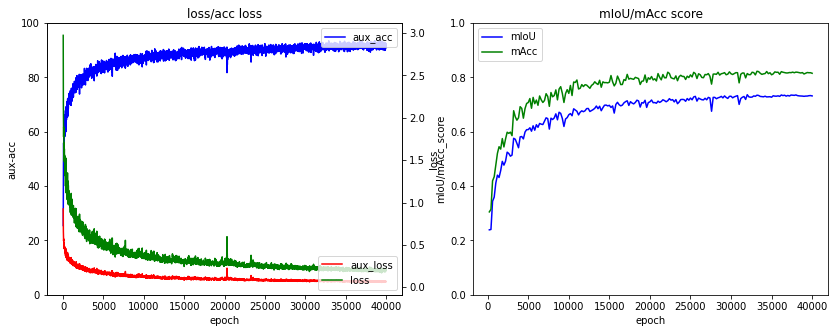

In [28]:
fig = plt.figure(figsize=(14, 5))

ax1 = fig.add_subplot(1, 2, 1)
ax2 = ax1.twinx()
line1, = ax2.plot(x_epoch_data,aux_loss,label='aux_loss',color='red') 
line2, = ax1.plot(x_epoch_data,aux_acc,label='aux_acc',color='blue')
line3, = ax2.plot(x_epoch_data,loss,label='loss',color='green')
ax1.set_title("loss/acc loss")
ax1.set_xlabel('epoch')
ax1.set_ylabel('aux-acc')
ax2.set_ylabel('loss')
ax1.set_ylim(0, 100)
ax1.legend(loc='upper right')
ax2.legend(loc='lower right')

ax3 = fig.add_subplot(1, 2, 2)
line1, = ax3.plot(x_epoch_data_2,mIou,label='mIoU',color='blue')
line2, = ax3.plot(x_epoch_data_2,mAcc,label='mAcc',color='green') 
ax3.set_title("mIoU/mAcc score")
ax3.set_xlabel('epoch')
ax3.set_ylabel('mIoU/mAcc_score')
ax3.set_ylim(0, 1)
ax3.legend(loc='upper left')

plt.show()

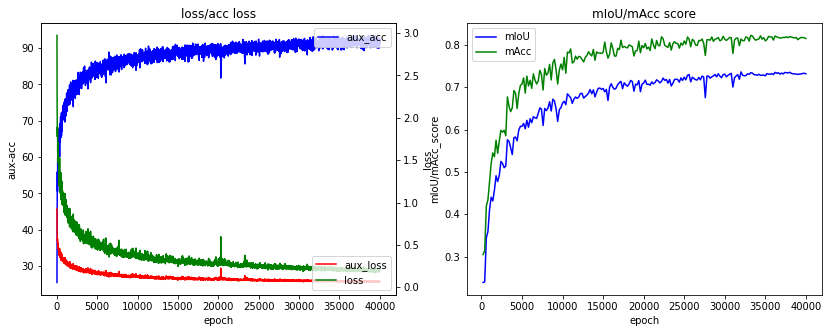

In [29]:
fig = plt.figure(figsize=(14, 5))

ax1 = fig.add_subplot(1, 2, 1)
ax2 = ax1.twinx()
line1, = ax2.plot(x_epoch_data,aux_loss,label='aux_loss',color='red') 
line2, = ax1.plot(x_epoch_data,aux_acc,label='aux_acc',color='blue')
line3, = ax2.plot(x_epoch_data,loss,label='loss',color='green')
ax1.set_title("loss/acc loss")
ax1.set_xlabel('epoch')
ax1.set_ylabel('aux-acc')
ax2.set_ylabel('loss')
ax1.legend(loc='upper right')
ax2.legend(loc='lower right')

ax3 = fig.add_subplot(1, 2, 2)
line1, = ax3.plot(x_epoch_data_2,mIou,label='mIoU',color='blue')
line2, = ax3.plot(x_epoch_data_2,mAcc,label='mAcc',color='green') 
ax3.set_title("mIoU/mAcc score")
ax3.set_xlabel('epoch')
ax3.set_ylabel('mIoU/mAcc_score')
ax3.legend(loc='upper left')

plt.show()

In [30]:
#save config

cfg_file = cfg.pretty_text
cfg_path = './work_dirs/tutorial_pspnet_r50A/cfg.py'

with open(cfg_path, mode='w') as f:
    f.write(cfg_file)

In [31]:
#mmsegmentationの実行のロード（GPUあり）

config_file = cfg_path
checkpoint_file = 'work_dirs/tutorial_pspnet_r50A/latest.pth'

model = init_segmentor(config_file, checkpoint_file, device='cuda:0')

load checkpoint from local path: work_dirs/tutorial_pspnet_r50A/latest.pth


<Figure size 576x432 with 0 Axes>

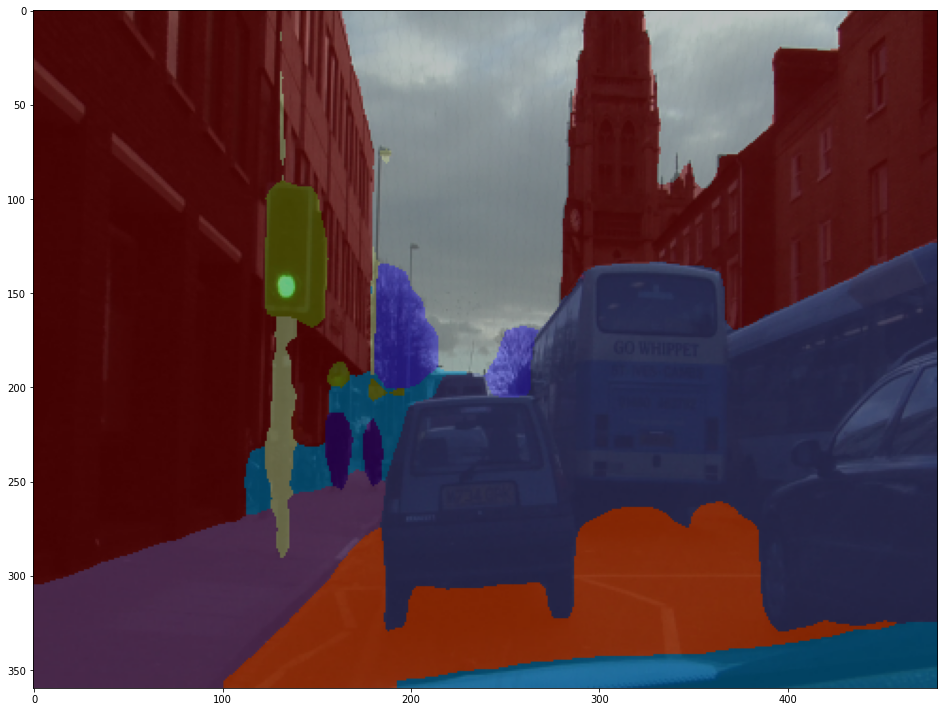

In [32]:
img = mmcv.imread('SegNet-Tutorial/CamVid/train/0001TP_006690.png')

model.cfg = cfg
result = inference_segmentor(model, img)
plt.figure(figsize=(8, 6))
show_result_pyplot(model, img, result, palette)

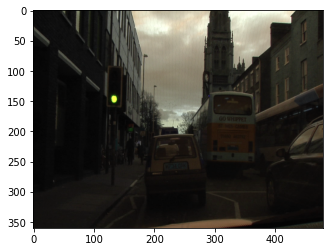

In [33]:
plt.imshow(img)

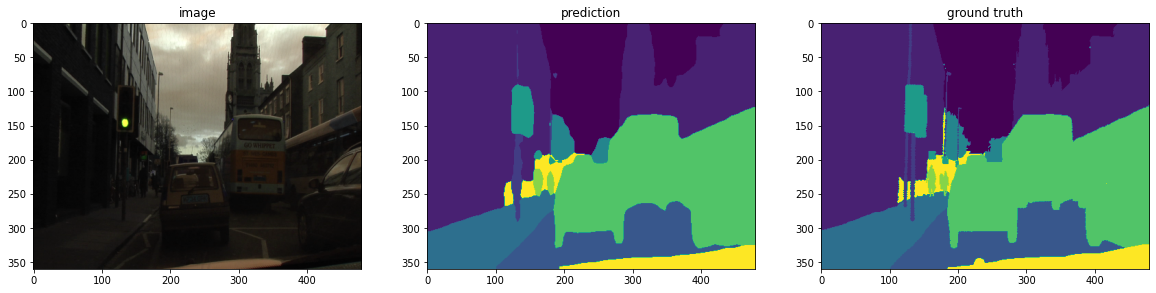

In [34]:
#画像を並べて表示

fig = plt.figure(figsize = (20, 15))
plt.subplots_adjust(wspace = 0.2, hspace = 0.0)

ax1 = fig.add_subplot(1, 3, 1)
ax1.set_title('image', loc = 'center')
img = mmcv.imread('SegNet-Tutorial/CamVid/train/0001TP_006690.png')
plt.imshow(img)

ax2 = fig.add_subplot(1, 3, 2)
ax2.set_title('prediction', loc = 'center')
plt.imshow(np.array(result).transpose(1, 2, 0))

ax3 = fig.add_subplot(1, 3, 3)
ax3.set_title('ground truth', loc = 'center')
img = Image.open('SegNet-Tutorial/CamVid/trainannot/0001TP_006690.png')
im_list_ann = np.asarray(img)
plt.imshow(im_list_ann)

plt.show()


In [35]:
# helper function for data visualization
def visualize(**images):
    """PLot images in one row."""
    n = len(images)
    plt.figure(figsize=(16, 5))
    for i, (name, image) in enumerate(images.items()):
        plt.subplot(1, n, i + 1)
        plt.xticks([])
        plt.yticks([])
        plt.title(' '.join(name.split('_')).title())
        plt.imshow(image)
    plt.show()

the number of the image:  367


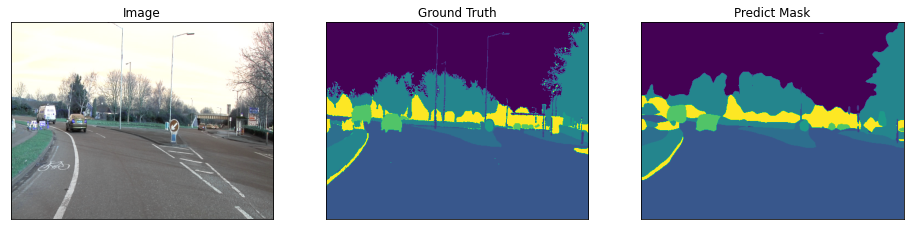

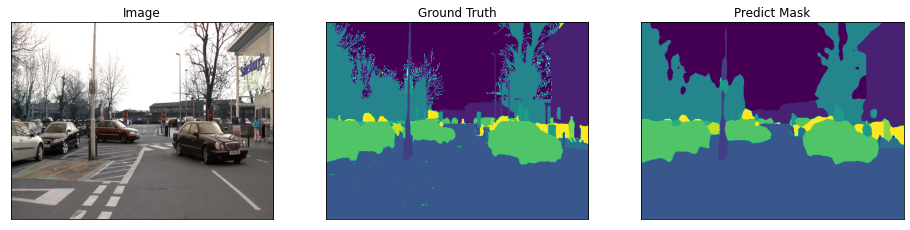

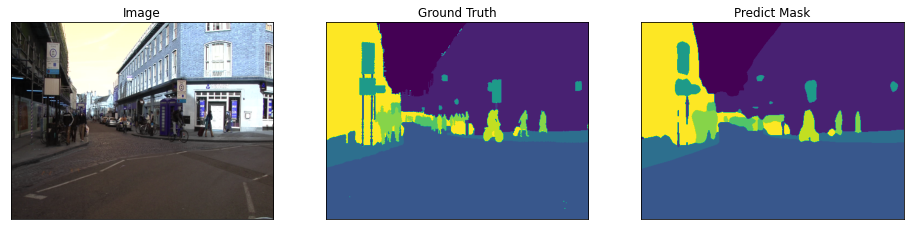

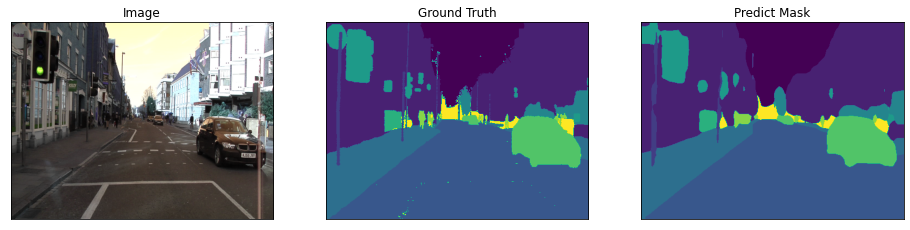

In [36]:

file_list = os.listdir('SegNet-Tutorial/CamVid/train')

print('the number of the image: ', len(file_list))

for i in range(4):
    n = np.random.choice(len(file_list))

    image2 = mmcv.imread(os.path.join('SegNet-Tutorial/CamVid/train', file_list[n]))
    
    result = inference_segmentor(model, image2)
    pred_mask2 = np.array(result).transpose(1, 2, 0)
                      
    mask2 = Image.open(os.path.join('SegNet-Tutorial/CamVid/trainannot', file_list[n]))

    visualize(
        image=image2, 
        ground_truth=mask2,
        predict_mask = result[0],
    )